In [33]:
from sklearn.naive_bayes import MultinomialNB
from audioop import cross
from contextlib import redirect_stdout
from sklearn.model_selection import StratifiedKFold
from mealpy.swarm_based import AO, HGS, SSA, MRFO, HHO
from matplotlib import pyplot
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, auc
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
import numpy as np
import pandas as pd
from numpy import mean
from numpy import std

DEFAULT_PARAMS = [0.0001, 0.1, 1e-3]

In [36]:
EN = pd.read_csv(f'./input/enron/messages.csv').fillna(' ')
X_EN = np.array(EN['message'])
y_EN = np.array(EN['label'])

LS = pd.read_csv(f'./input/ling_spam/messages.csv').fillna(' ')
X_LS = np.array(LS['message'])
y_LS = np.array(LS['label'])

SA = pd.read_csv(f'./input/spam_assasin/messages.csv').fillna(' ')
X_SA = np.array(SA['message'])
y_SA = np.array(SA['label'])

In [37]:
def resolve_dataset(name):
    if (name == 'EN'):
        return [X_EN.copy(), y_EN.copy()]
    elif (name == 'LS'):
        return [X_LS.copy(), y_LS.copy()]
    elif (name == 'SA'):
        return [X_SA.copy(), y_SA.copy()]
    else:
        return


def resolve_alg(alg):
    if alg == 'AO':
        return AO.OriginalAO
    elif alg == 'HGS':
        return HGS.OriginalHGS
    elif alg == 'SSA':
        return SSA.OriginalSSA
    elif alg == 'MRFO':
        return MRFO.BaseMRFO

In [38]:
def get_best(alg, X, y):
    if (alg == 'RSCV'):
        distributions = {
            'clf__epsilon': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'clf__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'clf__tol': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
        }
        skf = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
        clf = Pipeline([
            ('tfidf_vectorizer', TfidfVectorizer(
                stop_words=stopwords.words('english'))),
            ('clf', SGDClassifier(random_state=0, n_jobs=-1, class_weight='balanced'))])

        clf_random = RandomizedSearchCV(
            clf, distributions, scoring='accuracy', cv=skf, random_state=0)
        clf_random.fit(X, y)
        best = clf_random.best_params_

        return [best['clf__alpha'], best['clf__epsilon'], best['clf__tol']]

    alg = resolve_alg(alg)
    cv = TfidfVectorizer(stop_words=stopwords.words('english'))
    skf = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)

    alpha, epsilon, tol = [], [], []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        X_train = cv.fit_transform(X_train)
        X_test = cv.transform(X_test)

        def obj_function(solution):
            alpha, epsilon, tol = solution
            clf = SGDClassifier(random_state=0, class_weight='balanced', alpha=alpha,
                                epsilon=epsilon, tol=tol, n_jobs=-1)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            return accuracy_score(y_test, y_pred)

        problem = {
            'fit_func': obj_function,
            'lb': [0.0001, 0.0001, 0.0001],
            'ub': [1000, 1000, 1000],
            'minmax': 'max',
            'verbose': True,
        }

        model = alg(problem, epoch=10, pop_size=40)
        model.solve()
        a, e, t = model.g_best[0]
        alpha.append(a)
        epsilon.append(e)
        tol.append(t)

    return [mean(alpha), mean(epsilon), mean(tol)]

In [40]:
best_LS_RSCV = get_best('RSCV', X_LS, y_LS)

In [41]:
best_LS_MRFO = get_best('MRFO', X_LS, y_LS)

2022/04/04 05:27:53 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 05:27:53 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 05:27:53 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 05:27:53 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 05:27:53 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 05:27:53 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 05:27:53 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 05:27:53 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 05:27:53 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2

2022/04/04 05:27:56 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 1.13365 seconds
2022/04/04 05:27:56 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 1.13365 seconds
2022/04/04 05:27:56 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 1.13365 seconds
2022/04/04 05:27:56 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 1.13365 seconds
2022/04/04 05:27:56 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 1.13365 seconds
2022/04/04 05:27:56 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 1.13365 seconds
2022/04/04

2022/04/04 05:27:59 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 1.0, Global best: 1.0, Runtime: 1.28225 seconds
2022/04/04 05:27:59 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 1.0, Global best: 1.0, Runtime: 1.28225 seconds
2022/04/04 05:27:59 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 1.0, Global best: 1.0, Runtime: 1.28225 seconds
2022/04/04 05:27:59 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 1.0, Global best: 1.0, Runtime: 1.28225 seconds
2022/04/04 05:27:59 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 1.0, Global best: 1.0, Runtime: 1.28225 seconds
2022/04/04 05:27:59 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 1.0, Global best: 1.0, Runtime: 1.28225 seconds
2022/04/04 05:27:59 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 1.0, Global best: 1.0, Runtime: 1.28225 seconds
2022/04/04 05:27:59 PM, INFO, mealpy.swar

2022/04/04 05:28:03 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 1.36168 seconds
2022/04/04 05:28:03 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 1.36168 seconds
2022/04/04 05:28:03 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 1.36168 seconds
2022/04/04 05:28:03 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 1.36168 seconds
2022/04/04 05:28:03 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 1.36168 seconds
2022/04/04 05:28:03 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 1.36168 seconds
2022/04/04 05:28:03 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 1.36168 seconds
2022/04/04 05:28:03 PM, INFO, mealpy.swar

2022/04/04 05:28:07 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 05:28:07 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 05:28:07 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 05:28:07 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 05:28:07 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 05:28:07 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 05:28:07 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 05:28:07 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 05:28:07 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2

2022/04/04 05:28:10 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 1.0, Global best: 1.0, Runtime: 0.65414 seconds
2022/04/04 05:28:10 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 1.0, Global best: 1.0, Runtime: 0.65414 seconds
2022/04/04 05:28:10 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 1.0, Global best: 1.0, Runtime: 0.65414 seconds
2022/04/04 05:28:10 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 1.0, Global best: 1.0, Runtime: 0.65414 seconds
2022/04/04 05:28:10 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 1.0, Global best: 1.0, Runtime: 0.65414 seconds
2022/04/04 05:28:10 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 1.0, Global best: 1.0, Runtime: 0.65414 seconds
2022/04/04 05:28:10 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 1.0, Global best: 1.0, Runtime: 0.65414 seconds
2022/04/04 05:28:10 PM, INFO, mealpy.swar

2022/04/04 05:28:11 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 1.0, Global best: 1.0, Runtime: 0.65975 seconds
2022/04/04 05:28:11 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 1.0, Global best: 1.0, Runtime: 0.65975 seconds
2022/04/04 05:28:11 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 1.0, Global best: 1.0, Runtime: 0.65975 seconds
2022/04/04 05:28:12 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 1.0, Global best: 1.0, Runtime: 0.61536 seconds
2022/04/04 05:28:12 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 1.0, Global best: 1.0, Runtime: 0.61536 seconds
2022/04/04 05:28:12 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 1.0, Global best: 1.0, Runtime: 0.61536 seconds
2022/04/04 05:28:12 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 1.0, Global best: 1.0, Runtime: 0.61536 seconds
2022/04/04 05:28:12 PM, INFO, mealpy.swar

2022/04/04 05:28:13 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 0.66672 seconds
2022/04/04 05:28:13 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 0.66672 seconds
2022/04/04 05:28:13 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 0.66672 seconds
2022/04/04 05:28:13 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 0.66672 seconds
2022/04/04 05:28:13 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 0.66672 seconds
2022/04/04 05:28:13 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 0.66672 seconds
2022/04/04 05:28:13 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 0.66672 seconds
2022/04/04 05:28:13 PM, INFO, mealpy.swar

2022/04/04 05:28:15 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 05:28:15 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 05:28:15 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 05:28:15 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 05:28:15 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 05:28:15 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 05:28:15 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 05:28:15 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 05:28:15 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2

2022/04/04 05:28:17 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.993103448275862, Global best: 0.993103448275862, Runtime: 0.68703 seconds
2022/04/04 05:28:17 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.993103448275862, Global best: 0.993103448275862, Runtime: 0.68703 seconds
2022/04/04 05:28:17 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.993103448275862, Global best: 0.993103448275862, Runtime: 0.68703 seconds
2022/04/04 05:28:17 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.993103448275862, Global best: 0.993103448275862, Runtime: 0.68703 seconds
2022/04/04 05:28:17 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.993103448275862, Global best: 0.993103448275862, Runtime: 0.68703 seconds
2022/04/04 05:28:17 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.993103448275862, Global best: 0.993103448275862, Runtime: 0.68703 seconds
2022/04/04

2022/04/04 05:28:18 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.993103448275862, Global best: 0.993103448275862, Runtime: 0.66544 seconds
2022/04/04 05:28:18 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.993103448275862, Global best: 0.993103448275862, Runtime: 0.66544 seconds
2022/04/04 05:28:19 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.67216 seconds
2022/04/04 05:28:19 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.67216 seconds
2022/04/04 05:28:19 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.67216 seconds
2022/04/04 05:28:19 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.67216 seconds
2022/04/04

2022/04/04 05:28:21 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.63651 seconds
2022/04/04 05:28:21 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.63651 seconds
2022/04/04 05:28:21 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.63651 seconds
2022/04/04 05:28:21 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.63651 seconds
2022/04/04 05:28:21 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.63651 seconds
2022/04/04 05:28:21 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.63651 seconds
2022/04/04

2022/04/04 05:28:22 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.62974 seconds
2022/04/04 05:28:22 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.62974 seconds
2022/04/04 05:28:22 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.62974 seconds
2022/04/04 05:28:22 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.62974 seconds
2022/04/04 05:28:22 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.62974 seconds
2022/04/04 05:28:22 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.62974 seconds
2022/04/04

2022/04/04 05:28:23 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 05:28:23 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 05:28:23 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 05:28:23 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 05:28:23 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 05:28:23 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 05:28:23 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 05:28:23 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 05:28:23 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2

2022/04/04 05:28:26 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.06312 seconds
2022/04/04 05:28:26 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.06312 seconds
2022/04/04 05:28:26 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.06312 seconds
2022/04/04 05:28:26 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.06312 seconds
2022/04/04 05:28:27 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.18083 seconds
2022/04/04 05:28:27 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.18083 second

2022/04/04 05:28:28 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.27361 seconds
2022/04/04 05:28:28 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.27361 seconds
2022/04/04 05:28:30 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.25764 seconds
2022/04/04 05:28:30 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.25764 seconds
2022/04/04 05:28:30 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.25764 seconds
2022/04/04 05:28:30 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.25764 second

2022/04/04 05:28:32 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.38433 seconds
2022/04/04 05:28:32 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.38433 seconds
2022/04/04 05:28:32 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.38433 seconds
2022/04/04 05:28:32 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.38433 seconds
2022/04/04 05:28:32 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.38433 seconds
2022/04/04 05:28:32 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.38433 second

2022/04/04 05:28:35 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.33921 seconds
2022/04/04 05:28:35 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.33921 seconds
2022/04/04 05:28:35 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.33921 seconds
2022/04/04 05:28:35 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.33921 seconds
2022/04/04 05:28:35 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.33921 seconds
2022/04/04 05:28:35 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.33921 second

2022/04/04 05:28:37 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 05:28:37 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 05:28:37 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 05:28:37 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 05:28:37 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 05:28:37 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 05:28:37 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 05:28:37 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 05:28:37 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2

2022/04/04 05:28:39 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 1.0, Global best: 1.0, Runtime: 0.77322 seconds
2022/04/04 05:28:39 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 1.0, Global best: 1.0, Runtime: 0.77322 seconds
2022/04/04 05:28:39 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 1.0, Global best: 1.0, Runtime: 0.77322 seconds
2022/04/04 05:28:39 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 1.0, Global best: 1.0, Runtime: 0.77322 seconds
2022/04/04 05:28:39 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 1.0, Global best: 1.0, Runtime: 0.77322 seconds
2022/04/04 05:28:39 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 1.0, Global best: 1.0, Runtime: 0.77322 seconds
2022/04/04 05:28:40 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 1.0, Global best: 1.0, Runtime: 0.74107 seconds
2022/04/04 05:28:40 PM, INFO, mealpy.swar

2022/04/04 05:28:42 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 1.0, Global best: 1.0, Runtime: 0.72255 seconds
2022/04/04 05:28:42 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 1.0, Global best: 1.0, Runtime: 0.72255 seconds
2022/04/04 05:28:42 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 1.0, Global best: 1.0, Runtime: 0.72255 seconds
2022/04/04 05:28:42 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 1.0, Global best: 1.0, Runtime: 0.72255 seconds
2022/04/04 05:28:42 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 1.0, Global best: 1.0, Runtime: 0.72255 seconds
2022/04/04 05:28:42 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 1.0, Global best: 1.0, Runtime: 0.72255 seconds
2022/04/04 05:28:42 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 1.0, Global best: 1.0, Runtime: 0.72255 seconds
2022/04/04 05:28:42 PM, INFO, mealpy.swar

2022/04/04 05:28:43 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 1.0, Global best: 1.0, Runtime: 0.73116 seconds
2022/04/04 05:28:43 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 1.0, Global best: 1.0, Runtime: 0.73116 seconds
2022/04/04 05:28:43 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 1.0, Global best: 1.0, Runtime: 0.73116 seconds
2022/04/04 05:28:43 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 1.0, Global best: 1.0, Runtime: 0.73116 seconds
2022/04/04 05:28:43 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 1.0, Global best: 1.0, Runtime: 0.73116 seconds
2022/04/04 05:28:43 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 1.0, Global best: 1.0, Runtime: 0.73116 seconds
2022/04/04 05:28:43 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 1.0, Global best: 1.0, Runtime: 0.73116 seconds
2022/04/04 05:28:43 PM, INFO, mealpy.swar

2022/04/04 05:28:45 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 1.0, Global best: 1.0, Runtime: 0.72946 seconds
2022/04/04 05:28:45 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 1.0, Global best: 1.0, Runtime: 0.75138 seconds
2022/04/04 05:28:45 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 1.0, Global best: 1.0, Runtime: 0.75138 seconds
2022/04/04 05:28:45 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 1.0, Global best: 1.0, Runtime: 0.75138 seconds
2022/04/04 05:28:45 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 1.0, Global best: 1.0, Runtime: 0.75138 seconds
2022/04/04 05:28:45 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 1.0, Global best: 1.0, Runtime: 0.75138 seconds
2022/04/04 05:28:45 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 1.0, Global best: 1.0, Runtime: 0.75138 seconds
2022/04/04 05:28:45 PM, INFO, mealp

2022/04/04 05:28:48 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 1.0, Global best: 1.0, Runtime: 0.75314 seconds
2022/04/04 05:28:48 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 1.0, Global best: 1.0, Runtime: 0.75314 seconds
2022/04/04 05:28:48 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 1.0, Global best: 1.0, Runtime: 0.75314 seconds
2022/04/04 05:28:48 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 1.0, Global best: 1.0, Runtime: 0.75314 seconds
2022/04/04 05:28:48 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 1.0, Global best: 1.0, Runtime: 0.75314 seconds
2022/04/04 05:28:48 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 1.0, Global best: 1.0, Runtime: 0.75314 seconds
2022/04/04 05:28:48 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 1.0, Global best: 1.0, Runtime: 0.75314 seconds
2022/04/04 05:28:48 PM, INFO, mealpy.swar

2022/04/04 05:28:49 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 1.0, Global best: 1.0, Runtime: 0.67228 seconds
2022/04/04 05:28:49 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 1.0, Global best: 1.0, Runtime: 0.67228 seconds
2022/04/04 05:28:49 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 1.0, Global best: 1.0, Runtime: 0.67228 seconds
2022/04/04 05:28:49 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 1.0, Global best: 1.0, Runtime: 0.67228 seconds
2022/04/04 05:28:49 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 1.0, Global best: 1.0, Runtime: 0.67228 seconds
2022/04/04 05:28:50 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 1.0, Global best: 1.0, Runtime: 0.65920 seconds
2022/04/04 05:28:50 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 1.0, Global best: 1.0, Runtime: 0.65920 seconds
2022/04/04 05:28:50 PM, INFO, mealpy.swar

2022/04/04 05:28:51 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 1.0, Global best: 1.0, Runtime: 0.67403 seconds
2022/04/04 05:28:51 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 1.0, Global best: 1.0, Runtime: 0.67403 seconds
2022/04/04 05:28:51 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 1.0, Global best: 1.0, Runtime: 0.67403 seconds
2022/04/04 05:28:51 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 1.0, Global best: 1.0, Runtime: 0.67403 seconds
2022/04/04 05:28:51 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 1.0, Global best: 1.0, Runtime: 0.67403 seconds
2022/04/04 05:28:51 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 1.0, Global best: 1.0, Runtime: 0.67403 seconds
2022/04/04 05:28:51 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 1.0, Global best: 1.0, Runtime: 0.67403 seconds
2022/04/04 05:28:51 PM, INFO, mealpy.swar

2022/04/04 05:28:52 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 0.67434 seconds
2022/04/04 05:28:52 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 0.67434 seconds
2022/04/04 05:28:52 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 0.67434 seconds
2022/04/04 05:28:52 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 0.67434 seconds
2022/04/04 05:28:52 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 0.67434 seconds
2022/04/04 05:28:52 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 0.67434 seconds
2022/04/04 05:28:52 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 0.67434 seconds
2022/04/04 05:28:52 PM, INFO, mealpy.swar

2022/04/04 05:28:54 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 1.0, Global best: 1.0, Runtime: 0.64386 seconds
2022/04/04 05:28:54 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 1.0, Global best: 1.0, Runtime: 0.64386 seconds
2022/04/04 05:28:54 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 1.0, Global best: 1.0, Runtime: 0.64386 seconds
2022/04/04 05:28:54 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 1.0, Global best: 1.0, Runtime: 0.64386 seconds
2022/04/04 05:28:54 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 1.0, Global best: 1.0, Runtime: 0.64386 seconds
2022/04/04 05:28:54 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 1.0, Global best: 1.0, Runtime: 0.64386 seconds
2022/04/04 05:28:54 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 1.0, Global best: 1.0, Runtime: 0.64386 seconds
2022/04/04 05:28:55 PM, INFO, meal

2022/04/04 05:28:56 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.25853 seconds
2022/04/04 05:28:58 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.28525 seconds
2022/04/04 05:28:58 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.28525 seconds
2022/04/04 05:28:58 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.28525 seconds
2022/04/04 05:28:58 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.28525 seconds
2022/04/04 05:28:58 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.28525 second

2022/04/04 05:28:59 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.09617 seconds
2022/04/04 05:28:59 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.09617 seconds
2022/04/04 05:28:59 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.09617 seconds
2022/04/04 05:28:59 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.09617 seconds
2022/04/04 05:28:59 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.09617 seconds
2022/04/04 05:29:00 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.05759 second

2022/04/04 05:29:01 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.35432 seconds
2022/04/04 05:29:01 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.35432 seconds
2022/04/04 05:29:01 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.35432 seconds
2022/04/04 05:29:01 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.35432 seconds
2022/04/04 05:29:01 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.35432 seconds
2022/04/04 05:29:01 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.35432 second

2022/04/04 05:29:04 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.07834 seconds
2022/04/04 05:29:04 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.07834 seconds
2022/04/04 05:29:04 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.07834 seconds
2022/04/04 05:29:04 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.07834 seconds
2022/04/04 05:29:04 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.07834 seconds
2022/04/04 05:29:04 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.07834 second

2022/04/04 05:29:06 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.27520 seconds
2022/04/04 05:29:06 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.27520 seconds
2022/04/04 05:29:06 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.27520 seconds
2022/04/04 05:29:06 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.27520 seconds
2022/04/04 05:29:06 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.27520 seconds
2022/04/04 05:29:06 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.27520 second

2022/04/04 05:29:08 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 05:29:08 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 05:29:08 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 05:29:08 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 05:29:08 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 05:29:08 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 05:29:08 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 05:29:08 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 05:29:08 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2

2022/04/04 05:29:10 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.93387 seconds
2022/04/04 05:29:10 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.93387 seconds
2022/04/04 05:29:10 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.93387 seconds
2022/04/04 05:29:10 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.93387 seconds
2022/04/04 05:29:10 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.93387 seconds
2022/04/04 05:29:10 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.93387 second

2022/04/04 05:29:12 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.73821 seconds
2022/04/04 05:29:12 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.73821 seconds
2022/04/04 05:29:12 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.73821 seconds
2022/04/04 05:29:12 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.73821 seconds
2022/04/04 05:29:12 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.73821 seconds
2022/04/04 05:29:12 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.73821 second

2022/04/04 05:29:13 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.73554 seconds
2022/04/04 05:29:13 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.73554 seconds
2022/04/04 05:29:13 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.73554 seconds
2022/04/04 05:29:13 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.73554 seconds
2022/04/04 05:29:13 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.67521 seconds
2022/04/04 05:29:13 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.67521 second

2022/04/04 05:29:14 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.72220 seconds
2022/04/04 05:29:14 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.72220 seconds
2022/04/04 05:29:14 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.72220 seconds
2022/04/04 05:29:14 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.72220 seconds
2022/04/04 05:29:14 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.72220 seconds
2022/04/04 05:29:14 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.72220 second

2022/04/04 05:29:16 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.99578 seconds
2022/04/04 05:29:16 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.99578 seconds
2022/04/04 05:29:16 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.99578 seconds
2022/04/04 05:29:16 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.99578 seconds
2022/04/04 05:29:16 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.99578 seconds
2022/04/04 05:29:16 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.99578 second

2022/04/04 05:29:18 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 05:29:18 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 05:29:18 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 05:29:18 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 05:29:18 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 05:29:18 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 05:29:18 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 05:29:18 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 05:29:18 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2

2022/04/04 05:29:21 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.12437 seconds
2022/04/04 05:29:21 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.12437 seconds
2022/04/04 05:29:21 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.12437 seconds
2022/04/04 05:29:21 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.12437 seconds
2022/04/04 05:29:21 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.12437 seconds
2022/04/04 05:29:21 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.12437 second

2022/04/04 05:29:22 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.91067 seconds
2022/04/04 05:29:22 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.79060 seconds
2022/04/04 05:29:22 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.79060 seconds
2022/04/04 05:29:22 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.79060 seconds
2022/04/04 05:29:22 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.79060 seconds
2022/04/04 05:29:22 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.79060 second

2022/04/04 05:29:23 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.87689 seconds
2022/04/04 05:29:23 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.87689 seconds
2022/04/04 05:29:23 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.87689 seconds
2022/04/04 05:29:23 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.87689 seconds
2022/04/04 05:29:23 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.87689 seconds
2022/04/04 05:29:23 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.87689 second

2022/04/04 05:29:25 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.79080 seconds
2022/04/04 05:29:25 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.79080 seconds
2022/04/04 05:29:25 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.79080 seconds
2022/04/04 05:29:25 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.79080 seconds
2022/04/04 05:29:25 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.79080 seconds
2022/04/04 05:29:25 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.79080 second

2022/04/04 05:29:27 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.74600 seconds
2022/04/04 05:29:27 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.74600 seconds
2022/04/04 05:29:27 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.74600 seconds
2022/04/04 05:29:27 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.74600 seconds
2022/04/04 05:29:27 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.74600 seconds
2022/04/04 05:29:27 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.74600 second

2022/04/04 05:29:28 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.69350 seconds
2022/04/04 05:29:28 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.69350 seconds
2022/04/04 05:29:28 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.69350 seconds
2022/04/04 05:29:28 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.69350 seconds
2022/04/04 05:29:28 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.69350 seconds
2022/04/04 05:29:29 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 05:29:29 PM, INFO, mealpy.swarm_based.

2022/04/04 05:29:30 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.89927 seconds
2022/04/04 05:29:30 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.89927 seconds
2022/04/04 05:29:30 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.89927 seconds
2022/04/04 05:29:30 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.89927 seconds
2022/04/04 05:29:30 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.89927 seconds
2022/04/04 05:29:31 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.86668 second

2022/04/04 05:29:32 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.04246 seconds
2022/04/04 05:29:32 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.04246 seconds
2022/04/04 05:29:32 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.04246 seconds
2022/04/04 05:29:32 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.04246 seconds
2022/04/04 05:29:32 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.04246 seconds
2022/04/04 05:29:32 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.04246 second

2022/04/04 05:29:34 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.67676 seconds
2022/04/04 05:29:34 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.67676 seconds
2022/04/04 05:29:34 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.67676 seconds
2022/04/04 05:29:34 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.67676 seconds
2022/04/04 05:29:34 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.67676 seconds
2022/04/04 05:29:34 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.67676 second

2022/04/04 05:29:34 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.72504 seconds
2022/04/04 05:29:34 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.72504 seconds
2022/04/04 05:29:34 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.72504 seconds
2022/04/04 05:29:34 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.72504 seconds
2022/04/04 05:29:34 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.72504 seconds
2022/04/04 05:29:35 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.76168 second

2022/04/04 05:29:36 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.75430 seconds
2022/04/04 05:29:36 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.75430 seconds
2022/04/04 05:29:36 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.75430 seconds
2022/04/04 05:29:36 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.75430 seconds
2022/04/04 05:29:36 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.75430 seconds
2022/04/04 05:29:36 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.75430 second

2022/04/04 05:29:37 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 1.0, Global best: 1.0, Runtime: 0.76251 seconds
2022/04/04 05:29:37 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 1.0, Global best: 1.0, Runtime: 0.76251 seconds
2022/04/04 05:29:37 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 1.0, Global best: 1.0, Runtime: 0.76251 seconds
2022/04/04 05:29:37 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 1.0, Global best: 1.0, Runtime: 0.76251 seconds
2022/04/04 05:29:37 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 1.0, Global best: 1.0, Runtime: 0.76251 seconds
2022/04/04 05:29:37 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 1.0, Global best: 1.0, Runtime: 0.76251 seconds
2022/04/04 05:29:37 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 1.0, Global best: 1.0, Runtime: 0.76251 seconds
2022/04/04 05:29:37 PM, INFO, meal

In [55]:
best_LS_HGS = get_best('HGS', X_LS, y_LS)

2022/04/04 05:48:23 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 05:48:23 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 05:48:23 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 05:48:23 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 05:48:23 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 05:48:23 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 05:48:23 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 05:48:23 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 05:48:23 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optim

2022/04/04 05:48:24 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.63203 seconds
2022/04/04 05:48:24 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.63203 seconds
2022/04/04 05:48:24 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.63203 seconds
2022/04/04 05:48:24 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.63203 seconds
2022/04/04 05:48:24 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.63203 seconds
2022/04/04 05:48:24 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.63203 second

2022/04/04 05:48:26 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 1.0, Global best: 1.0, Runtime: 0.65627 seconds
2022/04/04 05:48:26 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 1.0, Global best: 1.0, Runtime: 0.65627 seconds
2022/04/04 05:48:26 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 1.0, Global best: 1.0, Runtime: 0.65627 seconds
2022/04/04 05:48:26 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 1.0, Global best: 1.0, Runtime: 0.65627 seconds
2022/04/04 05:48:26 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 1.0, Global best: 1.0, Runtime: 0.65627 seconds
2022/04/04 05:48:26 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 1.0, Global best: 1.0, Runtime: 0.65627 seconds
2022/04/04 05:48:26 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 1.0, Global best: 1.0, Runtime: 0.65627 seconds
2022/04/04 05:48:26 PM, INF

2022/04/04 05:48:27 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 1.0, Global best: 1.0, Runtime: 0.44186 seconds
2022/04/04 05:48:27 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 1.0, Global best: 1.0, Runtime: 0.44186 seconds
2022/04/04 05:48:27 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 1.0, Global best: 1.0, Runtime: 0.44186 seconds
2022/04/04 05:48:28 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 0.50641 seconds
2022/04/04 05:48:28 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 0.50641 seconds
2022/04/04 05:48:28 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 0.50641 seconds
2022/04/04 05:48:28 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 0.50641 seconds
2022/04/04 05:48:28 PM, INF

2022/04/04 05:48:29 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 1.0, Global best: 1.0, Runtime: 0.47508 seconds
2022/04/04 05:48:29 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 1.0, Global best: 1.0, Runtime: 0.47508 seconds
2022/04/04 05:48:29 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 1.0, Global best: 1.0, Runtime: 0.47508 seconds
2022/04/04 05:48:29 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 1.0, Global best: 1.0, Runtime: 0.47508 seconds
2022/04/04 05:48:29 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 1.0, Global best: 1.0, Runtime: 0.47508 seconds
2022/04/04 05:48:29 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 1.0, Global best: 1.0, Runtime: 0.47508 seconds
2022/04/04 05:48:29 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 1.0, Global best: 1.0, Runtime: 0.47508 seconds
2022/04/04 05:48:30 

2022/04/04 05:48:31 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.43439 seconds
2022/04/04 05:48:31 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.43439 seconds
2022/04/04 05:48:31 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.43439 seconds
2022/04/04 05:48:31 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.43439 seconds
2022/04/04 05:48:31 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.43439 seconds
2022/04/04 05:48:31 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.43439 second

2022/04/04 05:48:32 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.57632 seconds
2022/04/04 05:48:32 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.57632 seconds
2022/04/04 05:48:32 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.57632 seconds
2022/04/04 05:48:32 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.57632 seconds
2022/04/04 05:48:32 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.57632 seconds
2022/04/04 05:48:32 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.57632 second

2022/04/04 05:48:33 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.62812 seconds
2022/04/04 05:48:33 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.62812 seconds
2022/04/04 05:48:33 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.62812 seconds
2022/04/04 05:48:34 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.68935 seconds
2022/04/04 05:48:34 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.68935 seconds
2022/04/04 05:48:34 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.68935 second

2022/04/04 05:48:35 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.45896 seconds
2022/04/04 05:48:35 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.45896 seconds
2022/04/04 05:48:35 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.45896 seconds
2022/04/04 05:48:35 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.45896 seconds
2022/04/04 05:48:35 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.45896 seconds
2022/04/04 05:48:35 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.45896 second

2022/04/04 05:48:37 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 05:48:37 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 05:48:37 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 05:48:37 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 05:48:37 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 05:48:37 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 05:48:37 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 05:48:37 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 05:48:37 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optim

2022/04/04 05:48:38 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.46346 seconds
2022/04/04 05:48:38 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.46346 seconds
2022/04/04 05:48:38 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.46346 seconds
2022/04/04 05:48:38 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.46346 seconds
2022/04/04 05:48:38 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.49015 seconds
2022/04/04 05:48:38 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.

2022/04/04 05:48:39 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.47222 seconds
2022/04/04 05:48:39 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.48511 seconds
2022/04/04 05:48:39 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.48511 seconds
2022/04/04 05:48:39 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.48511 seconds
2022/04/04 05:48:39 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.48511 seconds
2022/04/04 05:48:39 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.

2022/04/04 05:48:41 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.51056 seconds
2022/04/04 05:48:41 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.51056 seconds
2022/04/04 05:48:41 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.51056 seconds
2022/04/04 05:48:41 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.51056 seconds
2022/04/04 05:48:41 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.51056 seconds
2022/04/04 05:48:41 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.

2022/04/04 05:48:42 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.54719 seconds
2022/04/04 05:48:42 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.54719 seconds
2022/04/04 05:48:42 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.54719 seconds
2022/04/04 05:48:42 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.54719 seconds
2022/04/04 05:48:42 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.54719 seconds
2022/04/04 05:48:42 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.

2022/04/04 05:48:43 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 05:48:43 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 05:48:43 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 05:48:43 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 05:48:43 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 05:48:43 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 05:48:43 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 05:48:43 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 05:48:43 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optim

2022/04/04 05:48:45 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.52144 seconds
2022/04/04 05:48:45 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.52144 seconds
2022/04/04 05:48:45 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.52144 seconds
2022/04/04 05:48:45 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.52144 seconds
2022/04/04 05:48:45 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.52144 seconds
2022/04/04 05:48:45 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.

2022/04/04 05:48:46 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.66974 seconds
2022/04/04 05:48:46 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.66974 seconds
2022/04/04 05:48:46 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.66974 seconds
2022/04/04 05:48:46 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.66974 seconds
2022/04/04 05:48:46 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.66974 seconds
2022/04/04 05:48:46 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.

2022/04/04 05:48:47 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.65880 seconds
2022/04/04 05:48:47 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.65880 seconds
2022/04/04 05:48:47 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.65880 seconds
2022/04/04 05:48:47 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.65880 seconds
2022/04/04 05:48:47 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.65880 seconds
2022/04/04 05:48:47 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.

2022/04/04 05:48:48 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.63705 seconds
2022/04/04 05:48:48 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.63705 seconds
2022/04/04 05:48:48 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.63705 seconds
2022/04/04 05:48:48 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.63705 seconds
2022/04/04 05:48:48 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.63705 seconds
2022/04/04 05:48:49 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.

2022/04/04 05:48:50 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.72418 seconds
2022/04/04 05:48:50 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.72418 seconds
2022/04/04 05:48:50 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.72418 seconds
2022/04/04 05:48:50 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.72418 seconds
2022/04/04 05:48:51 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 05:48:51 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 05:48:51 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective opt

2022/04/04 05:48:53 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.65626 seconds
2022/04/04 05:48:53 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.65626 seconds
2022/04/04 05:48:53 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.65626 seconds
2022/04/04 05:48:53 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.65626 seconds
2022/04/04 05:48:53 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.65626 seconds
2022/04/04 05:48:53 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.

2022/04/04 05:48:54 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.75968 seconds
2022/04/04 05:48:54 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.75968 seconds
2022/04/04 05:48:54 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.75968 seconds
2022/04/04 05:48:54 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.75968 seconds
2022/04/04 05:48:54 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.75968 seconds
2022/04/04 05:48:54 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.

2022/04/04 05:48:56 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 1.0, Global best: 1.0, Runtime: 0.69523 seconds
2022/04/04 05:48:56 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 1.0, Global best: 1.0, Runtime: 0.69523 seconds
2022/04/04 05:48:56 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 1.0, Global best: 1.0, Runtime: 0.69523 seconds
2022/04/04 05:48:56 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 1.0, Global best: 1.0, Runtime: 0.69523 seconds
2022/04/04 05:48:56 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 1.0, Global best: 1.0, Runtime: 0.69523 seconds
2022/04/04 05:48:56 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 1.0, Global best: 1.0, Runtime: 0.69523 seconds
2022/04/04 05:48:56 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 1.0, Global best: 1.0, Runtime: 0.69523 seconds
2022/04/04 05:48:56 PM, INF

2022/04/04 05:48:56 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 0.46730 seconds
2022/04/04 05:48:56 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 0.46730 seconds
2022/04/04 05:48:56 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 0.46730 seconds
2022/04/04 05:48:56 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 0.46730 seconds
2022/04/04 05:48:56 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 0.46730 seconds
2022/04/04 05:48:56 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 0.46730 seconds
2022/04/04 05:48:56 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 0.46730 seconds
2022/04/04 05:48:56 PM, INF

2022/04/04 05:48:57 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 1.0, Global best: 1.0, Runtime: 0.46187 seconds
2022/04/04 05:48:57 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 1.0, Global best: 1.0, Runtime: 0.46187 seconds
2022/04/04 05:48:57 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 1.0, Global best: 1.0, Runtime: 0.46187 seconds
2022/04/04 05:48:57 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 1.0, Global best: 1.0, Runtime: 0.46187 seconds
2022/04/04 05:48:57 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 1.0, Global best: 1.0, Runtime: 0.46187 seconds
2022/04/04 05:48:57 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 1.0, Global best: 1.0, Runtime: 0.46187 seconds
2022/04/04 05:48:58 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 05:48:58 PM, INFO, mealpy.swarm_base

2022/04/04 05:49:00 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 1.0, Global best: 1.0, Runtime: 0.38305 seconds
2022/04/04 05:49:00 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 1.0, Global best: 1.0, Runtime: 0.38305 seconds
2022/04/04 05:49:00 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 1.0, Global best: 1.0, Runtime: 0.38305 seconds
2022/04/04 05:49:00 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 1.0, Global best: 1.0, Runtime: 0.38305 seconds
2022/04/04 05:49:00 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 1.0, Global best: 1.0, Runtime: 0.38305 seconds
2022/04/04 05:49:00 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 1.0, Global best: 1.0, Runtime: 0.38305 seconds
2022/04/04 05:49:00 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 1.0, Global best: 1.0, Runtime: 0.38305 seconds
2022/04/04 05:49:00 PM, INF

2022/04/04 05:49:00 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 1.0, Global best: 1.0, Runtime: 0.35209 seconds
2022/04/04 05:49:00 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 1.0, Global best: 1.0, Runtime: 0.35209 seconds
2022/04/04 05:49:00 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 1.0, Global best: 1.0, Runtime: 0.35209 seconds
2022/04/04 05:49:00 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 1.0, Global best: 1.0, Runtime: 0.35209 seconds
2022/04/04 05:49:00 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 1.0, Global best: 1.0, Runtime: 0.35209 seconds
2022/04/04 05:49:00 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 1.0, Global best: 1.0, Runtime: 0.35209 seconds
2022/04/04 05:49:00 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 1.0, Global best: 1.0, Runtime: 0.35209 seconds
2022/04/04 05:49:00 PM, INF

2022/04/04 05:49:01 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 1.0, Global best: 1.0, Runtime: 0.35673 seconds
2022/04/04 05:49:01 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 1.0, Global best: 1.0, Runtime: 0.35673 seconds
2022/04/04 05:49:01 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 1.0, Global best: 1.0, Runtime: 0.35673 seconds
2022/04/04 05:49:01 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 1.0, Global best: 1.0, Runtime: 0.35673 seconds
2022/04/04 05:49:01 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 1.0, Global best: 1.0, Runtime: 0.35673 seconds
2022/04/04 05:49:01 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 1.0, Global best: 1.0, Runtime: 0.35673 seconds
2022/04/04 05:49:02 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 1.0, Global best: 1.0, Runtime: 0.34354 seconds
2022/04/04 05:49:02 PM, INF

2022/04/04 05:49:02 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 1.0, Global best: 1.0, Runtime: 0.32295 seconds
2022/04/04 05:49:02 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 1.0, Global best: 1.0, Runtime: 0.32295 seconds
2022/04/04 05:49:02 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 1.0, Global best: 1.0, Runtime: 0.32295 seconds
2022/04/04 05:49:02 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 1.0, Global best: 1.0, Runtime: 0.32295 seconds
2022/04/04 05:49:02 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 1.0, Global best: 1.0, Runtime: 0.32295 seconds
2022/04/04 05:49:02 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 1.0, Global best: 1.0, Runtime: 0.32295 seconds
2022/04/04 05:49:02 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 1.0, Global best: 1.0, Runtime: 0.32295 seconds
2022/04/04 05:49:02 PM, INF

2022/04/04 05:49:04 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 05:49:04 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 05:49:04 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 05:49:04 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 05:49:04 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 05:49:04 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 05:49:04 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 05:49:04 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 05:49:04 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optim

2022/04/04 05:49:05 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.38752 seconds
2022/04/04 05:49:05 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.38752 seconds
2022/04/04 05:49:05 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.38752 seconds
2022/04/04 05:49:05 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.38752 seconds
2022/04/04 05:49:05 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.38752 seconds
2022/04/04 05:49:05 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.

2022/04/04 05:49:06 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.33906 seconds
2022/04/04 05:49:06 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.33906 seconds
2022/04/04 05:49:06 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.33906 seconds
2022/04/04 05:49:06 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.33906 seconds
2022/04/04 05:49:06 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.33906 seconds
2022/04/04 05:49:06 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.

2022/04/04 05:49:06 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.31501 seconds
2022/04/04 05:49:06 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.31501 seconds
2022/04/04 05:49:06 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.31501 seconds
2022/04/04 05:49:06 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.31501 seconds
2022/04/04 05:49:06 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.31501 seconds
2022/04/04 05:49:06 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.

2022/04/04 05:49:07 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.38115 seconds
2022/04/04 05:49:07 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.38115 seconds
2022/04/04 05:49:07 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.38115 seconds
2022/04/04 05:49:07 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.38115 seconds
2022/04/04 05:49:07 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.34486 seconds
2022/04/04 05:49:07 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.

2022/04/04 05:49:08 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.51616 seconds
2022/04/04 05:49:08 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.51616 seconds
2022/04/04 05:49:08 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.51616 seconds
2022/04/04 05:49:08 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.51616 seconds
2022/04/04 05:49:08 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.51616 seconds
2022/04/04 05:49:08 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.

2022/04/04 05:49:09 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 05:49:09 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 05:49:09 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 05:49:09 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 05:49:09 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 05:49:09 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 05:49:09 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 05:49:09 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 05:49:09 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optim

2022/04/04 05:49:11 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.60193 seconds
2022/04/04 05:49:11 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.60193 seconds
2022/04/04 05:49:11 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.60193 seconds
2022/04/04 05:49:11 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.60193 seconds
2022/04/04 05:49:11 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.60193 seconds
2022/04/04 05:49:11 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.

2022/04/04 05:49:12 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.76597 seconds
2022/04/04 05:49:12 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.76597 seconds
2022/04/04 05:49:12 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.76597 seconds
2022/04/04 05:49:12 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.76597 seconds
2022/04/04 05:49:12 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.76597 seconds
2022/04/04 05:49:12 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.

2022/04/04 05:49:14 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.78013 seconds
2022/04/04 05:49:14 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.78013 seconds
2022/04/04 05:49:14 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.78013 seconds
2022/04/04 05:49:14 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.78013 seconds
2022/04/04 05:49:14 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.78013 seconds
2022/04/04 05:49:14 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.

2022/04/04 05:49:15 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.80428 seconds
2022/04/04 05:49:15 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.80428 seconds
2022/04/04 05:49:15 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.80428 seconds
2022/04/04 05:49:15 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.80428 seconds
2022/04/04 05:49:15 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.80428 seconds
2022/04/04 05:49:15 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.

2022/04/04 05:49:16 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.82308 seconds
2022/04/04 05:49:16 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.82308 seconds
2022/04/04 05:49:16 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.82308 seconds
2022/04/04 05:49:16 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.82308 seconds
2022/04/04 05:49:16 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.82308 seconds
2022/04/04 05:49:16 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.

2022/04/04 05:49:18 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 05:49:18 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 05:49:18 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 05:49:18 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 05:49:18 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 05:49:18 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 05:49:18 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 05:49:18 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 05:49:18 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optim

2022/04/04 05:49:20 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.48420 seconds
2022/04/04 05:49:20 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.48420 seconds
2022/04/04 05:49:20 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.48420 seconds
2022/04/04 05:49:20 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.48420 seconds
2022/04/04 05:49:20 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.48420 seconds
2022/04/04 05:49:20 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.

2022/04/04 05:49:20 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.58874 seconds
2022/04/04 05:49:21 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.64264 seconds
2022/04/04 05:49:21 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.64264 seconds
2022/04/04 05:49:21 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.64264 seconds
2022/04/04 05:49:21 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.64264 seconds
2022/04/04 05:49:21 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.

2022/04/04 05:49:22 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.70975 seconds
2022/04/04 05:49:22 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.70975 seconds
2022/04/04 05:49:22 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.70975 seconds
2022/04/04 05:49:22 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.70975 seconds
2022/04/04 05:49:22 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.70975 seconds
2022/04/04 05:49:22 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.

2022/04/04 05:49:23 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.71013 seconds
2022/04/04 05:49:23 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.71013 seconds
2022/04/04 05:49:23 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.71013 seconds
2022/04/04 05:49:23 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.71013 seconds
2022/04/04 05:49:23 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.71013 seconds
2022/04/04 05:49:23 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.

2022/04/04 05:49:25 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.74541 seconds
2022/04/04 05:49:25 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.74541 seconds
2022/04/04 05:49:25 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.74541 seconds
2022/04/04 05:49:25 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.74541 seconds
2022/04/04 05:49:25 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.74541 seconds
2022/04/04 05:49:25 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.

2022/04/04 05:49:25 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.74039 seconds
2022/04/04 05:49:25 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.74039 seconds
2022/04/04 05:49:25 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.74039 seconds
2022/04/04 05:49:25 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.74039 seconds
2022/04/04 05:49:25 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.74039 seconds
2022/04/04 05:49:25 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runti

2022/04/04 05:49:27 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.46231 seconds
2022/04/04 05:49:27 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.46231 seconds
2022/04/04 05:49:27 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.46231 seconds
2022/04/04 05:49:27 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.46231 seconds
2022/04/04 05:49:27 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.46231 seconds
2022/04/04 05:49:27 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.

2022/04/04 05:49:29 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.64492 seconds
2022/04/04 05:49:29 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.64492 seconds
2022/04/04 05:49:29 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.64492 seconds
2022/04/04 05:49:29 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.64492 seconds
2022/04/04 05:49:29 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.64492 seconds
2022/04/04 05:49:29 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.

2022/04/04 05:49:29 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.68758 seconds
2022/04/04 05:49:30 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.69574 seconds
2022/04/04 05:49:30 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.69574 seconds
2022/04/04 05:49:30 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.69574 seconds
2022/04/04 05:49:30 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.69574 seconds
2022/04/04 05:49:30 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.

2022/04/04 05:49:31 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.59826 seconds
2022/04/04 05:49:31 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.59826 seconds
2022/04/04 05:49:31 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.59826 seconds
2022/04/04 05:49:31 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.59826 seconds
2022/04/04 05:49:31 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.59826 seconds
2022/04/04 05:49:31 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.

2022/04/04 05:49:32 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.69093 seconds
2022/04/04 05:49:32 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.69093 seconds
2022/04/04 05:49:32 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.69093 seconds
2022/04/04 05:49:32 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.69093 seconds
2022/04/04 05:49:32 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.69093 seconds
2022/04/04 05:49:32 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.

2022/04/04 05:49:33 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.70904 seconds
2022/04/04 05:49:33 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.70904 seconds
2022/04/04 05:49:33 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.70904 seconds
2022/04/04 05:49:33 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.70904 seconds
2022/04/04 05:49:33 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.63356 seconds
2022/04/04 05:49:33 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 

In [56]:
best_LS_AO = get_best('AO', X_LS, y_LS)

2022/04/04 05:49:34 PM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 05:49:34 PM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 05:49:34 PM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 05:49:34 PM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 05:49:34 PM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 05:49:34 PM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 05:49:34 PM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 05:49:34 PM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 05:49:34 PM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2

2022/04/04 05:49:37 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 4, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.44092 seconds
2022/04/04 05:49:37 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.45530 seconds
2022/04/04 05:49:37 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.45530 seconds
2022/04/04 05:49:37 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.45530 seconds
2022/04/04 05:49:37 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.45530 seconds
2022/04/04 05:49:37 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.45530 seconds
2022/04/04

2022/04/04 05:49:40 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.66028 seconds
2022/04/04 05:49:40 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.66028 seconds
2022/04/04 05:49:40 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.66028 seconds
2022/04/04 05:49:40 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.66028 seconds
2022/04/04 05:49:40 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.66028 seconds
2022/04/04 05:49:40 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.66028 seconds
2022/04/04

2022/04/04 05:49:43 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.43958 seconds
2022/04/04 05:49:43 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.43958 seconds
2022/04/04 05:49:43 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.43958 seconds
2022/04/04 05:49:43 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.43958 seconds
2022/04/04 05:49:43 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.43958 seconds
2022/04/04 05:49:43 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.43958 seconds
2022/04/04

2022/04/04 05:49:45 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 7, Current best: 1.0, Global best: 1.0, Runtime: 0.65078 seconds
2022/04/04 05:49:46 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 0.51393 seconds
2022/04/04 05:49:46 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 0.51393 seconds
2022/04/04 05:49:46 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 0.51393 seconds
2022/04/04 05:49:46 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 0.51393 seconds
2022/04/04 05:49:46 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 0.51393 seconds
2022/04/04 05:49:46 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 0.51393 seconds
2022/04/04 05:49:46 PM, INFO, mealpy.swar

2022/04/04 05:49:49 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 1, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.43340 seconds
2022/04/04 05:49:49 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 1, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.43340 seconds
2022/04/04 05:49:49 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 1, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.43340 seconds
2022/04/04 05:49:49 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.42771 seconds
2022/04/04 05:49:49 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.42771 seconds
2022/04/04 05:49:49 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.42771 second

2022/04/04 05:49:50 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.43578 seconds
2022/04/04 05:49:50 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.43578 seconds
2022/04/04 05:49:50 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.43578 seconds
2022/04/04 05:49:50 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.43578 seconds
2022/04/04 05:49:50 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.43578 seconds
2022/04/04 05:49:51 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.44999 second

2022/04/04 05:49:52 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9896551724137931, Global best: 0.9896551724137931, Runtime: 0.45503 seconds
2022/04/04 05:49:52 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9896551724137931, Global best: 0.9896551724137931, Runtime: 0.45503 seconds
2022/04/04 05:49:52 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9896551724137931, Global best: 0.9896551724137931, Runtime: 0.45503 seconds
2022/04/04 05:49:52 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9896551724137931, Global best: 0.9896551724137931, Runtime: 0.45503 seconds
2022/04/04 05:49:52 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9896551724137931, Global best: 0.9896551724137931, Runtime: 0.45503 seconds
2022/04/04 05:49:52 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9896551724137931, Global best: 0.9896551724137931, Runtime: 0.45503 second

2022/04/04 05:49:55 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.44261 seconds
2022/04/04 05:49:55 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.44261 seconds
2022/04/04 05:49:55 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.44261 seconds
2022/04/04 05:49:55 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.44261 seconds
2022/04/04 05:49:55 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.44261 seconds
2022/04/04 05:49:55 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.44261 second

2022/04/04 05:49:57 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.44650 seconds
2022/04/04 05:49:57 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.44650 seconds
2022/04/04 05:49:57 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.44650 seconds
2022/04/04 05:49:57 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.44650 seconds
2022/04/04 05:49:57 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.44650 seconds
2022/04/04 05:49:57 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.44650 second

2022/04/04 05:49:59 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.67870 seconds
2022/04/04 05:49:59 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.67870 seconds
2022/04/04 05:49:59 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.67870 seconds
2022/04/04 05:49:59 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.67870 seconds
2022/04/04 05:49:59 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.67870 seconds
2022/04/04 05:49:59 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.67870 second

2022/04/04 05:50:02 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.41661 seconds
2022/04/04 05:50:02 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.41661 seconds
2022/04/04 05:50:02 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.41661 seconds
2022/04/04 05:50:02 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.41661 seconds
2022/04/04 05:50:02 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.41661 seconds
2022/04/04 05:50:02 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.41661 second

2022/04/04 05:50:03 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.44551 seconds
2022/04/04 05:50:03 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.44551 seconds
2022/04/04 05:50:03 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.44551 seconds
2022/04/04 05:50:03 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.44551 seconds
2022/04/04 05:50:03 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.44551 seconds
2022/04/04 05:50:04 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.43399 second

2022/04/04 05:50:06 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.74601 seconds
2022/04/04 05:50:06 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.74601 seconds
2022/04/04 05:50:06 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.74601 seconds
2022/04/04 05:50:06 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.74601 seconds
2022/04/04 05:50:06 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.74601 seconds
2022/04/04 05:50:06 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.74601 second

2022/04/04 05:50:09 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 1, Current best: 1.0, Global best: 1.0, Runtime: 0.42317 seconds
2022/04/04 05:50:09 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 1, Current best: 1.0, Global best: 1.0, Runtime: 0.42317 seconds
2022/04/04 05:50:09 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 1, Current best: 1.0, Global best: 1.0, Runtime: 0.42317 seconds
2022/04/04 05:50:09 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 1, Current best: 1.0, Global best: 1.0, Runtime: 0.42317 seconds
2022/04/04 05:50:09 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 1, Current best: 1.0, Global best: 1.0, Runtime: 0.42317 seconds
2022/04/04 05:50:09 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 1.0, Global best: 1.0, Runtime: 0.45343 seconds
2022/04/04 05:50:09 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 1.0, Global best: 1.0, Runtime: 0.45343 seconds
2022/04/04 05:50:09 PM, INFO, mealpy.swar

2022/04/04 05:50:11 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 1.0, Global best: 1.0, Runtime: 0.42498 seconds
2022/04/04 05:50:11 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 1.0, Global best: 1.0, Runtime: 0.42498 seconds
2022/04/04 05:50:11 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 1.0, Global best: 1.0, Runtime: 0.42498 seconds
2022/04/04 05:50:11 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 1.0, Global best: 1.0, Runtime: 0.42498 seconds
2022/04/04 05:50:11 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 1.0, Global best: 1.0, Runtime: 0.42498 seconds
2022/04/04 05:50:11 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 1.0, Global best: 1.0, Runtime: 0.42498 seconds
2022/04/04 05:50:11 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 1.0, Global best: 1.0, Runtime: 0.42498 seconds
2022/04/04 05:50:11 PM, INFO, mealpy.swar

2022/04/04 05:50:13 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 1.0, Global best: 1.0, Runtime: 0.52108 seconds
2022/04/04 05:50:13 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 1.0, Global best: 1.0, Runtime: 0.52108 seconds
2022/04/04 05:50:13 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 1.0, Global best: 1.0, Runtime: 0.52108 seconds
2022/04/04 05:50:13 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 1.0, Global best: 1.0, Runtime: 0.52108 seconds
2022/04/04 05:50:13 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 1.0, Global best: 1.0, Runtime: 0.52108 seconds
2022/04/04 05:50:13 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 1.0, Global best: 1.0, Runtime: 0.52108 seconds
2022/04/04 05:50:13 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 1.0, Global best: 1.0, Runtime: 0.52108 seconds
2022/04/04 05:50:13 PM, INFO, mealpy.swar

2022/04/04 05:50:15 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 1, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.43752 seconds
2022/04/04 05:50:15 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 1, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.43752 seconds
2022/04/04 05:50:15 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 1, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.43752 seconds
2022/04/04 05:50:15 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.45357 seconds
2022/04/04 05:50:15 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.45357 seconds
2022/04/04 05:50:15 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.45357 second

2022/04/04 05:50:16 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.44749 seconds
2022/04/04 05:50:16 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.44749 seconds
2022/04/04 05:50:16 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.44749 seconds
2022/04/04 05:50:16 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.44749 seconds
2022/04/04 05:50:17 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.46239 seconds
2022/04/04 05:50:17 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.46239 second

2022/04/04 05:50:18 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.52111 seconds
2022/04/04 05:50:18 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.52111 seconds
2022/04/04 05:50:18 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.52111 seconds
2022/04/04 05:50:18 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.52111 seconds
2022/04/04 05:50:18 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.52111 seconds
2022/04/04 05:50:18 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.55585 second

2022/04/04 05:50:20 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.65031 seconds
2022/04/04 05:50:20 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.65031 seconds
2022/04/04 05:50:20 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.65031 seconds
2022/04/04 05:50:20 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.65031 seconds
2022/04/04 05:50:20 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.65031 seconds
2022/04/04 05:50:20 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.65031 

2022/04/04 05:50:22 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.46728 seconds
2022/04/04 05:50:22 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.46728 seconds
2022/04/04 05:50:22 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.46728 seconds
2022/04/04 05:50:22 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.46728 seconds
2022/04/04 05:50:22 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.46728 seconds
2022/04/04 05:50:22 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.46921 second

2022/04/04 05:50:23 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.51822 seconds
2022/04/04 05:50:23 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.51822 seconds
2022/04/04 05:50:23 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.51822 seconds
2022/04/04 05:50:23 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.51822 seconds
2022/04/04 05:50:23 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.51822 seconds
2022/04/04 05:50:23 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.51822 second

2022/04/04 05:50:25 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.56764 seconds
2022/04/04 05:50:25 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.56764 seconds
2022/04/04 05:50:25 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.56764 seconds
2022/04/04 05:50:25 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.56764 seconds
2022/04/04 05:50:25 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.56764 seconds
2022/04/04 05:50:25 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.56764 second

2022/04/04 05:50:27 PM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 05:50:27 PM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 05:50:27 PM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 05:50:27 PM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 05:50:27 PM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 05:50:27 PM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 05:50:27 PM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 05:50:27 PM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 05:50:27 PM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2

2022/04/04 05:50:29 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.972318339100346, Global best: 0.972318339100346, Runtime: 0.47056 seconds
2022/04/04 05:50:29 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9757785467128027, Global best: 0.9757785467128027, Runtime: 0.47774 seconds
2022/04/04 05:50:29 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9757785467128027, Global best: 0.9757785467128027, Runtime: 0.47774 seconds
2022/04/04 05:50:29 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9757785467128027, Global best: 0.9757785467128027, Runtime: 0.47774 seconds
2022/04/04 05:50:29 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9757785467128027, Global best: 0.9757785467128027, Runtime: 0.47774 seconds
2022/04/04 05:50:29 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9757785467128027, Global best: 0.9757785467128027, Runtime: 0.47774 seconds


2022/04/04 05:50:30 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.48049 seconds
2022/04/04 05:50:30 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.48049 seconds
2022/04/04 05:50:30 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.48049 seconds
2022/04/04 05:50:30 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.48049 seconds
2022/04/04 05:50:30 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.48049 seconds
2022/04/04 05:50:30 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.48049 second

2022/04/04 05:50:32 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.51057 seconds
2022/04/04 05:50:32 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.51057 seconds
2022/04/04 05:50:32 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.51057 seconds
2022/04/04 05:50:32 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.51057 seconds
2022/04/04 05:50:32 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.51057 seconds
2022/04/04 05:50:32 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.51057 second

2022/04/04 05:50:33 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.53763 seconds
2022/04/04 05:50:33 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.53763 seconds
2022/04/04 05:50:33 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.53763 seconds
2022/04/04 05:50:33 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.53763 seconds
2022/04/04 05:50:34 PM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 05:50:34 PM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 05:50:34 PM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization prob

2022/04/04 05:50:36 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.48725 seconds
2022/04/04 05:50:36 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.48725 seconds
2022/04/04 05:50:36 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.48725 seconds
2022/04/04 05:50:36 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.48725 seconds
2022/04/04 05:50:36 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.48725 seconds
2022/04/04 05:50:36 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.48725 second

2022/04/04 05:50:37 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.49911 seconds
2022/04/04 05:50:37 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.49911 seconds
2022/04/04 05:50:37 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.49911 seconds
2022/04/04 05:50:37 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.49911 seconds
2022/04/04 05:50:37 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.49911 seconds
2022/04/04 05:50:37 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.49911 second

2022/04/04 05:50:38 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.61425 seconds
2022/04/04 05:50:38 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.61425 seconds
2022/04/04 05:50:38 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.61425 seconds
2022/04/04 05:50:38 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.61425 seconds
2022/04/04 05:50:38 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.61425 seconds
2022/04/04 05:50:38 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.61425 second

2022/04/04 05:50:41 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.74343 seconds
2022/04/04 05:50:41 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.74343 seconds
2022/04/04 05:50:41 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.74343 seconds
2022/04/04 05:50:41 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.74343 seconds
2022/04/04 05:50:41 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.74343 seconds
2022/04/04 05:50:41 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.74343 

In [57]:
best_LS_SSA = get_best('SSA', X_LS, y_LS)

2022/04/04 05:50:42 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 05:50:42 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 05:50:42 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 05:50:42 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 05:50:42 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 05:50:42 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 05:50:42 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 05:50:42 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 05:50:42 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optim

2022/04/04 05:50:48 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 1.51300 seconds
2022/04/04 05:50:48 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 1.51300 seconds
2022/04/04 05:50:49 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 1.53436 seconds
2022/04/04 05:50:49 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 1.53436 seconds
2022/04/04 05:50:49 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 1.53436 seconds
2022/04/04 05:50:49 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 1.53436 second

2022/04/04 05:50:55 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 1.43199 seconds
2022/04/04 05:50:55 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 1.43199 seconds
2022/04/04 05:50:55 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 1.43199 seconds
2022/04/04 05:50:55 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 1.43199 seconds
2022/04/04 05:50:55 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 1.43199 seconds
2022/04/04 05:50:55 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 1.43199 second

2022/04/04 05:51:00 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 1.06991 seconds
2022/04/04 05:51:01 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 3, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 1.00365 seconds
2022/04/04 05:51:01 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 3, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 1.00365 seconds
2022/04/04 05:51:01 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 3, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 1.00365 seconds
2022/04/04 05:51:01 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 3, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 1.00365 seconds
2022/04/04 05:51:01 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 3, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 1.00365 second

2022/04/04 05:51:05 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 1.0, Global best: 1.0, Runtime: 1.03958 seconds
2022/04/04 05:51:05 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 1.0, Global best: 1.0, Runtime: 1.03958 seconds
2022/04/04 05:51:05 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 1.0, Global best: 1.0, Runtime: 1.03958 seconds
2022/04/04 05:51:05 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 1.0, Global best: 1.0, Runtime: 1.03958 seconds
2022/04/04 05:51:05 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 1.0, Global best: 1.0, Runtime: 1.03958 seconds
2022/04/04 05:51:05 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 1.0, Global best: 1.0, Runtime: 1.03958 seconds
2022/04/04 05:51:05 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 1.0, Global best: 1.0, Runtime: 1.03958 seconds
2022/04/04 05:51:06 PM, INF

2022/04/04 05:51:10 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 0.9896551724137931, Global best: 0.9896551724137931, Runtime: 0.85108 seconds
2022/04/04 05:51:10 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 0.9896551724137931, Global best: 0.9896551724137931, Runtime: 0.85108 seconds
2022/04/04 05:51:10 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 0.9896551724137931, Global best: 0.9896551724137931, Runtime: 0.85108 seconds
2022/04/04 05:51:10 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 0.9896551724137931, Global best: 0.9896551724137931, Runtime: 0.85108 seconds
2022/04/04 05:51:10 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 0.9896551724137931, Global best: 0.9896551724137931, Runtime: 0.85108 seconds
2022/04/04 05:51:10 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 0.9896551724137931, Global best: 0.9896551724137931, Runtime: 0.

2022/04/04 05:51:14 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.9896551724137931, Global best: 0.9896551724137931, Runtime: 0.83472 seconds
2022/04/04 05:51:14 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.9896551724137931, Global best: 0.9896551724137931, Runtime: 0.83472 seconds
2022/04/04 05:51:14 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.9896551724137931, Global best: 0.9896551724137931, Runtime: 0.83472 seconds
2022/04/04 05:51:14 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.9896551724137931, Global best: 0.9896551724137931, Runtime: 0.83472 seconds
2022/04/04 05:51:14 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.9896551724137931, Global best: 0.9896551724137931, Runtime: 0.83472 seconds
2022/04/04 05:51:14 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.9896551724137931, Global best: 0.9896551724137931, Runtime: 0.

2022/04/04 05:51:16 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 8, Current best: 0.9896551724137931, Global best: 0.9896551724137931, Runtime: 0.87442 seconds
2022/04/04 05:51:17 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9896551724137931, Global best: 0.9896551724137931, Runtime: 0.86861 seconds
2022/04/04 05:51:17 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9896551724137931, Global best: 0.9896551724137931, Runtime: 0.86861 seconds
2022/04/04 05:51:17 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9896551724137931, Global best: 0.9896551724137931, Runtime: 0.86861 seconds
2022/04/04 05:51:17 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9896551724137931, Global best: 0.9896551724137931, Runtime: 0.86861 seconds
2022/04/04 05:51:17 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9896551724137931, Global best: 0.9896551724137931, Runtime: 0.

2022/04/04 05:51:21 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.87701 seconds
2022/04/04 05:51:22 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.96136 seconds
2022/04/04 05:51:22 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.96136 seconds
2022/04/04 05:51:22 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.96136 seconds
2022/04/04 05:51:22 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.96136 seconds
2022/04/04 05:51:22 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.

2022/04/04 05:51:24 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.97771 seconds
2022/04/04 05:51:24 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.97771 seconds
2022/04/04 05:51:24 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.97771 seconds
2022/04/04 05:51:24 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.97771 seconds
2022/04/04 05:51:24 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.97771 seconds
2022/04/04 05:51:24 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.

2022/04/04 05:51:28 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.10208 seconds
2022/04/04 05:51:29 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.10586 seconds
2022/04/04 05:51:29 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.10586 seconds
2022/04/04 05:51:29 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.10586 seconds
2022/04/04 05:51:29 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.10586 seconds
2022/04/04 05:51:29 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.

2022/04/04 05:51:33 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.36580 seconds
2022/04/04 05:51:33 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.36580 seconds
2022/04/04 05:51:33 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.36580 seconds
2022/04/04 05:51:33 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.36580 seconds
2022/04/04 05:51:33 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.36580 seconds
2022/04/04 05:51:34 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.

2022/04/04 05:51:37 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.26306 seconds
2022/04/04 05:51:39 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.45275 seconds
2022/04/04 05:51:39 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.45275 seconds
2022/04/04 05:51:39 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.45275 seconds
2022/04/04 05:51:39 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.45275 seconds
2022/04/04 05:51:39 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.

2022/04/04 05:51:43 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.57646 seconds
2022/04/04 05:51:43 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.57646 seconds
2022/04/04 05:51:43 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.57646 seconds
2022/04/04 05:51:43 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.57646 seconds
2022/04/04 05:51:43 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.57646 seconds
2022/04/04 05:51:43 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.

2022/04/04 05:51:47 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 05:51:47 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 05:51:47 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 05:51:47 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 05:51:47 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 05:51:47 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 05:51:49 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 1.0, Global best: 1.0, Runtime: 0.96056 seconds
2022/04/04 05:51:49 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 1.0, Global best: 1.0, Runtime: 0.96056 seconds
2022/04/04 05:51:49 PM, INFO, mealpy.swarm_b

2022/04/04 05:51:52 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 1.0, Global best: 1.0, Runtime: 1.03677 seconds
2022/04/04 05:51:52 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 1.0, Global best: 1.0, Runtime: 1.03677 seconds
2022/04/04 05:51:52 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 1.0, Global best: 1.0, Runtime: 1.03677 seconds
2022/04/04 05:51:52 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 1.0, Global best: 1.0, Runtime: 1.03677 seconds
2022/04/04 05:51:52 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 1.0, Global best: 1.0, Runtime: 1.03677 seconds
2022/04/04 05:51:52 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 1.0, Global best: 1.0, Runtime: 1.03677 seconds
2022/04/04 05:51:52 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 1.0, Global best: 1.0, Runtime: 1.03677 seconds
2022/04/04 05:51:52 PM, INF

2022/04/04 05:51:56 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 1.34132 seconds
2022/04/04 05:51:56 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 1.34132 seconds
2022/04/04 05:51:56 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 1.34132 seconds
2022/04/04 05:51:56 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 1.34132 seconds
2022/04/04 05:51:56 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 1.34132 seconds
2022/04/04 05:51:56 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 1.34132 seconds
2022/04/04 05:51:56 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 1.34132 seconds
2022/04/04 05:51:56 PM, INF

2022/04/04 05:52:00 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 05:52:01 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.86532 seconds
2022/04/04 05:52:01 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.86532 seconds
2022/04/04 05:52:01 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.86532 seconds
2022/04/04 05:52:01 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.86532 seconds
2022/04/04 05:52:01 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.86532 seconds
2022/04/04 05:52:01 PM, INFO, mealpy.swarm

2022/04/04 05:52:03 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 3, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.96158 seconds
2022/04/04 05:52:03 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 3, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.96158 seconds
2022/04/04 05:52:03 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 3, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.96158 seconds
2022/04/04 05:52:04 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.99911 seconds
2022/04/04 05:52:04 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.99911 seconds
2022/04/04 05:52:04 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.

2022/04/04 05:52:06 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 6, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.00095 seconds
2022/04/04 05:52:06 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 6, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.00095 seconds
2022/04/04 05:52:06 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 6, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.00095 seconds
2022/04/04 05:52:06 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 6, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.00095 seconds
2022/04/04 05:52:06 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 6, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.00095 seconds
2022/04/04 05:52:07 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.

2022/04/04 05:52:09 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.00897 seconds
2022/04/04 05:52:09 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.00897 seconds
2022/04/04 05:52:09 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.00897 seconds
2022/04/04 05:52:09 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.00897 seconds
2022/04/04 05:52:09 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.00897 seconds
2022/04/04 05:52:09 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.

2022/04/04 05:52:13 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 1.24757 seconds
2022/04/04 05:52:13 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 1.24757 seconds
2022/04/04 05:52:13 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 1.24757 seconds
2022/04/04 05:52:13 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 1.24757 seconds
2022/04/04 05:52:13 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 1.24757 seconds
2022/04/04 05:52:14 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 1.

2022/04/04 05:52:17 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 1.30364 seconds
2022/04/04 05:52:17 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 1.30364 seconds
2022/04/04 05:52:17 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 1.30364 seconds
2022/04/04 05:52:17 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 1.30364 seconds
2022/04/04 05:52:17 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 1.30364 seconds
2022/04/04 05:52:17 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 1.

2022/04/04 05:52:21 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 1.41523 seconds
2022/04/04 05:52:21 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 1.41523 seconds
2022/04/04 05:52:21 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 1.41523 seconds
2022/04/04 05:52:21 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 1.41523 seconds
2022/04/04 05:52:21 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 1.41523 seconds
2022/04/04 05:52:21 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 1.

2022/04/04 05:52:24 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 1.36255 seconds
2022/04/04 05:52:24 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 1.36255 seconds
2022/04/04 05:52:25 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 1.34522 seconds
2022/04/04 05:52:25 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 1.34522 seconds
2022/04/04 05:52:25 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 1.34522 seconds
2022/04/04 05:52:25 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime

2022/04/04 05:52:28 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.82073 seconds
2022/04/04 05:52:28 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.82073 seconds
2022/04/04 05:52:28 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.82073 seconds
2022/04/04 05:52:28 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.77666 seconds
2022/04/04 05:52:28 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.77666 seconds
2022/04/04 05:52:28 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.

2022/04/04 05:52:31 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.05327 seconds
2022/04/04 05:52:31 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.05327 seconds
2022/04/04 05:52:31 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.05327 seconds
2022/04/04 05:52:31 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.05327 seconds
2022/04/04 05:52:31 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.05327 seconds
2022/04/04 05:52:31 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.

2022/04/04 05:52:33 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.80080 seconds
2022/04/04 05:52:33 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.80080 seconds
2022/04/04 05:52:33 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.80080 seconds
2022/04/04 05:52:33 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.80080 seconds
2022/04/04 05:52:33 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.80080 seconds
2022/04/04 05:52:33 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.

2022/04/04 05:52:35 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.96185 seconds
2022/04/04 05:52:35 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.96185 seconds
2022/04/04 05:52:35 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.96185 seconds
2022/04/04 05:52:35 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.96185 seconds
2022/04/04 05:52:35 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.96185 seconds
2022/04/04 05:52:35 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.

2022/04/04 05:52:38 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 1.10230 seconds
2022/04/04 05:52:38 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 1.10230 seconds
2022/04/04 05:52:38 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 1.10230 seconds
2022/04/04 05:52:38 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 1.10230 seconds
2022/04/04 05:52:38 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 1.10230 seconds
2022/04/04 05:52:38 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 1.

2022/04/04 05:52:41 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 3, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.45697 seconds
2022/04/04 05:52:41 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 3, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.45697 seconds
2022/04/04 05:52:41 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 3, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.45697 seconds
2022/04/04 05:52:43 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.32844 seconds
2022/04/04 05:52:43 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.32844 seconds
2022/04/04 05:52:43 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.

2022/04/04 05:52:45 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 6, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.26612 seconds
2022/04/04 05:52:45 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 6, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.26612 seconds
2022/04/04 05:52:45 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 6, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.26612 seconds
2022/04/04 05:52:45 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 6, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.26612 seconds
2022/04/04 05:52:45 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 6, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.26612 seconds
2022/04/04 05:52:45 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 6, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.

2022/04/04 05:52:48 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.44753 seconds
2022/04/04 05:52:48 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.44753 seconds
2022/04/04 05:52:48 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.44753 seconds
2022/04/04 05:52:48 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.44753 seconds
2022/04/04 05:52:48 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.44753 seconds
2022/04/04 05:52:49 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.

In [36]:
best_spam_assasin_RSCV = get_best('RSCV', X_spam_assasin, y_spam_assasin)

In [37]:
best_spam_assasin_MRFO = get_best('MRFO', X_spam_assasin, y_spam_assasin)

2022/04/04 01:51:09 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 01:51:09 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 01:51:09 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 01:51:09 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 01:51:09 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 01:51:09 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 01:51:09 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 01:51:09 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 01:51:09 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2

2022/04/04 01:51:14 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.75589 seconds
2022/04/04 01:51:14 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.75589 seconds
2022/04/04 01:51:14 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.75589 seconds
2022/04/04 01:51:14 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.75589 seconds
2022/04/04 01:51:14 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.75589 seconds
2022/04/04 01:51:14 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.75589 second

2022/04/04 01:51:25 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.64538 seconds
2022/04/04 01:51:25 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.64538 seconds
2022/04/04 01:51:25 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.64538 seconds
2022/04/04 01:51:25 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.64538 seconds
2022/04/04 01:51:25 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.64538 seconds
2022/04/04 01:51:25 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.64538 second

2022/04/04 01:51:33 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.01409 seconds
2022/04/04 01:51:33 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.01409 seconds
2022/04/04 01:51:33 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.01409 seconds
2022/04/04 01:51:33 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.01409 seconds
2022/04/04 01:51:33 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.01409 seconds
2022/04/04 01:51:33 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.01409 second

2022/04/04 01:51:42 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.19932 seconds
2022/04/04 01:51:42 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.19932 seconds
2022/04/04 01:51:42 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.19932 seconds
2022/04/04 01:51:47 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9945828819068255, Global best: 0.9945828819068255, Runtime: 4.61691 seconds
2022/04/04 01:51:47 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9945828819068255, Global best: 0.9945828819068255, Runtime: 4.61691 seconds
2022/04/04 01:51:47 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9945828819068255, Global best: 0.9945828819068255, Runtime: 4.61691 sec

2022/04/04 01:51:51 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.51693 seconds
2022/04/04 01:51:51 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.51693 seconds
2022/04/04 01:51:51 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.51693 seconds
2022/04/04 01:51:51 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.51693 seconds
2022/04/04 01:51:51 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.51693 seconds
2022/04/04 01:51:51 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.51693 seconds
2022/04/04

2022/04/04 01:51:54 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.68256 seconds
2022/04/04 01:51:54 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.68256 seconds
2022/04/04 01:51:54 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.68256 seconds
2022/04/04 01:51:54 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.68256 seconds
2022/04/04 01:51:54 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.68256 seconds
2022/04/04 01:51:56 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.85671 second

2022/04/04 01:51:58 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.44238 seconds
2022/04/04 01:51:58 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.44238 seconds
2022/04/04 01:51:58 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.44238 seconds
2022/04/04 01:51:58 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.44238 seconds
2022/04/04 01:51:58 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.44238 seconds
2022/04/04 01:51:58 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.44238 second

2022/04/04 01:52:02 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.64808 seconds
2022/04/04 01:52:02 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.64808 seconds
2022/04/04 01:52:02 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.64808 seconds
2022/04/04 01:52:02 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.64808 seconds
2022/04/04 01:52:02 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.64808 seconds
2022/04/04 01:52:02 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.64808 second

2022/04/04 01:52:05 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.56256 seconds
2022/04/04 01:52:05 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.56256 seconds
2022/04/04 01:52:05 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.56256 seconds
2022/04/04 01:52:05 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.56256 seconds
2022/04/04 01:52:05 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.56256 seconds
2022/04/04 01:52:05 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.56256 

2022/04/04 01:52:11 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.74147 seconds
2022/04/04 01:52:11 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.74147 seconds
2022/04/04 01:52:11 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.74147 seconds
2022/04/04 01:52:11 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.74147 seconds
2022/04/04 01:52:11 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.74147 seconds
2022/04/04 01:52:11 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.74147 second

2022/04/04 01:52:14 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.58001 seconds
2022/04/04 01:52:14 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.58001 seconds
2022/04/04 01:52:14 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.58001 seconds
2022/04/04 01:52:14 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.58001 seconds
2022/04/04 01:52:14 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.58001 seconds
2022/04/04 01:52:14 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.58001 second

2022/04/04 01:52:17 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.95537 seconds
2022/04/04 01:52:17 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.95537 seconds
2022/04/04 01:52:17 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.95537 seconds
2022/04/04 01:52:17 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.95537 seconds
2022/04/04 01:52:17 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.95537 seconds
2022/04/04 01:52:17 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.95537 second

2022/04/04 01:52:21 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.66410 seconds
2022/04/04 01:52:21 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.66410 seconds
2022/04/04 01:52:21 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.66410 seconds
2022/04/04 01:52:21 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.66410 seconds
2022/04/04 01:52:21 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.66410 seconds
2022/04/04 01:52:21 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.66410 second

2022/04/04 01:52:24 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.39335 seconds
2022/04/04 01:52:24 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.39335 seconds
2022/04/04 01:52:24 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.39335 seconds
2022/04/04 01:52:24 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.39335 seconds
2022/04/04 01:52:24 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.39335 seconds
2022/04/04 01:52:24 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.39335 

2022/04/04 01:52:30 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.05332 seconds
2022/04/04 01:52:30 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.05332 seconds
2022/04/04 01:52:30 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.05332 seconds
2022/04/04 01:52:30 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.05332 seconds
2022/04/04 01:52:30 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.05332 seconds
2022/04/04 01:52:30 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.05332 second

2022/04/04 01:52:34 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.22024 seconds
2022/04/04 01:52:34 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.22024 seconds
2022/04/04 01:52:34 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.22024 seconds
2022/04/04 01:52:34 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.22024 seconds
2022/04/04 01:52:34 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.22024 seconds
2022/04/04 01:52:34 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.22024 second

2022/04/04 01:52:38 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.82987 seconds
2022/04/04 01:52:38 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.82987 seconds
2022/04/04 01:52:38 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.82987 seconds
2022/04/04 01:52:38 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.82987 seconds
2022/04/04 01:52:38 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.82987 seconds
2022/04/04 01:52:38 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.82987 second

2022/04/04 01:52:41 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.62662 seconds
2022/04/04 01:52:41 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.62662 seconds
2022/04/04 01:52:41 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.62662 seconds
2022/04/04 01:52:41 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.62662 seconds
2022/04/04 01:52:41 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.62662 seconds
2022/04/04 01:52:41 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.62662 second

2022/04/04 01:52:45 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.64474 seconds
2022/04/04 01:52:45 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.64474 seconds
2022/04/04 01:52:45 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.64474 seconds
2022/04/04 01:52:45 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.64474 seconds
2022/04/04 01:52:45 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.64474 seconds
2022/04/04 01:52:45 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.64474 

2022/04/04 01:52:49 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.57261 seconds
2022/04/04 01:52:49 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.57261 seconds
2022/04/04 01:52:49 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.57261 seconds
2022/04/04 01:52:49 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.57261 seconds
2022/04/04 01:52:49 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.57261 seconds
2022/04/04 01:52:49 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.57261 second

2022/04/04 01:52:52 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9945828819068255, Global best: 0.9945828819068255, Runtime: 1.49011 seconds
2022/04/04 01:52:52 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9945828819068255, Global best: 0.9945828819068255, Runtime: 1.49011 seconds
2022/04/04 01:52:52 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9945828819068255, Global best: 0.9945828819068255, Runtime: 1.49011 seconds
2022/04/04 01:52:52 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9945828819068255, Global best: 0.9945828819068255, Runtime: 1.49011 seconds
2022/04/04 01:52:52 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9945828819068255, Global best: 0.9945828819068255, Runtime: 1.49011 seconds
2022/04/04 01:52:52 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9945828819068255, Global best: 0.9945828819068255, Runtime: 1.49011 second

2022/04/04 01:52:55 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9945828819068255, Global best: 0.9945828819068255, Runtime: 1.52299 seconds
2022/04/04 01:52:55 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9945828819068255, Global best: 0.9945828819068255, Runtime: 1.52299 seconds
2022/04/04 01:52:55 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9945828819068255, Global best: 0.9945828819068255, Runtime: 1.52299 seconds
2022/04/04 01:52:55 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9945828819068255, Global best: 0.9945828819068255, Runtime: 1.52299 seconds
2022/04/04 01:52:55 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9945828819068255, Global best: 0.9945828819068255, Runtime: 1.52299 seconds
2022/04/04 01:52:55 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9945828819068255, Global best: 0.9945828819068255, Runtime: 1.52299 second

2022/04/04 01:52:57 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9945828819068255, Global best: 0.9945828819068255, Runtime: 1.31533 seconds
2022/04/04 01:52:57 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9945828819068255, Global best: 0.9945828819068255, Runtime: 1.31533 seconds
2022/04/04 01:52:57 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9945828819068255, Global best: 0.9945828819068255, Runtime: 1.31533 seconds
2022/04/04 01:52:57 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9945828819068255, Global best: 0.9945828819068255, Runtime: 1.31533 seconds
2022/04/04 01:52:57 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9945828819068255, Global best: 0.9945828819068255, Runtime: 1.31533 seconds
2022/04/04 01:52:57 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9945828819068255, Global best: 0.9945828819068255, Runtime: 1.31533 second

2022/04/04 01:53:00 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9945828819068255, Global best: 0.9945828819068255, Runtime: 1.52285 seconds
2022/04/04 01:53:00 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9945828819068255, Global best: 0.9945828819068255, Runtime: 1.52285 seconds
2022/04/04 01:53:00 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9945828819068255, Global best: 0.9945828819068255, Runtime: 1.52285 seconds
2022/04/04 01:53:00 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9945828819068255, Global best: 0.9945828819068255, Runtime: 1.52285 seconds
2022/04/04 01:53:00 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9945828819068255, Global best: 0.9945828819068255, Runtime: 1.52285 seconds
2022/04/04 01:53:00 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9945828819068255, Global best: 0.9945828819068255, Runtime: 1.52285 second

2022/04/04 01:53:07 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.11968 seconds
2022/04/04 01:53:07 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.11968 seconds
2022/04/04 01:53:07 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.11968 seconds
2022/04/04 01:53:07 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.11968 seconds
2022/04/04 01:53:07 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.11968 seconds
2022/04/04 01:53:07 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.11968 second

2022/04/04 01:53:11 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.73575 seconds
2022/04/04 01:53:15 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.75285 seconds
2022/04/04 01:53:15 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.75285 seconds
2022/04/04 01:53:15 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.75285 seconds
2022/04/04 01:53:15 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.75285 seconds
2022/04/04 01:53:15 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.75285 second

2022/04/04 01:53:21 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 5.36722 seconds
2022/04/04 01:53:21 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 5.36722 seconds
2022/04/04 01:53:21 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 5.36722 seconds
2022/04/04 01:53:26 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.91320 seconds
2022/04/04 01:53:26 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.91320 seconds
2022/04/04 01:53:26 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.91320 second

2022/04/04 01:53:30 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.48571 seconds
2022/04/04 01:53:30 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.48571 seconds
2022/04/04 01:53:30 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.48571 seconds
2022/04/04 01:53:30 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.48571 seconds
2022/04/04 01:53:30 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.48571 seconds
2022/04/04 01:53:35 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.65844 second

2022/04/04 01:53:39 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.65505 seconds
2022/04/04 01:53:39 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.65505 seconds
2022/04/04 01:53:39 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.65505 seconds
2022/04/04 01:53:39 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.65505 seconds
2022/04/04 01:53:39 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.65505 seconds
2022/04/04 01:53:39 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.65505 second

2022/04/04 01:53:49 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.89569 seconds
2022/04/04 01:53:49 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.89569 seconds
2022/04/04 01:53:49 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.89569 seconds
2022/04/04 01:53:49 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.89569 seconds
2022/04/04 01:53:49 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.89569 seconds
2022/04/04 01:53:49 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.89569 

2022/04/04 01:53:53 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.11873 seconds
2022/04/04 01:53:53 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.11873 seconds
2022/04/04 01:53:53 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.11873 seconds
2022/04/04 01:53:53 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.11873 seconds
2022/04/04 01:53:53 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.11873 seconds
2022/04/04 01:53:56 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 3.00269 seconds
2022/04/04

2022/04/04 01:54:01 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 4.42476 seconds
2022/04/04 01:54:01 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 4.42476 seconds
2022/04/04 01:54:01 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 4.42476 seconds
2022/04/04 01:54:01 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 4.42476 seconds
2022/04/04 01:54:01 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 4.42476 seconds
2022/04/04 01:54:01 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 4.42476 seconds
2022/04/04

2022/04/04 01:54:09 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 3.97021 seconds
2022/04/04 01:54:09 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 3.97021 seconds
2022/04/04 01:54:09 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 3.97021 seconds
2022/04/04 01:54:09 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 3.97021 seconds
2022/04/04 01:54:09 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 3.97021 seconds
2022/04/04 01:54:09 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 3.97021 seconds
2022/04/04

2022/04/04 01:54:17 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 4.06752 seconds
2022/04/04 01:54:17 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 4.06752 seconds
2022/04/04 01:54:17 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 4.06752 seconds
2022/04/04 01:54:17 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 4.06752 seconds
2022/04/04 01:54:17 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 4.06752 seconds
2022/04/04 01:54:17 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 4.06752 seconds
2022/04/04

2022/04/04 01:54:26 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 4.28063 seconds
2022/04/04 01:54:26 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 4.28063 seconds
2022/04/04 01:54:26 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 4.28063 seconds
2022/04/04 01:54:26 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 4.28063 seconds
2022/04/04 01:54:26 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 4.28063 seconds
2022/04/04 01:54:26 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 4.28063 seconds
2022/04/04

2022/04/04 01:54:32 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 01:54:32 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 01:54:32 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 01:54:32 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 01:54:32 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 01:54:32 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 01:54:32 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 01:54:32 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 01:54:32 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2

2022/04/04 01:54:37 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 2.52589 seconds
2022/04/04 01:54:37 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 2.52589 seconds
2022/04/04 01:54:37 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 2.52589 seconds
2022/04/04 01:54:37 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 2.52589 seconds
2022/04/04 01:54:37 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 2.52589 seconds
2022/04/04 01:54:37 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 2.52589 second

2022/04/04 01:54:39 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 1.93219 seconds
2022/04/04 01:54:41 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 1.84835 seconds
2022/04/04 01:54:41 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 1.84835 seconds
2022/04/04 01:54:41 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 1.84835 seconds
2022/04/04 01:54:41 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 1.84835 seconds
2022/04/04 01:54:41 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 1.84835 second

2022/04/04 01:54:43 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 1.70069 seconds
2022/04/04 01:54:43 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 1.70069 seconds
2022/04/04 01:54:43 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 1.70069 seconds
2022/04/04 01:54:43 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 1.70069 seconds
2022/04/04 01:54:43 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 1.70069 seconds
2022/04/04 01:54:43 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 1.70069 second

2022/04/04 01:54:46 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 1.60651 seconds
2022/04/04 01:54:46 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 1.60651 seconds
2022/04/04 01:54:46 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 1.60651 seconds
2022/04/04 01:54:46 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 1.60651 seconds
2022/04/04 01:54:46 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 1.60651 seconds
2022/04/04 01:54:46 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 1.60651 second

2022/04/04 01:54:49 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 1.47624 seconds
2022/04/04 01:54:49 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 1.47624 seconds
2022/04/04 01:54:49 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 1.47624 seconds
2022/04/04 01:54:49 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 1.47624 seconds
2022/04/04 01:54:49 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 1.47624 seconds
2022/04/04 01:54:49 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 1.47624 second

2022/04/04 01:54:52 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 01:54:52 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 01:54:52 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 01:54:52 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 01:54:52 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 01:54:52 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 01:54:52 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 01:54:52 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 01:54:52 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2

2022/04/04 01:54:56 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.07794 seconds
2022/04/04 01:54:56 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.07794 seconds
2022/04/04 01:54:56 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.07794 seconds
2022/04/04 01:54:56 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.07794 seconds
2022/04/04 01:54:56 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.07794 seconds
2022/04/04 01:54:56 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.07794 second

2022/04/04 01:54:58 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 1.83141 seconds
2022/04/04 01:54:58 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 1.83141 seconds
2022/04/04 01:54:58 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 1.83141 seconds
2022/04/04 01:54:58 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 1.83141 seconds
2022/04/04 01:54:58 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 1.83141 seconds
2022/04/04 01:55:00 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.06080 second

2022/04/04 01:55:02 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.10414 seconds
2022/04/04 01:55:02 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.10414 seconds
2022/04/04 01:55:02 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.10414 seconds
2022/04/04 01:55:02 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.10414 seconds
2022/04/04 01:55:02 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.10414 seconds
2022/04/04 01:55:02 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.10414 second

2022/04/04 01:55:06 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 1.94938 seconds
2022/04/04 01:55:06 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 1.94938 seconds
2022/04/04 01:55:06 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 1.94938 seconds
2022/04/04 01:55:06 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 1.94938 seconds
2022/04/04 01:55:06 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 1.94938 seconds
2022/04/04 01:55:06 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 1.94938 second

2022/04/04 01:55:10 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.04923 seconds
2022/04/04 01:55:10 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.04923 seconds
2022/04/04 01:55:10 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.04923 seconds
2022/04/04 01:55:10 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.04923 seconds
2022/04/04 01:55:10 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.04923 seconds
2022/04/04 01:55:10 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.04923 second

2022/04/04 01:55:12 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 1.65644 seconds
2022/04/04 01:55:12 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 1.65644 seconds
2022/04/04 01:55:12 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 1.65644 seconds
2022/04/04 01:55:12 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 1.65644 seconds
2022/04/04 01:55:12 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 1.65644 seconds
2022/04/04 01:55:12 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 1.65644 

2022/04/04 01:55:16 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.57665 seconds
2022/04/04 01:55:16 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.57665 seconds
2022/04/04 01:55:16 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.57665 seconds
2022/04/04 01:55:16 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.57665 seconds
2022/04/04 01:55:16 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.57665 seconds
2022/04/04 01:55:16 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.57665 second

2022/04/04 01:55:23 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 4.13686 seconds
2022/04/04 01:55:23 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 4.13686 seconds
2022/04/04 01:55:23 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 4.13686 seconds
2022/04/04 01:55:23 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 4.13686 seconds
2022/04/04 01:55:23 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 4.13686 seconds
2022/04/04 01:55:23 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 4.13686 second

2022/04/04 01:55:31 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.84731 seconds
2022/04/04 01:55:31 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.84731 seconds
2022/04/04 01:55:31 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.84731 seconds
2022/04/04 01:55:31 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.84731 seconds
2022/04/04 01:55:31 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.84731 seconds
2022/04/04 01:55:31 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.84731 second

2022/04/04 01:55:35 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.67940 seconds
2022/04/04 01:55:35 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.67940 seconds
2022/04/04 01:55:35 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.67940 seconds
2022/04/04 01:55:35 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.67940 seconds
2022/04/04 01:55:35 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.67940 seconds
2022/04/04 01:55:35 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.67940 second

2022/04/04 01:55:43 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 4.08179 seconds
2022/04/04 01:55:43 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 4.08179 seconds
2022/04/04 01:55:43 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 4.08179 seconds
2022/04/04 01:55:43 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 4.08179 seconds
2022/04/04 01:55:43 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 4.08179 seconds
2022/04/04 01:55:43 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 4.08179 second

2022/04/04 01:55:51 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 4.07553 seconds
2022/04/04 01:55:51 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 4.07553 seconds
2022/04/04 01:55:51 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 4.07553 seconds
2022/04/04 01:55:51 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 4.07553 seconds
2022/04/04 01:55:51 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 4.07553 seconds
2022/04/04 01:55:51 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 4.07553 

In [38]:
best_spam_assasin_HGS = get_best('HGS', X_spam_assasin, y_spam_assasin)

2022/04/04 02:02:13 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 02:02:13 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 02:02:13 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 02:02:13 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 02:02:13 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 02:02:13 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 02:02:13 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 02:02:13 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 02:02:13 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optim

2022/04/04 02:02:16 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.71942 seconds
2022/04/04 02:02:16 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.71942 seconds
2022/04/04 02:02:16 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.71942 seconds
2022/04/04 02:02:16 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.71942 seconds
2022/04/04 02:02:16 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.71942 seconds
2022/04/04 02:02:16 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.

2022/04/04 02:02:24 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.67736 seconds
2022/04/04 02:02:24 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.67736 seconds
2022/04/04 02:02:24 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.67736 seconds
2022/04/04 02:02:24 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.67736 seconds
2022/04/04 02:02:24 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.67736 seconds
2022/04/04 02:02:24 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.

2022/04/04 02:02:29 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.64129 seconds
2022/04/04 02:02:29 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.64129 seconds
2022/04/04 02:02:29 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.64129 seconds
2022/04/04 02:02:29 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.64129 seconds
2022/04/04 02:02:29 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.64129 seconds
2022/04/04 02:02:29 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.

2022/04/04 02:02:34 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.58676 seconds
2022/04/04 02:02:34 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.58676 seconds
2022/04/04 02:02:34 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.58676 seconds
2022/04/04 02:02:34 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.58676 seconds
2022/04/04 02:02:34 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.58676 seconds
2022/04/04 02:02:34 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.

2022/04/04 02:02:40 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.83977 seconds
2022/04/04 02:02:40 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.83977 seconds
2022/04/04 02:02:40 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.83977 seconds
2022/04/04 02:02:40 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.83977 seconds
2022/04/04 02:02:40 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.83977 seconds
2022/04/04 02:02:40 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.83977 second

2022/04/04 02:02:43 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.79056 seconds
2022/04/04 02:02:43 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.79056 seconds
2022/04/04 02:02:43 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.79056 seconds
2022/04/04 02:02:43 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.79056 seconds
2022/04/04 02:02:43 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.79056 seconds
2022/04/04 02:02:43 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.79056 second

2022/04/04 02:02:48 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.21220 seconds
2022/04/04 02:02:48 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.21220 seconds
2022/04/04 02:02:48 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.21220 seconds
2022/04/04 02:02:48 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.21220 seconds
2022/04/04 02:02:50 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.27764 seconds
2022/04/04 02:02:50 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.27764 second

2022/04/04 02:02:55 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.37025 seconds
2022/04/04 02:02:55 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.37025 seconds
2022/04/04 02:02:55 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.37025 seconds
2022/04/04 02:02:55 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.37025 seconds
2022/04/04 02:02:55 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.37025 seconds
2022/04/04 02:02:55 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.37025 second

2022/04/04 02:02:59 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.30629 seconds
2022/04/04 02:02:59 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.30629 seconds
2022/04/04 02:02:59 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.30629 seconds
2022/04/04 02:02:59 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.30629 seconds
2022/04/04 02:02:59 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.30629 seconds
2022/04/04 02:02:59 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.30629 

2022/04/04 02:03:03 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 0.85767 seconds
2022/04/04 02:03:03 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 0.85767 seconds
2022/04/04 02:03:03 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 0.85767 seconds
2022/04/04 02:03:04 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 1.62047 seconds
2022/04/04 02:03:04 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 1.62047 seconds
2022/04/04 02:03:04 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 1.

2022/04/04 02:03:08 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 1.83259 seconds
2022/04/04 02:03:08 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 1.83259 seconds
2022/04/04 02:03:08 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 1.83259 seconds
2022/04/04 02:03:08 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 1.83259 seconds
2022/04/04 02:03:08 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 1.83259 seconds
2022/04/04 02:03:08 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 1.

2022/04/04 02:03:12 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 1.93854 seconds
2022/04/04 02:03:12 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 1.93854 seconds
2022/04/04 02:03:12 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 1.93854 seconds
2022/04/04 02:03:12 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 1.93854 seconds
2022/04/04 02:03:12 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 1.93854 seconds
2022/04/04 02:03:12 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 1.

2022/04/04 02:03:16 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 1.88561 seconds
2022/04/04 02:03:16 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 1.88561 seconds
2022/04/04 02:03:16 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 1.88561 seconds
2022/04/04 02:03:16 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 1.88561 seconds
2022/04/04 02:03:16 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 1.88561 seconds
2022/04/04 02:03:16 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 1.

2022/04/04 02:03:19 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 1.91085 seconds
2022/04/04 02:03:19 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 1.91085 seconds
2022/04/04 02:03:19 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 1.91085 seconds
2022/04/04 02:03:19 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 1.91085 seconds
2022/04/04 02:03:19 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 1.91085 seconds
2022/04/04 02:03:19 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runti

2022/04/04 02:03:23 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.98925 seconds
2022/04/04 02:03:23 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.98925 seconds
2022/04/04 02:03:23 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.98925 seconds
2022/04/04 02:03:23 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.98925 seconds
2022/04/04 02:03:23 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.98925 seconds
2022/04/04 02:03:24 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.64679 second

2022/04/04 02:03:26 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.71723 seconds
2022/04/04 02:03:26 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.71723 seconds
2022/04/04 02:03:26 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.71723 seconds
2022/04/04 02:03:26 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.71723 seconds
2022/04/04 02:03:28 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.24491 seconds
2022/04/04 02:03:28 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.

2022/04/04 02:03:31 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.26079 seconds
2022/04/04 02:03:31 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.26079 seconds
2022/04/04 02:03:31 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.26079 seconds
2022/04/04 02:03:33 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.16509 seconds
2022/04/04 02:03:33 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.16509 seconds
2022/04/04 02:03:33 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.

2022/04/04 02:03:35 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.43141 seconds
2022/04/04 02:03:35 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.43141 seconds
2022/04/04 02:03:38 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.39812 seconds
2022/04/04 02:03:38 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.39812 seconds
2022/04/04 02:03:38 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.39812 seconds
2022/04/04 02:03:38 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.

2022/04/04 02:03:40 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.21282 seconds
2022/04/04 02:03:42 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.83001 seconds
2022/04/04 02:03:42 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.83001 seconds
2022/04/04 02:03:42 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.83001 seconds
2022/04/04 02:03:42 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.83001 seconds
2022/04/04 02:03:42 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtim

2022/04/04 02:03:45 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 0.85926 seconds
2022/04/04 02:03:45 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 0.85926 seconds
2022/04/04 02:03:45 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 0.85926 seconds
2022/04/04 02:03:45 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 0.85926 seconds
2022/04/04 02:03:45 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 0.85926 seconds
2022/04/04 02:03:45 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 0.

2022/04/04 02:03:49 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.85259 seconds
2022/04/04 02:03:49 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.85259 seconds
2022/04/04 02:03:49 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.85259 seconds
2022/04/04 02:03:49 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.85259 seconds
2022/04/04 02:03:49 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.85259 seconds
2022/04/04 02:03:49 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.

2022/04/04 02:03:54 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.63771 seconds
2022/04/04 02:03:54 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.63771 seconds
2022/04/04 02:03:54 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.63771 seconds
2022/04/04 02:03:54 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.63771 seconds
2022/04/04 02:03:54 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.63771 seconds
2022/04/04 02:03:54 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.

2022/04/04 02:03:58 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.17652 seconds
2022/04/04 02:03:58 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.17652 seconds
2022/04/04 02:03:58 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.17652 seconds
2022/04/04 02:03:58 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.17652 seconds
2022/04/04 02:03:58 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.17652 seconds
2022/04/04 02:03:58 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.

2022/04/04 02:04:03 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.08453 seconds
2022/04/04 02:04:03 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.08453 seconds
2022/04/04 02:04:03 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.08453 seconds
2022/04/04 02:04:03 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.08453 seconds
2022/04/04 02:04:03 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.08453 seconds
2022/04/04 02:04:03 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.

2022/04/04 02:04:06 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 02:04:06 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 02:04:06 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 02:04:06 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 02:04:06 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 02:04:06 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 02:04:06 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 02:04:06 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 02:04:06 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optim

2022/04/04 02:04:09 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.62640 seconds
2022/04/04 02:04:09 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.62640 seconds
2022/04/04 02:04:09 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.62640 seconds
2022/04/04 02:04:09 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.62640 seconds
2022/04/04 02:04:09 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.62640 seconds
2022/04/04 02:04:09 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.

2022/04/04 02:04:14 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.37528 seconds
2022/04/04 02:04:14 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.37528 seconds
2022/04/04 02:04:14 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.37528 seconds
2022/04/04 02:04:14 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.37528 seconds
2022/04/04 02:04:14 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.37528 seconds
2022/04/04 02:04:14 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.

2022/04/04 02:04:19 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.57206 seconds
2022/04/04 02:04:19 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.57206 seconds
2022/04/04 02:04:19 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.57206 seconds
2022/04/04 02:04:19 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.57206 seconds
2022/04/04 02:04:19 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.57206 seconds
2022/04/04 02:04:19 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.

2022/04/04 02:04:22 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.47544 seconds
2022/04/04 02:04:22 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.47544 seconds
2022/04/04 02:04:24 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.62959 seconds
2022/04/04 02:04:24 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.62959 seconds
2022/04/04 02:04:24 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.62959 seconds
2022/04/04 02:04:24 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.

2022/04/04 02:04:27 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.78145 seconds
2022/04/04 02:04:27 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.78145 seconds
2022/04/04 02:04:27 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.78145 seconds
2022/04/04 02:04:27 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.78145 seconds
2022/04/04 02:04:27 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.78145 seconds
2022/04/04 02:04:30 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2

2022/04/04 02:04:31 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 02:04:33 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.73071 seconds
2022/04/04 02:04:33 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.73071 seconds
2022/04/04 02:04:33 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.73071 seconds
2022/04/04 02:04:33 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.73071 seconds
2022/04/04 02:04:33 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.73071 seconds
2022/04/04 02:04:33 AM, INFO, mealpy.swarm_based.HGS

2022/04/04 02:04:34 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.09124 seconds
2022/04/04 02:04:34 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.09124 seconds
2022/04/04 02:04:34 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.09124 seconds
2022/04/04 02:04:34 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.09124 seconds
2022/04/04 02:04:34 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.09124 seconds
2022/04/04 02:04:36 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.64376 second

2022/04/04 02:04:37 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.84914 seconds
2022/04/04 02:04:37 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.84914 seconds
2022/04/04 02:04:37 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.84914 seconds
2022/04/04 02:04:37 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.84914 seconds
2022/04/04 02:04:37 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.84914 seconds
2022/04/04 02:04:37 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.84914 second

2022/04/04 02:04:42 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.11672 seconds
2022/04/04 02:04:42 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.11672 seconds
2022/04/04 02:04:42 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.11672 seconds
2022/04/04 02:04:42 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.11672 seconds
2022/04/04 02:04:42 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.11672 seconds
2022/04/04 02:04:42 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.11672 second

2022/04/04 02:04:46 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.04575 seconds
2022/04/04 02:04:46 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.04575 seconds
2022/04/04 02:04:46 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.04575 seconds
2022/04/04 02:04:46 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.04575 seconds
2022/04/04 02:04:46 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.04575 seconds
2022/04/04 02:04:46 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.04575 second

2022/04/04 02:04:50 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.09387 seconds
2022/04/04 02:04:50 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.09387 seconds
2022/04/04 02:04:50 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.09387 seconds
2022/04/04 02:04:50 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.09387 seconds
2022/04/04 02:04:50 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.09387 seconds
2022/04/04 02:04:50 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.09387 

2022/04/04 02:04:53 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 0.82348 seconds
2022/04/04 02:04:53 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 0.82348 seconds
2022/04/04 02:04:53 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 0.82348 seconds
2022/04/04 02:04:53 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 0.82348 seconds
2022/04/04 02:04:53 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 0.82348 seconds
2022/04/04 02:04:53 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 0.

2022/04/04 02:04:56 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 1.59185 seconds
2022/04/04 02:04:56 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 1.59185 seconds
2022/04/04 02:04:56 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 1.59185 seconds
2022/04/04 02:04:56 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 1.59185 seconds
2022/04/04 02:04:56 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 1.59185 seconds
2022/04/04 02:04:56 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 1.

2022/04/04 02:04:58 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 1.83054 seconds
2022/04/04 02:04:58 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 1.83054 seconds
2022/04/04 02:04:58 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 1.83054 seconds
2022/04/04 02:04:58 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 1.83054 seconds
2022/04/04 02:04:58 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 1.83054 seconds
2022/04/04 02:05:00 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 2.

2022/04/04 02:05:02 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 2.00045 seconds
2022/04/04 02:05:02 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 2.00045 seconds
2022/04/04 02:05:02 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 2.00045 seconds
2022/04/04 02:05:02 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 2.00045 seconds
2022/04/04 02:05:02 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 2.00045 seconds
2022/04/04 02:05:02 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 2.

2022/04/04 02:05:07 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 2.27705 seconds
2022/04/04 02:05:07 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 2.27705 seconds
2022/04/04 02:05:07 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 2.27705 seconds
2022/04/04 02:05:07 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 2.27705 seconds
2022/04/04 02:05:07 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 2.27705 seconds
2022/04/04 02:05:07 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 2.

2022/04/04 02:05:11 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 2.34550 seconds
2022/04/04 02:05:11 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 2.34550 seconds
2022/04/04 02:05:11 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 2.34550 seconds
2022/04/04 02:05:11 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 2.34550 seconds
2022/04/04 02:05:11 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 2.34550 seconds
2022/04/04 02:05:11 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runti

2022/04/04 02:05:15 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 1.01572 seconds
2022/04/04 02:05:15 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 1.01572 seconds
2022/04/04 02:05:15 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 1.01572 seconds
2022/04/04 02:05:15 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 1.01572 seconds
2022/04/04 02:05:15 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 1.01572 seconds
2022/04/04 02:05:15 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 1.

2022/04/04 02:05:17 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 1.63960 seconds
2022/04/04 02:05:17 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 1.63960 seconds
2022/04/04 02:05:17 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 1.63960 seconds
2022/04/04 02:05:17 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 1.63960 seconds
2022/04/04 02:05:17 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 1.63960 seconds
2022/04/04 02:05:17 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 1.

2022/04/04 02:05:21 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.05326 seconds
2022/04/04 02:05:21 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.05326 seconds
2022/04/04 02:05:21 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.05326 seconds
2022/04/04 02:05:21 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.05326 seconds
2022/04/04 02:05:21 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.05326 seconds
2022/04/04 02:05:21 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.

2022/04/04 02:05:25 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.09690 seconds
2022/04/04 02:05:25 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.09690 seconds
2022/04/04 02:05:25 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.09690 seconds
2022/04/04 02:05:25 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.09690 seconds
2022/04/04 02:05:25 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.09690 seconds
2022/04/04 02:05:25 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.

2022/04/04 02:05:28 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.29475 seconds
2022/04/04 02:05:28 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.29475 seconds
2022/04/04 02:05:28 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.29475 seconds
2022/04/04 02:05:28 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.29475 seconds
2022/04/04 02:05:30 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.29851 seconds
2022/04/04 02:05:30 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.

2022/04/04 02:05:32 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.48324 seconds
2022/04/04 02:05:32 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.48324 seconds
2022/04/04 02:05:32 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.48324 seconds
2022/04/04 02:05:32 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.48324 seconds
2022/04/04 02:05:32 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.48324 seconds
2022/04/04 02:05:32 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.

2022/04/04 02:05:37 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 02:05:37 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 02:05:37 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 02:05:37 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 02:05:37 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 02:05:37 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 02:05:37 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 02:05:37 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 02:05:37 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optim

2022/04/04 02:05:40 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.53886 seconds
2022/04/04 02:05:40 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.53886 seconds
2022/04/04 02:05:40 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.53886 seconds
2022/04/04 02:05:40 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.53886 seconds
2022/04/04 02:05:40 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.53886 seconds
2022/04/04 02:05:40 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.

2022/04/04 02:05:42 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 2.06715 seconds
2022/04/04 02:05:42 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 2.06715 seconds
2022/04/04 02:05:42 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 2.06715 seconds
2022/04/04 02:05:42 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 2.06715 seconds
2022/04/04 02:05:42 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 2.06715 seconds
2022/04/04 02:05:44 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.

2022/04/04 02:05:46 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 2.12384 seconds
2022/04/04 02:05:46 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 2.12384 seconds
2022/04/04 02:05:46 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 2.12384 seconds
2022/04/04 02:05:46 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 2.12384 seconds
2022/04/04 02:05:46 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 2.12384 seconds
2022/04/04 02:05:46 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 2.

2022/04/04 02:05:51 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 2.23180 seconds
2022/04/04 02:05:51 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 2.23180 seconds
2022/04/04 02:05:51 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 2.23180 seconds
2022/04/04 02:05:51 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 2.23180 seconds
2022/04/04 02:05:51 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 2.23180 seconds
2022/04/04 02:05:51 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 2.

2022/04/04 02:05:53 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 2.25212 seconds
2022/04/04 02:05:53 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 2.25212 seconds
2022/04/04 02:05:53 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 2.25212 seconds
2022/04/04 02:05:53 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 2.25212 seconds
2022/04/04 02:05:53 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 2.25212 seconds
2022/04/04 02:05:53 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 2.

2022/04/04 02:05:58 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 2.21128 seconds
2022/04/04 02:05:58 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 2.21128 seconds
2022/04/04 02:05:58 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 2.21128 seconds
2022/04/04 02:05:58 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 2.21128 seconds
2022/04/04 02:05:58 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 2.21128 seconds
2022/04/04 02:05:58 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runti

In [62]:
best_spam_assasin_AO = get_best('AO', X_spam_assasin, y_spam_assasin)

2022/04/04 02:41:41 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 02:41:41 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 02:41:41 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 02:41:41 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 02:41:41 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 02:41:41 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 02:41:41 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 02:41:41 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 02:41:41 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2

2022/04/04 02:41:45 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.71446 seconds
2022/04/04 02:41:45 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.71446 seconds
2022/04/04 02:41:45 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.71446 seconds
2022/04/04 02:41:45 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.71446 seconds
2022/04/04 02:41:45 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.71446 seconds
2022/04/04 02:41:45 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.71446 second

2022/04/04 02:41:52 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.54736 seconds
2022/04/04 02:41:52 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.54736 seconds
2022/04/04 02:41:52 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.54736 seconds
2022/04/04 02:41:52 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.54736 seconds
2022/04/04 02:41:52 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.54736 seconds
2022/04/04 02:41:52 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.54736 second

2022/04/04 02:41:59 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.77842 seconds
2022/04/04 02:41:59 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.77842 seconds
2022/04/04 02:41:59 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.77842 seconds
2022/04/04 02:41:59 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.77842 seconds
2022/04/04 02:41:59 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.77842 seconds
2022/04/04 02:42:01 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.97865 secon

2022/04/04 02:42:06 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.27441 seconds
2022/04/04 02:42:06 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.27441 seconds
2022/04/04 02:42:06 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.27441 seconds
2022/04/04 02:42:06 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.27441 seconds
2022/04/04 02:42:06 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.27441 seconds
2022/04/04 02:42:06 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.27441 seconds
2022/04/04

2022/04/04 02:42:10 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 4, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.16545 seconds
2022/04/04 02:42:12 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.78666 seconds
2022/04/04 02:42:12 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.78666 seconds
2022/04/04 02:42:12 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.78666 seconds
2022/04/04 02:42:12 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.78666 seconds
2022/04/04 02:42:12 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.78666 seconds
2022/04/04

2022/04/04 02:42:15 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 7, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.57624 seconds
2022/04/04 02:42:15 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 7, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.57624 seconds
2022/04/04 02:42:16 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.73741 seconds
2022/04/04 02:42:16 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.73741 seconds
2022/04/04 02:42:16 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.73741 seconds
2022/04/04 02:42:16 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.73741 seconds
2022/04/04

2022/04/04 02:42:17 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.74534 seconds
2022/04/04 02:42:17 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.74534 seconds
2022/04/04 02:42:17 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.74534 seconds
2022/04/04 02:42:19 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 02:42:19 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 02:42:19 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 02:42:19 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 02:42:19 AM, INFO, mealpy.swarm_based.AO.Origin

2022/04/04 02:42:22 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 1.27382 seconds
2022/04/04 02:42:23 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 1.34208 seconds
2022/04/04 02:42:23 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 1.34208 seconds
2022/04/04 02:42:23 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 1.34208 seconds
2022/04/04 02:42:23 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 1.34208 seconds
2022/04/04 02:42:23 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 1.34208 second

2022/04/04 02:42:28 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 2.18993 seconds
2022/04/04 02:42:28 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 2.18993 seconds
2022/04/04 02:42:28 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 2.18993 seconds
2022/04/04 02:42:28 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 2.18993 seconds
2022/04/04 02:42:28 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 2.18993 seconds
2022/04/04 02:42:30 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 2.52236 second

2022/04/04 02:42:31 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 0.64111 seconds
2022/04/04 02:42:31 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 0.64111 seconds
2022/04/04 02:42:31 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 0.64111 seconds
2022/04/04 02:42:31 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 0.64111 seconds
2022/04/04 02:42:31 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 0.64111 seconds
2022/04/04 02:42:31 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 0.64111 second

2022/04/04 02:42:34 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 02:42:34 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 02:42:34 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 02:42:34 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 02:42:34 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 02:42:34 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 02:42:34 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 02:42:34 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 02:42:34 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2

2022/04/04 02:42:39 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.57207 seconds
2022/04/04 02:42:39 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.57207 seconds
2022/04/04 02:42:39 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.57207 seconds
2022/04/04 02:42:39 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.57207 seconds
2022/04/04 02:42:39 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.57207 seconds
2022/04/04 02:42:39 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.57207 second

2022/04/04 02:42:42 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.26866 seconds
2022/04/04 02:42:42 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.26866 seconds
2022/04/04 02:42:42 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.26866 seconds
2022/04/04 02:42:42 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.26866 seconds
2022/04/04 02:42:45 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.72494 seconds
2022/04/04 02:42:45 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.72494 second

2022/04/04 02:42:47 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 0.93888 seconds
2022/04/04 02:42:47 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 0.93888 seconds
2022/04/04 02:42:47 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 0.93888 seconds
2022/04/04 02:42:47 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 0.93888 seconds
2022/04/04 02:42:47 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 0.93888 seconds
2022/04/04 02:42:47 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 0.93888 second

2022/04/04 02:42:50 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 02:42:50 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 02:42:50 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 02:42:50 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 02:42:50 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 02:42:50 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 02:42:50 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 02:42:50 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 02:42:50 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2

2022/04/04 02:42:52 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 0.74970 seconds
2022/04/04 02:42:52 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 0.74970 seconds
2022/04/04 02:42:52 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 0.74970 seconds
2022/04/04 02:42:52 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 0.74970 seconds
2022/04/04 02:42:53 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 0.76532 seconds
2022/04/04 02:42:53 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 0.76532 second

2022/04/04 02:42:55 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 0.80941 seconds
2022/04/04 02:42:55 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 0.80941 seconds
2022/04/04 02:42:55 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 0.80941 seconds
2022/04/04 02:42:55 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 0.80941 seconds
2022/04/04 02:42:55 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 0.80941 seconds
2022/04/04 02:42:55 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 0.80941 second

2022/04/04 02:42:59 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 7, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.91611 seconds
2022/04/04 02:42:59 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 7, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.91611 seconds
2022/04/04 02:42:59 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 7, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.91611 seconds
2022/04/04 02:42:59 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 7, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.91611 seconds
2022/04/04 02:43:01 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.55569 seconds
2022/04/04 02:43:01 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.55569 second

2022/04/04 02:43:05 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.23131 seconds
2022/04/04 02:43:05 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.23131 seconds
2022/04/04 02:43:05 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.23131 seconds
2022/04/04 02:43:05 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.23131 seconds
2022/04/04 02:43:05 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.23131 seconds
2022/04/04 02:43:05 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.23131 

2022/04/04 02:43:09 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 0.78405 seconds
2022/04/04 02:43:09 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 0.78405 seconds
2022/04/04 02:43:09 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 0.78405 seconds
2022/04/04 02:43:09 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 0.78405 seconds
2022/04/04 02:43:09 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 0.78405 seconds
2022/04/04 02:43:09 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 0.78405 second

2022/04/04 02:43:11 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 4, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 0.84971 seconds
2022/04/04 02:43:11 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 4, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 0.84971 seconds
2022/04/04 02:43:11 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 4, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 0.84971 seconds
2022/04/04 02:43:11 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 4, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 0.84971 seconds
2022/04/04 02:43:11 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 4, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 0.84971 seconds
2022/04/04 02:43:11 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 4, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 0.84971 second

2022/04/04 02:43:12 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 0.76598 seconds
2022/04/04 02:43:12 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 0.76598 seconds
2022/04/04 02:43:12 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 0.76598 seconds
2022/04/04 02:43:12 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 0.76598 seconds
2022/04/04 02:43:15 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 7, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.04985 seconds
2022/04/04 02:43:15 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 7, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.04985 second

2022/04/04 02:43:21 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.53736 seconds
2022/04/04 02:43:21 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.53736 seconds
2022/04/04 02:43:21 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.53736 seconds
2022/04/04 02:43:21 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.53736 seconds
2022/04/04 02:43:21 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.53736 seconds
2022/04/04 02:43:21 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.53736 second

2022/04/04 02:43:25 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 02:43:25 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 02:43:25 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 02:43:25 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 02:43:25 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 02:43:26 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.80543 seconds
2022/04/04 02:43:26 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.80543 seconds
2022/04/04 02:43:26 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 1, Current best: 0.991332611050921, Global 

2022/04/04 02:43:28 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.73693 seconds
2022/04/04 02:43:28 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.73693 seconds
2022/04/04 02:43:28 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.73693 seconds
2022/04/04 02:43:28 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.73693 seconds
2022/04/04 02:43:28 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.73693 seconds
2022/04/04 02:43:28 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.73693 seconds
2022/04/04

2022/04/04 02:43:29 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.78618 seconds
2022/04/04 02:43:29 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.78618 seconds
2022/04/04 02:43:29 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.78618 seconds
2022/04/04 02:43:29 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.78618 seconds
2022/04/04 02:43:29 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.78618 seconds
2022/04/04 02:43:29 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.78618 seconds
2022/04/04

2022/04/04 02:43:33 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 7, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.61850 seconds
2022/04/04 02:43:33 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 7, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.61850 seconds
2022/04/04 02:43:33 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 7, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.61850 seconds
2022/04/04 02:43:33 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 7, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.61850 seconds
2022/04/04 02:43:33 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 7, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.61850 seconds
2022/04/04 02:43:33 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 7, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.61850 seconds
2022/04/04

2022/04/04 02:43:36 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.59505 seconds
2022/04/04 02:43:38 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.95913 seconds
2022/04/04 02:43:38 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.95913 seconds
2022/04/04 02:43:38 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.95913 seconds
2022/04/04 02:43:38 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.95913 seconds
2022/04/04 02:43:38 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.95913 seconds
2022/

2022/04/04 02:43:41 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 1, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 0.75967 seconds
2022/04/04 02:43:41 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 1, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 0.75967 seconds
2022/04/04 02:43:41 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 1, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 0.75967 seconds
2022/04/04 02:43:41 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 1, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 0.75967 seconds
2022/04/04 02:43:41 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 1, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 0.75967 seconds
2022/04/04 02:43:41 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 1, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 0.75967 second

2022/04/04 02:43:43 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 0.76429 seconds
2022/04/04 02:43:43 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 0.76429 seconds
2022/04/04 02:43:43 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 0.76429 seconds
2022/04/04 02:43:43 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 0.76429 seconds
2022/04/04 02:43:43 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 0.76429 seconds
2022/04/04 02:43:43 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 0.76429 second

2022/04/04 02:43:44 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 0.75957 seconds
2022/04/04 02:43:44 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 0.75957 seconds
2022/04/04 02:43:44 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 0.75957 seconds
2022/04/04 02:43:44 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 0.75957 seconds
2022/04/04 02:43:45 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 0.78259 seconds
2022/04/04 02:43:45 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 0.78259 second

2022/04/04 02:43:51 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 3.26789 seconds
2022/04/04 02:43:51 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 3.26789 seconds
2022/04/04 02:43:51 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 3.26789 seconds
2022/04/04 02:43:51 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 3.26789 seconds
2022/04/04 02:43:51 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 3.26789 seconds
2022/04/04 02:43:51 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 3.26789 second

2022/04/04 02:43:55 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 1.70880 seconds
2022/04/04 02:43:55 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 1.70880 seconds
2022/04/04 02:43:55 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 1.70880 seconds
2022/04/04 02:43:55 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 1.70880 seconds
2022/04/04 02:43:55 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 1.70880 seconds
2022/04/04 02:43:55 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 1.70880 

2022/04/04 02:43:59 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 1, Current best: 0.752979414951246, Global best: 0.752979414951246, Runtime: 1.62183 seconds
2022/04/04 02:43:59 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 1, Current best: 0.752979414951246, Global best: 0.752979414951246, Runtime: 1.62183 seconds
2022/04/04 02:43:59 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 1, Current best: 0.752979414951246, Global best: 0.752979414951246, Runtime: 1.62183 seconds
2022/04/04 02:43:59 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 1, Current best: 0.752979414951246, Global best: 0.752979414951246, Runtime: 1.62183 seconds
2022/04/04 02:43:59 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 1, Current best: 0.752979414951246, Global best: 0.752979414951246, Runtime: 1.62183 seconds
2022/04/04 02:43:59 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 1, Current best: 0.752979414951246, Global best: 0.752979414951246, Runtime: 1.62183 seconds
2022/04/04

2022/04/04 02:44:01 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 1.05076 seconds
2022/04/04 02:44:01 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 1.05076 seconds
2022/04/04 02:44:01 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 1.05076 seconds
2022/04/04 02:44:01 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 1.05076 seconds
2022/04/04 02:44:01 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 1.05076 seconds
2022/04/04 02:44:01 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 1.05076 second

2022/04/04 02:44:03 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 0.74883 seconds
2022/04/04 02:44:03 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 0.74883 seconds
2022/04/04 02:44:03 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 0.74883 seconds
2022/04/04 02:44:03 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 0.74883 seconds
2022/04/04 02:44:03 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 0.74883 seconds
2022/04/04 02:44:03 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 0.76739 second

2022/04/04 02:44:06 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 7, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.55995 seconds
2022/04/04 02:44:06 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 7, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.55995 seconds
2022/04/04 02:44:06 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 7, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.55995 seconds
2022/04/04 02:44:08 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.21153 seconds
2022/04/04 02:44:08 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.21153 seconds
2022/04/04 02:44:08 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.21153 second

2022/04/04 02:44:12 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 3.26829 seconds
2022/04/04 02:44:14 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.00060 seconds
2022/04/04 02:44:14 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.00060 seconds
2022/04/04 02:44:14 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.00060 seconds
2022/04/04 02:44:14 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.00060 seconds
2022/04/04 02:44:14 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.00060 s

2022/04/04 02:44:16 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 1, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 0.76282 seconds
2022/04/04 02:44:16 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 1, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 0.76282 seconds
2022/04/04 02:44:16 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 1, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 0.76282 seconds
2022/04/04 02:44:16 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 1, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 0.76282 seconds
2022/04/04 02:44:16 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 1, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 0.76282 seconds
2022/04/04 02:44:16 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 1, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 0.76282 second

2022/04/04 02:44:18 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 0.75489 seconds
2022/04/04 02:44:18 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 0.75489 seconds
2022/04/04 02:44:18 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 0.75489 seconds
2022/04/04 02:44:18 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 0.75489 seconds
2022/04/04 02:44:18 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 0.75489 seconds
2022/04/04 02:44:18 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 0.75489 second

2022/04/04 02:44:20 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 0.85798 seconds
2022/04/04 02:44:20 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 0.85798 seconds
2022/04/04 02:44:20 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 0.85798 seconds
2022/04/04 02:44:20 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 0.85798 seconds
2022/04/04 02:44:20 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 0.85798 seconds
2022/04/04 02:44:20 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 0.85798 second

2022/04/04 02:44:23 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 7, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 2.20334 seconds
2022/04/04 02:44:23 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 7, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 2.20334 seconds
2022/04/04 02:44:23 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 7, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 2.20334 seconds
2022/04/04 02:44:23 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 7, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 2.20334 seconds
2022/04/04 02:44:23 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 7, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 2.20334 seconds
2022/04/04 02:44:23 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 7, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 2.20334 second

2022/04/04 02:44:26 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.34599 seconds
2022/04/04 02:44:26 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.34599 seconds
2022/04/04 02:44:26 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.34599 seconds
2022/04/04 02:44:26 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.34599 seconds
2022/04/04 02:44:26 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.34599 seconds
2022/04/04 02:44:26 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.34599 second

In [63]:
best_spam_assasin_SSA = get_best('SSA', X_spam_assasin, y_spam_assasin)

2022/04/04 02:48:22 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 02:48:22 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 02:48:22 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 02:48:22 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 02:48:22 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 02:48:22 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 02:48:22 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 02:48:22 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 02:48:22 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optim

2022/04/04 02:48:36 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.86048 seconds
2022/04/04 02:48:36 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.86048 seconds
2022/04/04 02:48:38 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.44761 seconds
2022/04/04 02:48:38 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.44761 seconds
2022/04/04 02:48:38 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.44761 seconds
2022/04/04 02:48:38 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.

2022/04/04 02:48:54 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.01888 seconds
2022/04/04 02:48:54 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.01888 seconds
2022/04/04 02:48:54 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.01888 seconds
2022/04/04 02:48:54 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.01888 seconds
2022/04/04 02:48:54 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.01888 seconds
2022/04/04 02:48:54 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.

2022/04/04 02:49:06 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 3.37437 seconds
2022/04/04 02:49:06 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 3.37437 seconds
2022/04/04 02:49:09 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 3, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 3.41775 seconds
2022/04/04 02:49:09 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 3, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 3.41775 seconds
2022/04/04 02:49:09 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 3, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 3.41775 seconds
2022/04/04 02:49:09 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 3, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 3.41775 second

2022/04/04 02:49:23 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 3.58009 seconds
2022/04/04 02:49:23 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 3.58009 seconds
2022/04/04 02:49:23 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 3.58009 seconds
2022/04/04 02:49:23 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 3.58009 seconds
2022/04/04 02:49:23 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 3.58009 seconds
2022/04/04 02:49:23 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 3.

2022/04/04 02:49:34 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 02:49:34 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 02:49:34 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 02:49:34 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 02:49:34 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 02:49:34 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 02:49:34 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 02:49:34 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 02:49:34 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optim

2022/04/04 02:49:45 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 2.54881 seconds
2022/04/04 02:49:45 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 2.54881 seconds
2022/04/04 02:49:45 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 2.54881 seconds
2022/04/04 02:49:45 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 2.54881 seconds
2022/04/04 02:49:45 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 2.54881 seconds
2022/04/04 02:49:45 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 2.

2022/04/04 02:49:53 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 2.72724 seconds
2022/04/04 02:49:56 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 8, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 3.02414 seconds
2022/04/04 02:49:56 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 8, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 3.02414 seconds
2022/04/04 02:49:56 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 8, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 3.02414 seconds
2022/04/04 02:49:56 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 8, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 3.02414 seconds
2022/04/04 02:49:56 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 8, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 3.

2022/04/04 02:50:04 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 02:50:07 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.46643 seconds
2022/04/04 02:50:07 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.46643 seconds
2022/04/04 02:50:07 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.46643 seconds
2022/04/04 02:50:07 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.46643 seconds
2022/04/04 02:50:07 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.46643 seconds
2022/04/04 02:50:07 AM, INFO, mealpy.swarm_based.SSA

2022/04/04 02:50:16 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 3.04193 seconds
2022/04/04 02:50:16 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 3.04193 seconds
2022/04/04 02:50:16 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 3.04193 seconds
2022/04/04 02:50:16 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 3.04193 seconds
2022/04/04 02:50:16 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 3.04193 seconds
2022/04/04 02:50:16 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 3.

2022/04/04 02:50:28 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 8, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.83949 seconds
2022/04/04 02:50:28 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 8, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.83949 seconds
2022/04/04 02:50:28 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 8, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.83949 seconds
2022/04/04 02:50:28 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 8, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.83949 seconds
2022/04/04 02:50:28 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 8, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.83949 seconds
2022/04/04 02:50:28 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 8, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.

2022/04/04 02:50:35 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 02:50:35 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 02:50:35 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 02:50:35 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 02:50:35 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 02:50:38 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.58492 seconds
2022/04/04 02:50:38 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.58492 seconds
2022/04/04 02:50:38 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 0.9934

2022/04/04 02:50:47 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.24955 seconds
2022/04/04 02:50:47 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.24955 seconds
2022/04/04 02:50:47 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.24955 seconds
2022/04/04 02:50:47 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.24955 seconds
2022/04/04 02:50:47 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.24955 seconds
2022/04/04 02:50:47 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.

2022/04/04 02:50:57 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.29710 seconds
2022/04/04 02:50:57 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.29710 seconds
2022/04/04 02:50:57 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.29710 seconds
2022/04/04 02:50:57 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.29710 seconds
2022/04/04 02:50:57 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.29710 seconds
2022/04/04 02:50:57 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.

2022/04/04 02:51:07 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.29311 seconds
2022/04/04 02:51:07 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.29311 seconds
2022/04/04 02:51:07 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.29311 seconds
2022/04/04 02:51:07 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.29311 seconds
2022/04/04 02:51:07 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.29311 seconds
2022/04/04 02:51:07 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runti

2022/04/04 02:51:19 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 3, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.63847 seconds
2022/04/04 02:51:19 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 3, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.63847 seconds
2022/04/04 02:51:19 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 3, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.63847 seconds
2022/04/04 02:51:19 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 3, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.63847 seconds
2022/04/04 02:51:19 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 3, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.63847 seconds
2022/04/04 02:51:19 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 3, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.

2022/04/04 02:51:32 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 6, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.31735 seconds
2022/04/04 02:51:32 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 6, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.31735 seconds
2022/04/04 02:51:32 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 6, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.31735 seconds
2022/04/04 02:51:32 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 6, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.31735 seconds
2022/04/04 02:51:32 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 6, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.31735 seconds
2022/04/04 02:51:32 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 6, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.

2022/04/04 02:51:45 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.29207 seconds
2022/04/04 02:51:45 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.29207 seconds
2022/04/04 02:51:45 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.29207 seconds
2022/04/04 02:51:45 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.29207 seconds
2022/04/04 02:51:45 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.29207 seconds
2022/04/04 02:51:45 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.

2022/04/04 02:51:53 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.19314 seconds
2022/04/04 02:51:53 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.19314 seconds
2022/04/04 02:51:53 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.19314 seconds
2022/04/04 02:51:53 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.19314 seconds
2022/04/04 02:51:53 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.19314 seconds
2022/04/04 02:51:53 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.19314 second

2022/04/04 02:52:02 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.68065 seconds
2022/04/04 02:52:02 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.68065 seconds
2022/04/04 02:52:02 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.68065 seconds
2022/04/04 02:52:02 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.68065 seconds
2022/04/04 02:52:02 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.68065 seconds
2022/04/04 02:52:02 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.68065 second

2022/04/04 02:52:13 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 3.52703 seconds
2022/04/04 02:52:13 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 3.52703 seconds
2022/04/04 02:52:13 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 3.52703 seconds
2022/04/04 02:52:13 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 3.52703 seconds
2022/04/04 02:52:13 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 3.52703 seconds
2022/04/04 02:52:13 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 3.52703 second

2022/04/04 02:52:23 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 3.51283 seconds
2022/04/04 02:52:23 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 3.51283 seconds
2022/04/04 02:52:23 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 3.51283 seconds
2022/04/04 02:52:23 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 3.51283 seconds
2022/04/04 02:52:23 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 3.51283 seconds
2022/04/04 02:52:23 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 3.51283 

2022/04/04 02:52:31 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 2.96718 seconds
2022/04/04 02:52:31 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 2.96718 seconds
2022/04/04 02:52:31 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 2.96718 seconds
2022/04/04 02:52:31 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 2.96718 seconds
2022/04/04 02:52:31 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 2.96718 seconds
2022/04/04 02:52:31 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 2.

2022/04/04 02:52:40 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 3.11138 seconds
2022/04/04 02:52:40 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 3.11138 seconds
2022/04/04 02:52:40 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 3.11138 seconds
2022/04/04 02:52:40 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 3.11138 seconds
2022/04/04 02:52:40 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 3.11138 seconds
2022/04/04 02:52:40 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 3.

2022/04/04 02:52:47 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 3.08591 seconds
2022/04/04 02:52:47 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 3.08591 seconds
2022/04/04 02:52:47 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 3.08591 seconds
2022/04/04 02:52:50 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 8, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 3.06887 seconds
2022/04/04 02:52:50 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 8, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 3.06887 seconds
2022/04/04 02:52:50 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 8, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 3.

2022/04/04 02:52:56 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 2.93236 seconds
2022/04/04 02:52:56 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 2.93236 seconds
2022/04/04 02:52:56 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 2.93236 seconds
2022/04/04 02:52:56 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 2.93236 seconds
2022/04/04 02:52:56 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 2.93236 seconds
2022/04/04 02:52:56 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runti

2022/04/04 02:53:04 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.92795 seconds
2022/04/04 02:53:04 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.92795 seconds
2022/04/04 02:53:04 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.92795 seconds
2022/04/04 02:53:04 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.92795 seconds
2022/04/04 02:53:04 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.92795 seconds
2022/04/04 02:53:04 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.

2022/04/04 02:53:14 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 3.26723 seconds
2022/04/04 02:53:14 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 3.26723 seconds
2022/04/04 02:53:14 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 3.26723 seconds
2022/04/04 02:53:14 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 3.26723 seconds
2022/04/04 02:53:14 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 3.26723 seconds
2022/04/04 02:53:14 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 3.

2022/04/04 02:53:21 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 3.37191 seconds
2022/04/04 02:53:21 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 3.37191 seconds
2022/04/04 02:53:21 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 3.37191 seconds
2022/04/04 02:53:21 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 3.37191 seconds
2022/04/04 02:53:21 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 3.37191 seconds
2022/04/04 02:53:21 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 3.

2022/04/04 02:53:31 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 3.30029 seconds
2022/04/04 02:53:31 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 3.30029 seconds
2022/04/04 02:53:31 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 3.30029 seconds
2022/04/04 02:53:31 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 3.30029 seconds
2022/04/04 02:53:31 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 3.30029 seconds
2022/04/04 02:53:31 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runti

2022/04/04 02:53:39 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.07105 seconds
2022/04/04 02:53:39 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.07105 seconds
2022/04/04 02:53:39 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.07105 seconds
2022/04/04 02:53:39 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.07105 seconds
2022/04/04 02:53:39 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.07105 seconds
2022/04/04 02:53:39 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.

2022/04/04 02:53:45 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.39554 seconds
2022/04/04 02:53:45 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.39554 seconds
2022/04/04 02:53:45 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.39554 seconds
2022/04/04 02:53:45 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.39554 seconds
2022/04/04 02:53:45 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.39554 seconds
2022/04/04 02:53:45 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.

2022/04/04 02:53:52 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 6, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.50788 seconds
2022/04/04 02:53:55 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.64214 seconds
2022/04/04 02:53:55 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.64214 seconds
2022/04/04 02:53:55 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.64214 seconds
2022/04/04 02:53:55 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.64214 seconds
2022/04/04 02:53:55 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.

2022/04/04 02:54:03 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.56823 seconds
2022/04/04 02:54:03 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.56823 seconds
2022/04/04 02:54:03 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.56823 seconds
2022/04/04 02:54:03 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.56823 seconds
2022/04/04 02:54:03 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.56823 seconds
2022/04/04 02:54:03 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.

In [6]:
best_enron_RSCV = get_best('RSCV', X_enron, y_enron)

In [43]:
best_enron_MRFO = get_best('MRFO', X_enron, y_enron)

2022/04/04 04:51:20 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 04:51:20 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 04:51:20 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 04:51:20 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 04:51:20 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 04:51:20 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 04:51:20 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 04:51:20 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 04:51:20 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2

2022/04/04 04:51:35 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9884341637010676, Global best: 0.9884341637010676, Runtime: 5.74362 seconds
2022/04/04 04:51:35 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9884341637010676, Global best: 0.9884341637010676, Runtime: 5.74362 seconds
2022/04/04 04:51:35 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9884341637010676, Global best: 0.9884341637010676, Runtime: 5.74362 seconds
2022/04/04 04:51:35 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9884341637010676, Global best: 0.9884341637010676, Runtime: 5.74362 seconds
2022/04/04 04:51:35 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9884341637010676, Global best: 0.9884341637010676, Runtime: 5.74362 seconds
2022/04/04 04:51:35 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9884341637010676, Global best: 0.9884341637010676, Runtime: 5.74362 second

2022/04/04 04:51:51 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9884341637010676, Global best: 0.9884341637010676, Runtime: 5.78849 seconds
2022/04/04 04:51:51 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9884341637010676, Global best: 0.9884341637010676, Runtime: 5.78849 seconds
2022/04/04 04:51:51 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9884341637010676, Global best: 0.9884341637010676, Runtime: 5.78849 seconds
2022/04/04 04:51:51 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9884341637010676, Global best: 0.9884341637010676, Runtime: 5.78849 seconds
2022/04/04 04:51:51 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9884341637010676, Global best: 0.9884341637010676, Runtime: 5.78849 seconds
2022/04/04 04:51:51 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9884341637010676, Global best: 0.9884341637010676, Runtime: 5.78849 second

2022/04/04 04:52:03 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9884341637010676, Global best: 0.9884341637010676, Runtime: 5.62259 seconds
2022/04/04 04:52:03 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9884341637010676, Global best: 0.9884341637010676, Runtime: 5.62259 seconds
2022/04/04 04:52:03 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9884341637010676, Global best: 0.9884341637010676, Runtime: 5.62259 seconds
2022/04/04 04:52:03 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9884341637010676, Global best: 0.9884341637010676, Runtime: 5.62259 seconds
2022/04/04 04:52:03 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9884341637010676, Global best: 0.9884341637010676, Runtime: 5.62259 seconds
2022/04/04 04:52:03 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9884341637010676, Global best: 0.9884341637010676, Runtime: 5.62259 second

2022/04/04 04:52:14 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9884341637010676, Global best: 0.9884341637010676, Runtime: 5.52143 seconds
2022/04/04 04:52:14 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9884341637010676, Global best: 0.9884341637010676, Runtime: 5.52143 seconds
2022/04/04 04:52:14 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9884341637010676, Global best: 0.9884341637010676, Runtime: 5.52143 seconds
2022/04/04 04:52:19 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9884341637010676, Global best: 0.9884341637010676, Runtime: 5.71124 seconds
2022/04/04 04:52:19 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9884341637010676, Global best: 0.9884341637010676, Runtime: 5.71124 seconds
2022/04/04 04:52:19 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9884341637010676, Global best: 0.9884341637010676, Runtime: 5.71124 sec

2022/04/04 04:52:35 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9905100830367735, Global best: 0.9905100830367735, Runtime: 8.79781 seconds
2022/04/04 04:52:35 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9905100830367735, Global best: 0.9905100830367735, Runtime: 8.79781 seconds
2022/04/04 04:52:35 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9905100830367735, Global best: 0.9905100830367735, Runtime: 8.79781 seconds
2022/04/04 04:52:35 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9905100830367735, Global best: 0.9905100830367735, Runtime: 8.79781 seconds
2022/04/04 04:52:35 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9905100830367735, Global best: 0.9905100830367735, Runtime: 8.79781 seconds
2022/04/04 04:52:35 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9905100830367735, Global best: 0.9905100830367735, Runtime: 8.79781 second

2022/04/04 04:53:00 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9908066429418743, Global best: 0.9908066429418743, Runtime: 13.58104 seconds
2022/04/04 04:53:00 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9908066429418743, Global best: 0.9908066429418743, Runtime: 13.58104 seconds
2022/04/04 04:53:00 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9908066429418743, Global best: 0.9908066429418743, Runtime: 13.58104 seconds
2022/04/04 04:53:00 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9908066429418743, Global best: 0.9908066429418743, Runtime: 13.58104 seconds
2022/04/04 04:53:00 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9908066429418743, Global best: 0.9908066429418743, Runtime: 13.58104 seconds
2022/04/04 04:53:00 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9908066429418743, Global best: 0.9908066429418743, Runtime: 13.58104 

2022/04/04 04:53:29 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9911032028469751, Global best: 0.9911032028469751, Runtime: 14.45575 seconds
2022/04/04 04:53:45 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9911032028469751, Global best: 0.9911032028469751, Runtime: 16.28076 seconds
2022/04/04 04:53:45 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9911032028469751, Global best: 0.9911032028469751, Runtime: 16.28076 seconds
2022/04/04 04:53:45 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9911032028469751, Global best: 0.9911032028469751, Runtime: 16.28076 seconds
2022/04/04 04:53:45 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9911032028469751, Global best: 0.9911032028469751, Runtime: 16.28076 seconds
2022/04/04 04:53:45 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9911032028469751, Global best: 0.9911032028469751, Runtime: 16.28076 

2022/04/04 04:54:17 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9911032028469751, Global best: 0.9911032028469751, Runtime: 15.92313 seconds
2022/04/04 04:54:17 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9911032028469751, Global best: 0.9911032028469751, Runtime: 15.92313 seconds
2022/04/04 04:54:17 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9911032028469751, Global best: 0.9911032028469751, Runtime: 15.92313 seconds
2022/04/04 04:54:17 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9911032028469751, Global best: 0.9911032028469751, Runtime: 15.92313 seconds
2022/04/04 04:54:17 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9911032028469751, Global best: 0.9911032028469751, Runtime: 15.92313 seconds
2022/04/04 04:54:17 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9911032028469751, Global best: 0.9911032028469751, Runtime: 15.92313 

2022/04/04 04:54:52 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9911032028469751, Global best: 0.9911032028469751, Runtime: 16.53287 seconds
2022/04/04 04:54:52 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9911032028469751, Global best: 0.9911032028469751, Runtime: 16.53287 seconds
2022/04/04 04:54:52 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9911032028469751, Global best: 0.9911032028469751, Runtime: 16.53287 seconds
2022/04/04 04:54:52 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9911032028469751, Global best: 0.9911032028469751, Runtime: 16.53287 seconds
2022/04/04 04:54:52 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9911032028469751, Global best: 0.9911032028469751, Runtime: 16.53287 seconds
2022/04/04 04:54:52 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9911032028469751, Global best: 0.9911032028469751, Runtime: 16.

2022/04/04 04:55:06 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9899169632265717, Global best: 0.9899169632265717, Runtime: 6.51175 seconds
2022/04/04 04:55:06 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9899169632265717, Global best: 0.9899169632265717, Runtime: 6.51175 seconds
2022/04/04 04:55:13 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9899169632265717, Global best: 0.9899169632265717, Runtime: 7.96301 seconds
2022/04/04 04:55:13 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9899169632265717, Global best: 0.9899169632265717, Runtime: 7.96301 seconds
2022/04/04 04:55:13 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9899169632265717, Global best: 0.9899169632265717, Runtime: 7.96301 seconds
2022/04/04 04:55:13 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9899169632265717, Global best: 0.9899169632265717, Runtime: 7.96301 second

2022/04/04 04:55:26 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9899169632265717, Global best: 0.9899169632265717, Runtime: 6.29177 seconds
2022/04/04 04:55:26 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9899169632265717, Global best: 0.9899169632265717, Runtime: 6.29177 seconds
2022/04/04 04:55:26 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9899169632265717, Global best: 0.9899169632265717, Runtime: 6.29177 seconds
2022/04/04 04:55:26 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9899169632265717, Global best: 0.9899169632265717, Runtime: 6.29177 seconds
2022/04/04 04:55:26 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9899169632265717, Global best: 0.9899169632265717, Runtime: 6.29177 seconds
2022/04/04 04:55:26 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9899169632265717, Global best: 0.9899169632265717, Runtime: 6.29177 second

2022/04/04 04:55:39 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9899169632265717, Global best: 0.9899169632265717, Runtime: 6.73893 seconds
2022/04/04 04:55:39 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9899169632265717, Global best: 0.9899169632265717, Runtime: 6.73893 seconds
2022/04/04 04:55:39 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9899169632265717, Global best: 0.9899169632265717, Runtime: 6.73893 seconds
2022/04/04 04:55:39 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9899169632265717, Global best: 0.9899169632265717, Runtime: 6.73893 seconds
2022/04/04 04:55:39 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9899169632265717, Global best: 0.9899169632265717, Runtime: 6.73893 seconds
2022/04/04 04:55:39 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9899169632265717, Global best: 0.9899169632265717, Runtime: 6.73893 second

2022/04/04 04:55:50 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9902135231316725, Global best: 0.9902135231316725, Runtime: 5.26329 seconds
2022/04/04 04:55:50 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9902135231316725, Global best: 0.9902135231316725, Runtime: 5.26329 seconds
2022/04/04 04:55:50 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9902135231316725, Global best: 0.9902135231316725, Runtime: 5.26329 seconds
2022/04/04 04:55:50 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9902135231316725, Global best: 0.9902135231316725, Runtime: 5.26329 seconds
2022/04/04 04:55:50 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9902135231316725, Global best: 0.9902135231316725, Runtime: 5.26329 seconds
2022/04/04 04:55:50 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9902135231316725, Global best: 0.9902135231316725, Runtime: 5.26329 second

2022/04/04 04:56:01 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9902135231316725, Global best: 0.9902135231316725, Runtime: 5.87262 seconds
2022/04/04 04:56:01 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9902135231316725, Global best: 0.9902135231316725, Runtime: 5.87262 seconds
2022/04/04 04:56:01 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9902135231316725, Global best: 0.9902135231316725, Runtime: 5.87262 seconds
2022/04/04 04:56:01 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9902135231316725, Global best: 0.9902135231316725, Runtime: 5.87262 seconds
2022/04/04 04:56:01 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9902135231316725, Global best: 0.9902135231316725, Runtime: 5.87262 seconds
2022/04/04 04:56:01 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9902135231316725, Global best: 0.9902135231316725, Runtime: 5.87262 

2022/04/04 04:56:20 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9875444839857651, Global best: 0.9875444839857651, Runtime: 5.99474 seconds
2022/04/04 04:56:20 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9875444839857651, Global best: 0.9875444839857651, Runtime: 5.99474 seconds
2022/04/04 04:56:20 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9875444839857651, Global best: 0.9875444839857651, Runtime: 5.99474 seconds
2022/04/04 04:56:20 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9875444839857651, Global best: 0.9875444839857651, Runtime: 5.99474 seconds
2022/04/04 04:56:20 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9875444839857651, Global best: 0.9875444839857651, Runtime: 5.99474 seconds
2022/04/04 04:56:20 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9875444839857651, Global best: 0.9875444839857651, Runtime: 5.99474 second

2022/04/04 04:56:33 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9875444839857651, Global best: 0.9875444839857651, Runtime: 6.36024 seconds
2022/04/04 04:56:33 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9875444839857651, Global best: 0.9875444839857651, Runtime: 6.36024 seconds
2022/04/04 04:56:33 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9875444839857651, Global best: 0.9875444839857651, Runtime: 6.36024 seconds
2022/04/04 04:56:33 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9875444839857651, Global best: 0.9875444839857651, Runtime: 6.36024 seconds
2022/04/04 04:56:33 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9875444839857651, Global best: 0.9875444839857651, Runtime: 6.36024 seconds
2022/04/04 04:56:33 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9875444839857651, Global best: 0.9875444839857651, Runtime: 6.36024 second

2022/04/04 04:56:45 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9875444839857651, Global best: 0.9875444839857651, Runtime: 6.46519 seconds
2022/04/04 04:56:45 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9875444839857651, Global best: 0.9875444839857651, Runtime: 6.46519 seconds
2022/04/04 04:56:45 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9875444839857651, Global best: 0.9875444839857651, Runtime: 6.46519 seconds
2022/04/04 04:56:45 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9875444839857651, Global best: 0.9875444839857651, Runtime: 6.46519 seconds
2022/04/04 04:56:45 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9875444839857651, Global best: 0.9875444839857651, Runtime: 6.46519 seconds
2022/04/04 04:56:45 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9875444839857651, Global best: 0.9875444839857651, Runtime: 6.46519 second

2022/04/04 04:56:59 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9875444839857651, Global best: 0.9875444839857651, Runtime: 6.94435 seconds
2022/04/04 04:56:59 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9875444839857651, Global best: 0.9875444839857651, Runtime: 6.94435 seconds
2022/04/04 04:56:59 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9875444839857651, Global best: 0.9875444839857651, Runtime: 6.94435 seconds
2022/04/04 04:56:59 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9875444839857651, Global best: 0.9875444839857651, Runtime: 6.94435 seconds
2022/04/04 04:56:59 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9875444839857651, Global best: 0.9875444839857651, Runtime: 6.94435 seconds
2022/04/04 04:56:59 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9875444839857651, Global best: 0.9875444839857651, Runtime: 6.94435 second

2022/04/04 04:57:11 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9878410438908659, Global best: 0.9878410438908659, Runtime: 5.35320 seconds
2022/04/04 04:57:11 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9878410438908659, Global best: 0.9878410438908659, Runtime: 5.35320 seconds
2022/04/04 04:57:11 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9878410438908659, Global best: 0.9878410438908659, Runtime: 5.35320 seconds
2022/04/04 04:57:11 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9878410438908659, Global best: 0.9878410438908659, Runtime: 5.35320 seconds
2022/04/04 04:57:11 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9878410438908659, Global best: 0.9878410438908659, Runtime: 5.35320 seconds
2022/04/04 04:57:11 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9878410438908659, Global best: 0.9878410438908659, Runtime: 5.35320 

2022/04/04 04:57:24 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9919928825622776, Global best: 0.9919928825622776, Runtime: 6.41160 seconds
2022/04/04 04:57:24 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9919928825622776, Global best: 0.9919928825622776, Runtime: 6.41160 seconds
2022/04/04 04:57:24 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9919928825622776, Global best: 0.9919928825622776, Runtime: 6.41160 seconds
2022/04/04 04:57:24 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9919928825622776, Global best: 0.9919928825622776, Runtime: 6.41160 seconds
2022/04/04 04:57:24 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9919928825622776, Global best: 0.9919928825622776, Runtime: 6.41160 seconds
2022/04/04 04:57:24 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9919928825622776, Global best: 0.9919928825622776, Runtime: 6.41160 second

2022/04/04 04:57:36 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9925860023724793, Global best: 0.9925860023724793, Runtime: 5.99133 seconds
2022/04/04 04:57:36 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9925860023724793, Global best: 0.9925860023724793, Runtime: 5.99133 seconds
2022/04/04 04:57:36 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9925860023724793, Global best: 0.9925860023724793, Runtime: 5.99133 seconds
2022/04/04 04:57:36 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9925860023724793, Global best: 0.9925860023724793, Runtime: 5.99133 seconds
2022/04/04 04:57:36 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9925860023724793, Global best: 0.9925860023724793, Runtime: 5.99133 seconds
2022/04/04 04:57:36 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9925860023724793, Global best: 0.9925860023724793, Runtime: 5.99133 second

2022/04/04 04:57:47 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9928825622775801, Global best: 0.9928825622775801, Runtime: 4.98812 seconds
2022/04/04 04:57:47 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9928825622775801, Global best: 0.9928825622775801, Runtime: 4.98812 seconds
2022/04/04 04:57:47 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9928825622775801, Global best: 0.9928825622775801, Runtime: 4.98812 seconds
2022/04/04 04:57:47 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9928825622775801, Global best: 0.9928825622775801, Runtime: 4.98812 seconds
2022/04/04 04:57:47 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9928825622775801, Global best: 0.9928825622775801, Runtime: 4.98812 seconds
2022/04/04 04:57:47 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9928825622775801, Global best: 0.9928825622775801, Runtime: 4.98812 second

2022/04/04 04:57:57 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9928825622775801, Global best: 0.9928825622775801, Runtime: 5.63715 seconds
2022/04/04 04:57:57 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9928825622775801, Global best: 0.9928825622775801, Runtime: 5.63715 seconds
2022/04/04 04:57:57 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9928825622775801, Global best: 0.9928825622775801, Runtime: 5.63715 seconds
2022/04/04 04:57:57 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9928825622775801, Global best: 0.9928825622775801, Runtime: 5.63715 seconds
2022/04/04 04:57:57 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9928825622775801, Global best: 0.9928825622775801, Runtime: 5.63715 seconds
2022/04/04 04:57:57 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9928825622775801, Global best: 0.9928825622775801, Runtime: 5.63715 second

2022/04/04 04:58:08 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9928825622775801, Global best: 0.9928825622775801, Runtime: 5.21691 seconds
2022/04/04 04:58:08 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9928825622775801, Global best: 0.9928825622775801, Runtime: 5.21691 seconds
2022/04/04 04:58:08 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9928825622775801, Global best: 0.9928825622775801, Runtime: 5.21691 seconds
2022/04/04 04:58:08 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9928825622775801, Global best: 0.9928825622775801, Runtime: 5.21691 seconds
2022/04/04 04:58:08 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9928825622775801, Global best: 0.9928825622775801, Runtime: 5.21691 seconds
2022/04/04 04:58:08 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9928825622775801, Global best: 0.9928825622775801, Runtime: 5.21691 second

2022/04/04 04:58:18 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 04:58:18 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 04:58:26 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9887273805992287, Global best: 0.9887273805992287, Runtime: 5.46751 seconds
2022/04/04 04:58:26 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9887273805992287, Global best: 0.9887273805992287, Runtime: 5.46751 seconds
2022/04/04 04:58:26 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9887273805992287, Global best: 0.9887273805992287, Runtime: 5.46751 seconds
2022/04/04 04:58:26 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9887273805992287, Global best: 0.9887273805992287, Runtime: 5.46751 seconds
2022/04/04 04:58:26 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9887273805992287, G

2022/04/04 04:58:35 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9887273805992287, Global best: 0.9887273805992287, Runtime: 9.06217 seconds
2022/04/04 04:58:35 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9887273805992287, Global best: 0.9887273805992287, Runtime: 9.06217 seconds
2022/04/04 04:58:35 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9887273805992287, Global best: 0.9887273805992287, Runtime: 9.06217 seconds
2022/04/04 04:58:35 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9887273805992287, Global best: 0.9887273805992287, Runtime: 9.06217 seconds
2022/04/04 04:58:45 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9887273805992287, Global best: 0.9887273805992287, Runtime: 10.37503 seconds
2022/04/04 04:58:45 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9887273805992287, Global best: 0.9887273805992287, Runtime: 10.37503 seco

2022/04/04 04:58:54 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9887273805992287, Global best: 0.9887273805992287, Runtime: 8.44112 seconds
2022/04/04 04:58:54 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9887273805992287, Global best: 0.9887273805992287, Runtime: 8.44112 seconds
2022/04/04 04:58:54 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9887273805992287, Global best: 0.9887273805992287, Runtime: 8.44112 seconds
2022/04/04 04:58:54 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9887273805992287, Global best: 0.9887273805992287, Runtime: 8.44112 seconds
2022/04/04 04:58:54 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9887273805992287, Global best: 0.9887273805992287, Runtime: 8.44112 seconds
2022/04/04 04:58:54 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9887273805992287, Global best: 0.9887273805992287, Runtime: 8.44112 second

2022/04/04 04:59:10 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9887273805992287, Global best: 0.9887273805992287, Runtime: 8.50510 seconds
2022/04/04 04:59:10 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9887273805992287, Global best: 0.9887273805992287, Runtime: 8.50510 seconds
2022/04/04 04:59:10 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9887273805992287, Global best: 0.9887273805992287, Runtime: 8.50510 seconds
2022/04/04 04:59:10 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9887273805992287, Global best: 0.9887273805992287, Runtime: 8.50510 seconds
2022/04/04 04:59:10 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9887273805992287, Global best: 0.9887273805992287, Runtime: 8.50510 seconds
2022/04/04 04:59:10 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9887273805992287, Global best: 0.9887273805992287, Runtime: 8.50510 second

2022/04/04 04:59:29 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9887273805992287, Global best: 0.9887273805992287, Runtime: 10.05134 seconds
2022/04/04 04:59:29 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9887273805992287, Global best: 0.9887273805992287, Runtime: 10.05134 seconds
2022/04/04 04:59:29 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9887273805992287, Global best: 0.9887273805992287, Runtime: 10.05134 seconds
2022/04/04 04:59:29 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9887273805992287, Global best: 0.9887273805992287, Runtime: 10.05134 seconds
2022/04/04 04:59:29 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9887273805992287, Global best: 0.9887273805992287, Runtime: 10.05134 seconds
2022/04/04 04:59:29 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9887273805992287, Global best: 0.9887273805992287, Runtime: 10.05134 

2022/04/04 04:59:47 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9887273805992287, Global best: 0.9887273805992287, Runtime: 8.45728 seconds
2022/04/04 04:59:47 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9887273805992287, Global best: 0.9887273805992287, Runtime: 8.45728 seconds
2022/04/04 04:59:47 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9887273805992287, Global best: 0.9887273805992287, Runtime: 8.45728 seconds
2022/04/04 04:59:47 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9887273805992287, Global best: 0.9887273805992287, Runtime: 8.45728 seconds
2022/04/04 04:59:47 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9887273805992287, Global best: 0.9887273805992287, Runtime: 8.45728 seconds
2022/04/04 04:59:47 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9887273805992287, Global best: 0.9887273805992287, Runtime: 8.45728 

2022/04/04 05:00:08 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9913972115099378, Global best: 0.9913972115099378, Runtime: 11.42101 seconds
2022/04/04 05:00:08 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9913972115099378, Global best: 0.9913972115099378, Runtime: 11.42101 seconds
2022/04/04 05:00:08 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9913972115099378, Global best: 0.9913972115099378, Runtime: 11.42101 seconds
2022/04/04 05:00:08 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9913972115099378, Global best: 0.9913972115099378, Runtime: 11.42101 seconds
2022/04/04 05:00:08 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9913972115099378, Global best: 0.9913972115099378, Runtime: 11.42101 seconds
2022/04/04 05:00:08 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9913972115099378, Global best: 0.9913972115099378, Runtime: 11.42101 

2022/04/04 05:00:37 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9913972115099378, Global best: 0.9913972115099378, Runtime: 15.15289 seconds
2022/04/04 05:00:37 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9913972115099378, Global best: 0.9913972115099378, Runtime: 15.15289 seconds
2022/04/04 05:00:37 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9913972115099378, Global best: 0.9913972115099378, Runtime: 15.15289 seconds
2022/04/04 05:00:37 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9913972115099378, Global best: 0.9913972115099378, Runtime: 15.15289 seconds
2022/04/04 05:00:37 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9913972115099378, Global best: 0.9913972115099378, Runtime: 15.15289 seconds
2022/04/04 05:00:37 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9913972115099378, Global best: 0.9913972115099378, Runtime: 15.15289 

2022/04/04 05:01:08 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9913972115099378, Global best: 0.9913972115099378, Runtime: 15.82042 seconds
2022/04/04 05:01:08 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9913972115099378, Global best: 0.9913972115099378, Runtime: 15.82042 seconds
2022/04/04 05:01:08 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9913972115099378, Global best: 0.9913972115099378, Runtime: 15.82042 seconds
2022/04/04 05:01:08 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9913972115099378, Global best: 0.9913972115099378, Runtime: 15.82042 seconds
2022/04/04 05:01:08 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9913972115099378, Global best: 0.9913972115099378, Runtime: 15.82042 seconds
2022/04/04 05:01:08 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9913972115099378, Global best: 0.9913972115099378, Runtime: 15.82042 

2022/04/04 05:01:41 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9913972115099378, Global best: 0.9913972115099378, Runtime: 17.06060 seconds
2022/04/04 05:01:41 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9913972115099378, Global best: 0.9913972115099378, Runtime: 17.06060 seconds
2022/04/04 05:01:41 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9913972115099378, Global best: 0.9913972115099378, Runtime: 17.06060 seconds
2022/04/04 05:01:41 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9913972115099378, Global best: 0.9913972115099378, Runtime: 17.06060 seconds
2022/04/04 05:01:41 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9913972115099378, Global best: 0.9913972115099378, Runtime: 17.06060 seconds
2022/04/04 05:01:41 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9913972115099378, Global best: 0.9913972115099378, Runtime: 17.06060 

2022/04/04 05:01:58 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9913972115099378, Global best: 0.9913972115099378, Runtime: 16.57204 seconds
2022/04/04 05:01:58 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9913972115099378, Global best: 0.9913972115099378, Runtime: 16.57204 seconds
2022/04/04 05:01:58 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9913972115099378, Global best: 0.9913972115099378, Runtime: 16.57204 seconds
2022/04/04 05:01:58 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9913972115099378, Global best: 0.9913972115099378, Runtime: 16.57204 seconds
2022/04/04 05:02:15 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9913972115099378, Global best: 0.9913972115099378, Runtime: 16.85346 seconds
2022/04/04 05:02:15 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9913972115099378, Global best: 0.9913972115099378, Runtime: 16.85346 

2022/04/04 05:02:30 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9913972115099378, Global best: 0.9913972115099378, Runtime: 15.68048 seconds
2022/04/04 05:02:30 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9913972115099378, Global best: 0.9913972115099378, Runtime: 15.68048 seconds
2022/04/04 05:02:30 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9913972115099378, Global best: 0.9913972115099378, Runtime: 15.68048 seconds
2022/04/04 05:02:30 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9913972115099378, Global best: 0.9913972115099378, Runtime: 15.68048 seconds
2022/04/04 05:02:30 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9913972115099378, Global best: 0.9913972115099378, Runtime: 15.68048 seconds
2022/04/04 05:02:30 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9913972115099378, Global best: 0.9913972115099378, Runtime: 15.

2022/04/04 05:02:44 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9863541975674874, Global best: 0.9863541975674874, Runtime: 6.43604 seconds
2022/04/04 05:02:44 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9863541975674874, Global best: 0.9863541975674874, Runtime: 6.43604 seconds
2022/04/04 05:02:44 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9863541975674874, Global best: 0.9863541975674874, Runtime: 6.43604 seconds
2022/04/04 05:02:44 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9863541975674874, Global best: 0.9863541975674874, Runtime: 6.43604 seconds
2022/04/04 05:02:44 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9863541975674874, Global best: 0.9863541975674874, Runtime: 6.43604 seconds
2022/04/04 05:02:44 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9863541975674874, Global best: 0.9863541975674874, Runtime: 6.43604 second

2022/04/04 05:03:06 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9863541975674874, Global best: 0.9863541975674874, Runtime: 11.78015 seconds
2022/04/04 05:03:06 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9863541975674874, Global best: 0.9863541975674874, Runtime: 11.78015 seconds
2022/04/04 05:03:06 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9863541975674874, Global best: 0.9863541975674874, Runtime: 11.78015 seconds
2022/04/04 05:03:06 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9863541975674874, Global best: 0.9863541975674874, Runtime: 11.78015 seconds
2022/04/04 05:03:06 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9863541975674874, Global best: 0.9863541975674874, Runtime: 11.78015 seconds
2022/04/04 05:03:06 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9863541975674874, Global best: 0.9863541975674874, Runtime: 11.78015 

2022/04/04 05:03:32 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9863541975674874, Global best: 0.9863541975674874, Runtime: 13.60237 seconds
2022/04/04 05:03:32 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9863541975674874, Global best: 0.9863541975674874, Runtime: 13.60237 seconds
2022/04/04 05:03:32 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9863541975674874, Global best: 0.9863541975674874, Runtime: 13.60237 seconds
2022/04/04 05:03:32 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9863541975674874, Global best: 0.9863541975674874, Runtime: 13.60237 seconds
2022/04/04 05:03:32 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9863541975674874, Global best: 0.9863541975674874, Runtime: 13.60237 seconds
2022/04/04 05:03:32 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9863541975674874, Global best: 0.9863541975674874, Runtime: 13.60237 

2022/04/04 05:04:01 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9863541975674874, Global best: 0.9863541975674874, Runtime: 14.84585 seconds
2022/04/04 05:04:01 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9863541975674874, Global best: 0.9863541975674874, Runtime: 14.84585 seconds
2022/04/04 05:04:01 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9863541975674874, Global best: 0.9863541975674874, Runtime: 14.84585 seconds
2022/04/04 05:04:01 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9863541975674874, Global best: 0.9863541975674874, Runtime: 14.84585 seconds
2022/04/04 05:04:01 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9863541975674874, Global best: 0.9863541975674874, Runtime: 14.84585 seconds
2022/04/04 05:04:01 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9863541975674874, Global best: 0.9863541975674874, Runtime: 14.84585 

2022/04/04 05:04:15 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9863541975674874, Global best: 0.9863541975674874, Runtime: 13.70557 seconds
2022/04/04 05:04:15 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9863541975674874, Global best: 0.9863541975674874, Runtime: 13.70557 seconds
2022/04/04 05:04:15 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9863541975674874, Global best: 0.9863541975674874, Runtime: 13.70557 seconds
2022/04/04 05:04:15 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9863541975674874, Global best: 0.9863541975674874, Runtime: 13.70557 seconds
2022/04/04 05:04:15 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9863541975674874, Global best: 0.9863541975674874, Runtime: 13.70557 seconds
2022/04/04 05:04:15 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9863541975674874, Global best: 0.9863541975674874, Runtime: 13.70557 

2022/04/04 05:04:45 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9863541975674874, Global best: 0.9863541975674874, Runtime: 15.43082 seconds
2022/04/04 05:04:45 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9863541975674874, Global best: 0.9863541975674874, Runtime: 15.43082 seconds
2022/04/04 05:04:45 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9863541975674874, Global best: 0.9863541975674874, Runtime: 15.43082 seconds
2022/04/04 05:04:45 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9863541975674874, Global best: 0.9863541975674874, Runtime: 15.43082 seconds
2022/04/04 05:04:45 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9863541975674874, Global best: 0.9863541975674874, Runtime: 15.43082 seconds
2022/04/04 05:04:45 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9863541975674874, Global best: 0.9863541975674874, Runtime: 15.

2022/04/04 05:04:59 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9899139721150993, Global best: 0.9899139721150993, Runtime: 6.20528 seconds
2022/04/04 05:04:59 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9899139721150993, Global best: 0.9899139721150993, Runtime: 6.20528 seconds
2022/04/04 05:04:59 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9899139721150993, Global best: 0.9899139721150993, Runtime: 6.20528 seconds
2022/04/04 05:04:59 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9899139721150993, Global best: 0.9899139721150993, Runtime: 6.20528 seconds
2022/04/04 05:04:59 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9899139721150993, Global best: 0.9899139721150993, Runtime: 6.20528 seconds
2022/04/04 05:04:59 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9899139721150993, Global best: 0.9899139721150993, Runtime: 6.20528 second

2022/04/04 05:05:11 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9899139721150993, Global best: 0.9899139721150993, Runtime: 6.22772 seconds
2022/04/04 05:05:11 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9899139721150993, Global best: 0.9899139721150993, Runtime: 6.22772 seconds
2022/04/04 05:05:11 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9899139721150993, Global best: 0.9899139721150993, Runtime: 6.22772 seconds
2022/04/04 05:05:11 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9899139721150993, Global best: 0.9899139721150993, Runtime: 6.22772 seconds
2022/04/04 05:05:11 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9899139721150993, Global best: 0.9899139721150993, Runtime: 6.22772 seconds
2022/04/04 05:05:11 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9899139721150993, Global best: 0.9899139721150993, Runtime: 6.22772 second

2022/04/04 05:05:24 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9899139721150993, Global best: 0.9899139721150993, Runtime: 6.33577 seconds
2022/04/04 05:05:24 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9899139721150993, Global best: 0.9899139721150993, Runtime: 6.33577 seconds
2022/04/04 05:05:24 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9899139721150993, Global best: 0.9899139721150993, Runtime: 6.33577 seconds
2022/04/04 05:05:24 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9899139721150993, Global best: 0.9899139721150993, Runtime: 6.33577 seconds
2022/04/04 05:05:24 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9899139721150993, Global best: 0.9899139721150993, Runtime: 6.33577 seconds
2022/04/04 05:05:24 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9899139721150993, Global best: 0.9899139721150993, Runtime: 6.33577 second

2022/04/04 05:05:30 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9899139721150993, Global best: 0.9899139721150993, Runtime: 6.25997 seconds
2022/04/04 05:05:30 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9899139721150993, Global best: 0.9899139721150993, Runtime: 6.25997 seconds
2022/04/04 05:05:30 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9899139721150993, Global best: 0.9899139721150993, Runtime: 6.25997 seconds
2022/04/04 05:05:30 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9899139721150993, Global best: 0.9899139721150993, Runtime: 6.25997 seconds
2022/04/04 05:05:30 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9899139721150993, Global best: 0.9899139721150993, Runtime: 6.25997 seconds
2022/04/04 05:05:30 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9899139721150993, Global best: 0.9899139721150993, Runtime: 6.25997 second

2022/04/04 05:05:42 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9899139721150993, Global best: 0.9899139721150993, Runtime: 5.59726 seconds
2022/04/04 05:05:42 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9899139721150993, Global best: 0.9899139721150993, Runtime: 5.59726 seconds
2022/04/04 05:05:42 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9899139721150993, Global best: 0.9899139721150993, Runtime: 5.59726 seconds
2022/04/04 05:05:42 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9899139721150993, Global best: 0.9899139721150993, Runtime: 5.59726 seconds
2022/04/04 05:05:42 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9899139721150993, Global best: 0.9899139721150993, Runtime: 5.59726 seconds
2022/04/04 05:05:42 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9899139721150993, Global best: 0.9899139721150993, Runtime: 5.59726 second

2022/04/04 05:05:54 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9899139721150993, Global best: 0.9899139721150993, Runtime: 5.47523 seconds
2022/04/04 05:05:54 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9899139721150993, Global best: 0.9899139721150993, Runtime: 5.47523 seconds
2022/04/04 05:05:54 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9899139721150993, Global best: 0.9899139721150993, Runtime: 5.47523 seconds
2022/04/04 05:05:54 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9899139721150993, Global best: 0.9899139721150993, Runtime: 5.47523 seconds
2022/04/04 05:05:54 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9899139721150993, Global best: 0.9899139721150993, Runtime: 5.47523 seconds
2022/04/04 05:05:54 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9899139721150993, Global best: 0.9899139721150993, Runtime: 5.47523 

2022/04/04 05:06:12 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9860575496885198, Global best: 0.9860575496885198, Runtime: 10.49120 seconds
2022/04/04 05:06:12 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9860575496885198, Global best: 0.9860575496885198, Runtime: 10.49120 seconds
2022/04/04 05:06:12 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9860575496885198, Global best: 0.9860575496885198, Runtime: 10.49120 seconds
2022/04/04 05:06:12 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9860575496885198, Global best: 0.9860575496885198, Runtime: 10.49120 seconds
2022/04/04 05:06:12 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9860575496885198, Global best: 0.9860575496885198, Runtime: 10.49120 seconds
2022/04/04 05:06:12 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9860575496885198, Global best: 0.9860575496885198, Runtime: 10.49120 

2022/04/04 05:06:25 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9860575496885198, Global best: 0.9860575496885198, Runtime: 13.01406 seconds
2022/04/04 05:06:25 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9860575496885198, Global best: 0.9860575496885198, Runtime: 13.01406 seconds
2022/04/04 05:06:25 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9860575496885198, Global best: 0.9860575496885198, Runtime: 13.01406 seconds
2022/04/04 05:06:25 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9860575496885198, Global best: 0.9860575496885198, Runtime: 13.01406 seconds
2022/04/04 05:06:25 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9860575496885198, Global best: 0.9860575496885198, Runtime: 13.01406 seconds
2022/04/04 05:06:39 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9860575496885198, Global best: 0.9860575496885198, Runtime: 13.77399 

2022/04/04 05:06:53 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9860575496885198, Global best: 0.9860575496885198, Runtime: 13.52005 seconds
2022/04/04 05:06:53 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9860575496885198, Global best: 0.9860575496885198, Runtime: 13.52005 seconds
2022/04/04 05:06:53 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9860575496885198, Global best: 0.9860575496885198, Runtime: 13.52005 seconds
2022/04/04 05:06:53 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9860575496885198, Global best: 0.9860575496885198, Runtime: 13.52005 seconds
2022/04/04 05:06:53 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9860575496885198, Global best: 0.9860575496885198, Runtime: 13.52005 seconds
2022/04/04 05:06:53 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9860575496885198, Global best: 0.9860575496885198, Runtime: 13.52005 

2022/04/04 05:07:21 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9860575496885198, Global best: 0.9860575496885198, Runtime: 14.42127 seconds
2022/04/04 05:07:21 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9860575496885198, Global best: 0.9860575496885198, Runtime: 14.42127 seconds
2022/04/04 05:07:21 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9860575496885198, Global best: 0.9860575496885198, Runtime: 14.42127 seconds
2022/04/04 05:07:21 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9860575496885198, Global best: 0.9860575496885198, Runtime: 14.42127 seconds
2022/04/04 05:07:21 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9860575496885198, Global best: 0.9860575496885198, Runtime: 14.42127 seconds
2022/04/04 05:07:21 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9860575496885198, Global best: 0.9860575496885198, Runtime: 14.42127 

2022/04/04 05:07:35 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9860575496885198, Global best: 0.9860575496885198, Runtime: 13.85823 seconds
2022/04/04 05:07:35 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9860575496885198, Global best: 0.9860575496885198, Runtime: 13.85823 seconds
2022/04/04 05:07:35 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9860575496885198, Global best: 0.9860575496885198, Runtime: 13.85823 seconds
2022/04/04 05:07:35 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9860575496885198, Global best: 0.9860575496885198, Runtime: 13.85823 seconds
2022/04/04 05:07:35 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9860575496885198, Global best: 0.9860575496885198, Runtime: 13.85823 seconds
2022/04/04 05:07:35 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9860575496885198, Global best: 0.9860575496885198, Runtime: 13.85823 

2022/04/04 05:08:04 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9860575496885198, Global best: 0.9860575496885198, Runtime: 14.24776 seconds
2022/04/04 05:08:04 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9860575496885198, Global best: 0.9860575496885198, Runtime: 14.24776 seconds
2022/04/04 05:08:04 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9860575496885198, Global best: 0.9860575496885198, Runtime: 14.24776 seconds
2022/04/04 05:08:04 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9860575496885198, Global best: 0.9860575496885198, Runtime: 14.24776 seconds
2022/04/04 05:08:04 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9860575496885198, Global best: 0.9860575496885198, Runtime: 14.24776 seconds
2022/04/04 05:08:04 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9860575496885198, Global best: 0.9860575496885198, Runtime: 14.24776 

In [8]:
best_enron_HGS = get_best('HGS', X_enron, y_enron)

2022/04/04 03:57:53 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 03:58:01 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.9881376037959668, Global best: 0.9881376037959668, Runtime: 4.49723 seconds
2022/04/04 03:58:08 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9881376037959668, Global best: 0.9881376037959668, Runtime: 7.67518 seconds
2022/04/04 03:58:17 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9881376037959668, Global best: 0.9881376037959668, Runtime: 8.46421 seconds
2022/04/04 03:58:27 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9881376037959668, Global best: 0.9881376037959668, Runtime: 10.11636 seconds
2022/04/04 03:58:37 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9881376037959668, Global best: 0.9881376037959668, Runtime: 10.12559 seconds
2022/04/04 03:58:47 AM, INFO, mealpy.swa

2022/04/04 04:01:47 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9896204033214709, Global best: 0.9896204033214709, Runtime: 10.16260 seconds
2022/04/04 04:01:47 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9896204033214709, Global best: 0.9896204033214709, Runtime: 10.16260 seconds
2022/04/04 04:01:47 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9896204033214709, Global best: 0.9896204033214709, Runtime: 10.16260 seconds
2022/04/04 04:01:56 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9896204033214709, Global best: 0.9896204033214709, Runtime: 8.97427 seconds
2022/04/04 04:01:56 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9896204033214709, Global best: 0.9896204033214709, Runtime: 8.97427 seconds
2022/04/04 04:01:56 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9896204033214709, Global best: 0.9896204033214709, Runtime:

2022/04/04 04:03:31 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9872479240806643, Global best: 0.9872479240806643, Runtime: 8.21474 seconds
2022/04/04 04:03:40 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9872479240806643, Global best: 0.9872479240806643, Runtime: 8.32242 seconds
2022/04/04 04:03:40 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9872479240806643, Global best: 0.9872479240806643, Runtime: 8.32242 seconds
2022/04/04 04:03:40 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9872479240806643, Global best: 0.9872479240806643, Runtime: 8.32242 seconds
2022/04/04 04:03:40 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9872479240806643, Global best: 0.9872479240806643, Runtime: 8.32242 seconds
2022/04/04 04:03:48 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9872479240806643, Global best: 0.9872479240806643, Runtime: 8

2022/04/04 04:04:58 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9916963226571768, Global best: 0.9916963226571768, Runtime: 8.41356 seconds
2022/04/04 04:04:58 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9916963226571768, Global best: 0.9916963226571768, Runtime: 8.41356 seconds
2022/04/04 04:04:58 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9916963226571768, Global best: 0.9916963226571768, Runtime: 8.41356 seconds
2022/04/04 04:05:06 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9916963226571768, Global best: 0.9916963226571768, Runtime: 7.90662 seconds
2022/04/04 04:05:06 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9916963226571768, Global best: 0.9916963226571768, Runtime: 7.90662 seconds
2022/04/04 04:05:06 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9916963226571768, Global best: 0.9916963226571768, Runtime: 7.

2022/04/04 04:06:10 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.988430732720261, Global best: 0.988430732720261, Runtime: 8.31700 seconds
2022/04/04 04:06:10 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.988430732720261, Global best: 0.988430732720261, Runtime: 8.31700 seconds
2022/04/04 04:06:10 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.988430732720261, Global best: 0.988430732720261, Runtime: 8.31700 seconds
2022/04/04 04:06:10 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.988430732720261, Global best: 0.988430732720261, Runtime: 8.31700 seconds
2022/04/04 04:06:18 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.988430732720261, Global best: 0.988430732720261, Runtime: 8.91270 seconds
2022/04/04 04:06:18 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.988430732720261, Global best: 0.988430732720261, Runtime: 8.91270 second

2022/04/04 04:07:12 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.99110056363097, Global best: 0.99110056363097, Runtime: 7.88524 seconds
2022/04/04 04:07:12 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.99110056363097, Global best: 0.99110056363097, Runtime: 7.88524 seconds
2022/04/04 04:07:12 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.99110056363097, Global best: 0.99110056363097, Runtime: 7.88524 seconds
2022/04/04 04:07:12 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.99110056363097, Global best: 0.99110056363097, Runtime: 7.88524 seconds
2022/04/04 04:07:21 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.99110056363097, Global best: 0.99110056363097, Runtime: 8.90554 seconds
2022/04/04 04:07:21 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.99110056363097, Global best: 0.99110056363097, Runtime: 8.90554 seconds
2022/04/04

2022/04/04 04:08:11 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.99110056363097, Global best: 0.99110056363097, Runtime: 8.96012 seconds
2022/04/04 04:08:11 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.99110056363097, Global best: 0.99110056363097, Runtime: 8.96012 seconds
2022/04/04 04:08:11 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.99110056363097, Global best: 0.99110056363097, Runtime: 8.96012 seconds
2022/04/04 04:08:16 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 04:08:16 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 04:08:16 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 04:08:16 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 04:08:16 AM, INFO, mealpy.swarm_based.H

2022/04/04 04:08:58 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9860575496885198, Global best: 0.9860575496885198, Runtime: 7.38366 seconds
2022/04/04 04:08:58 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9860575496885198, Global best: 0.9860575496885198, Runtime: 7.38366 seconds
2022/04/04 04:08:58 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9860575496885198, Global best: 0.9860575496885198, Runtime: 7.38366 seconds
2022/04/04 04:08:58 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9860575496885198, Global best: 0.9860575496885198, Runtime: 7.38366 seconds
2022/04/04 04:08:58 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9860575496885198, Global best: 0.9860575496885198, Runtime: 7.38366 seconds
2022/04/04 04:08:58 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9860575496885198, Global best: 0.9860575496885198, Runtime: 7.

2022/04/04 04:09:41 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.989320676357164, Global best: 0.989320676357164, Runtime: 3.81261 seconds
2022/04/04 04:09:41 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.989320676357164, Global best: 0.989320676357164, Runtime: 3.81261 seconds
2022/04/04 04:09:41 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.989320676357164, Global best: 0.989320676357164, Runtime: 3.81261 seconds
2022/04/04 04:09:41 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.989320676357164, Global best: 0.989320676357164, Runtime: 3.81261 seconds
2022/04/04 04:09:41 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.989320676357164, Global best: 0.989320676357164, Runtime: 3.81261 seconds
2022/04/04 04:09:48 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.989320676357164, Global best: 0.989320676357164, Runtime: 7.54791 second

2022/04/04 04:10:32 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.989320676357164, Global best: 0.989320676357164, Runtime: 9.88003 seconds
2022/04/04 04:10:32 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.989320676357164, Global best: 0.989320676357164, Runtime: 9.88003 seconds
2022/04/04 04:10:32 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.989320676357164, Global best: 0.989320676357164, Runtime: 9.88003 seconds
2022/04/04 04:10:32 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.989320676357164, Global best: 0.989320676357164, Runtime: 9.88003 seconds
2022/04/04 04:10:32 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.989320676357164, Global best: 0.989320676357164, Runtime: 9.88003 seconds
2022/04/04 04:10:32 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.989320676357164, Global best: 0.989320676357164, Runtime: 9.88003 second

2022/04/04 04:11:13 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.9857609018095521, Global best: 0.9857609018095521, Runtime: 3.85400 seconds
2022/04/04 04:11:13 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.9857609018095521, Global best: 0.9857609018095521, Runtime: 3.85400 seconds
2022/04/04 04:11:13 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.9857609018095521, Global best: 0.9857609018095521, Runtime: 3.85400 seconds
2022/04/04 04:11:19 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9857609018095521, Global best: 0.9857609018095521, Runtime: 5.96936 seconds
2022/04/04 04:11:19 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9857609018095521, Global best: 0.9857609018095521, Runtime: 5.96936 seconds
2022/04/04 04:11:19 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9857609018095521, Global best: 0.9857609018095521, Runtime: 5.

2022/04/04 04:11:53 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9857609018095521, Global best: 0.9857609018095521, Runtime: 9.32023 seconds
2022/04/04 04:11:53 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9857609018095521, Global best: 0.9857609018095521, Runtime: 9.32023 seconds
2022/04/04 04:11:53 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9857609018095521, Global best: 0.9857609018095521, Runtime: 9.32023 seconds
2022/04/04 04:11:53 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9857609018095521, Global best: 0.9857609018095521, Runtime: 9.32023 seconds
2022/04/04 04:12:03 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9863541975674874, Global best: 0.9863541975674874, Runtime: 9.43636 seconds
2022/04/04 04:12:03 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9863541975674874, Global best: 0.9863541975674874, Runtime: 9.

In [ ]:
best_enron_AO = get_best('AO', X_enron, y_enron)

In [ ]:
best_enron_SSA = get_best('SSA', X_enron, y_enron)

In [42]:
def create_clf(params):
    alpha, epsilon, tol = params
    return Pipeline([
        ('tfidf_vectorizer', TfidfVectorizer(stop_words=stopwords.words('english'))),
        ('clf', SGDClassifier(random_state=0, class_weight='balanced', alpha=alpha, epsilon=epsilon, tol=tol, n_jobs=-1))
    ])

In [58]:
LS_clfs = {
    "RSCV": create_clf(best_LS_RSCV),
    "DEFAULT": create_clf(DEFAULT_PARAMS),
    "MRFO": create_clf(best_LS_MRFO),
    "HGS": create_clf(best_LS_HGS),
    "AO": create_clf(best_LS_AO),
    "SSA": create_clf(best_LS_SSA)
}

In [64]:
print('Train cross-val accuracy scores:')
for alg in LS_clfs:
    print('Ling Spam %s %.3f' % (alg, 100*mean(cross_val_score(LS_clfs[alg], X_LS, y_LS, cv=10))))

Train cross-val accuracy scores:
Ling Spam RSCV 99.447
Ling Spam DEFAULT 99.516
Ling Spam MRFO 99.516
Ling Spam HGS 99.481
Ling Spam AO 96.789
Ling Spam SSA 99.239


In [60]:
for alg in LS_clfs:
    LS_clfs[alg].fit(X_LS, y_LS)

In [61]:
pyplot.rcParams['figure.figsize'] = [80, 40]
pyplot.rcParams.update({'font.size': 60})

# test clfs trained with <train> dataset on <test> dataset

def test(clfs, train, test):
    print(f'Test models trained with {train} on {test}')

    for alg in clfs:
        X, y = resolve_dataset(test)
        clf = clfs[alg]

        y_score = clf.decision_function(X)
        y_pred = clf.predict(X)

        print(alg)
        print('Accuracy %.5f: ' % accuracy_score(y, y_pred))
        print('ROC: %.5f\n' % roc_auc_score(y, y_pred))
        print(f'Confusion matrix\n {confusion_matrix(y, y_pred)}')

        y_fpr, y_tpr, _ = roc_curve(y, y_score)
        pyplot.plot(y_fpr, y_tpr, marker='.', label=alg)

    ns_probs = [0 for _ in range(len(y))]
    ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)

    pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Без навыков')
    pyplot.xlabel('Ошибка первого рода')
    pyplot.ylabel('Чувствительность')
    pyplot.legend()
    pyplot.show()

Test models trained with LS on EN
RSCV
Accuracy 0.75524: 
ROC: 0.75666

Confusion matrix
 [[13780  2765]
 [ 5487 11683]]
DEFAULT
Accuracy 0.75290: 
ROC: 0.75323

Confusion matrix
 [[12756  3789]
 [ 4542 12628]]
MRFO
Accuracy 0.75649: 
ROC: 0.75739

Confusion matrix
 [[13336  3209]
 [ 5001 12169]]
HGS
Accuracy 0.75963: 
ROC: 0.76039

Confusion matrix
 [[13260  3285]
 [ 4819 12351]]
AO
Accuracy 0.73140: 
ROC: 0.73145

Confusion matrix
 [[12150  4395]
 [ 4661 12509]]
SSA
Accuracy 0.72173: 
ROC: 0.72469

Confusion matrix
 [[14632  1913]
 [ 7469  9701]]


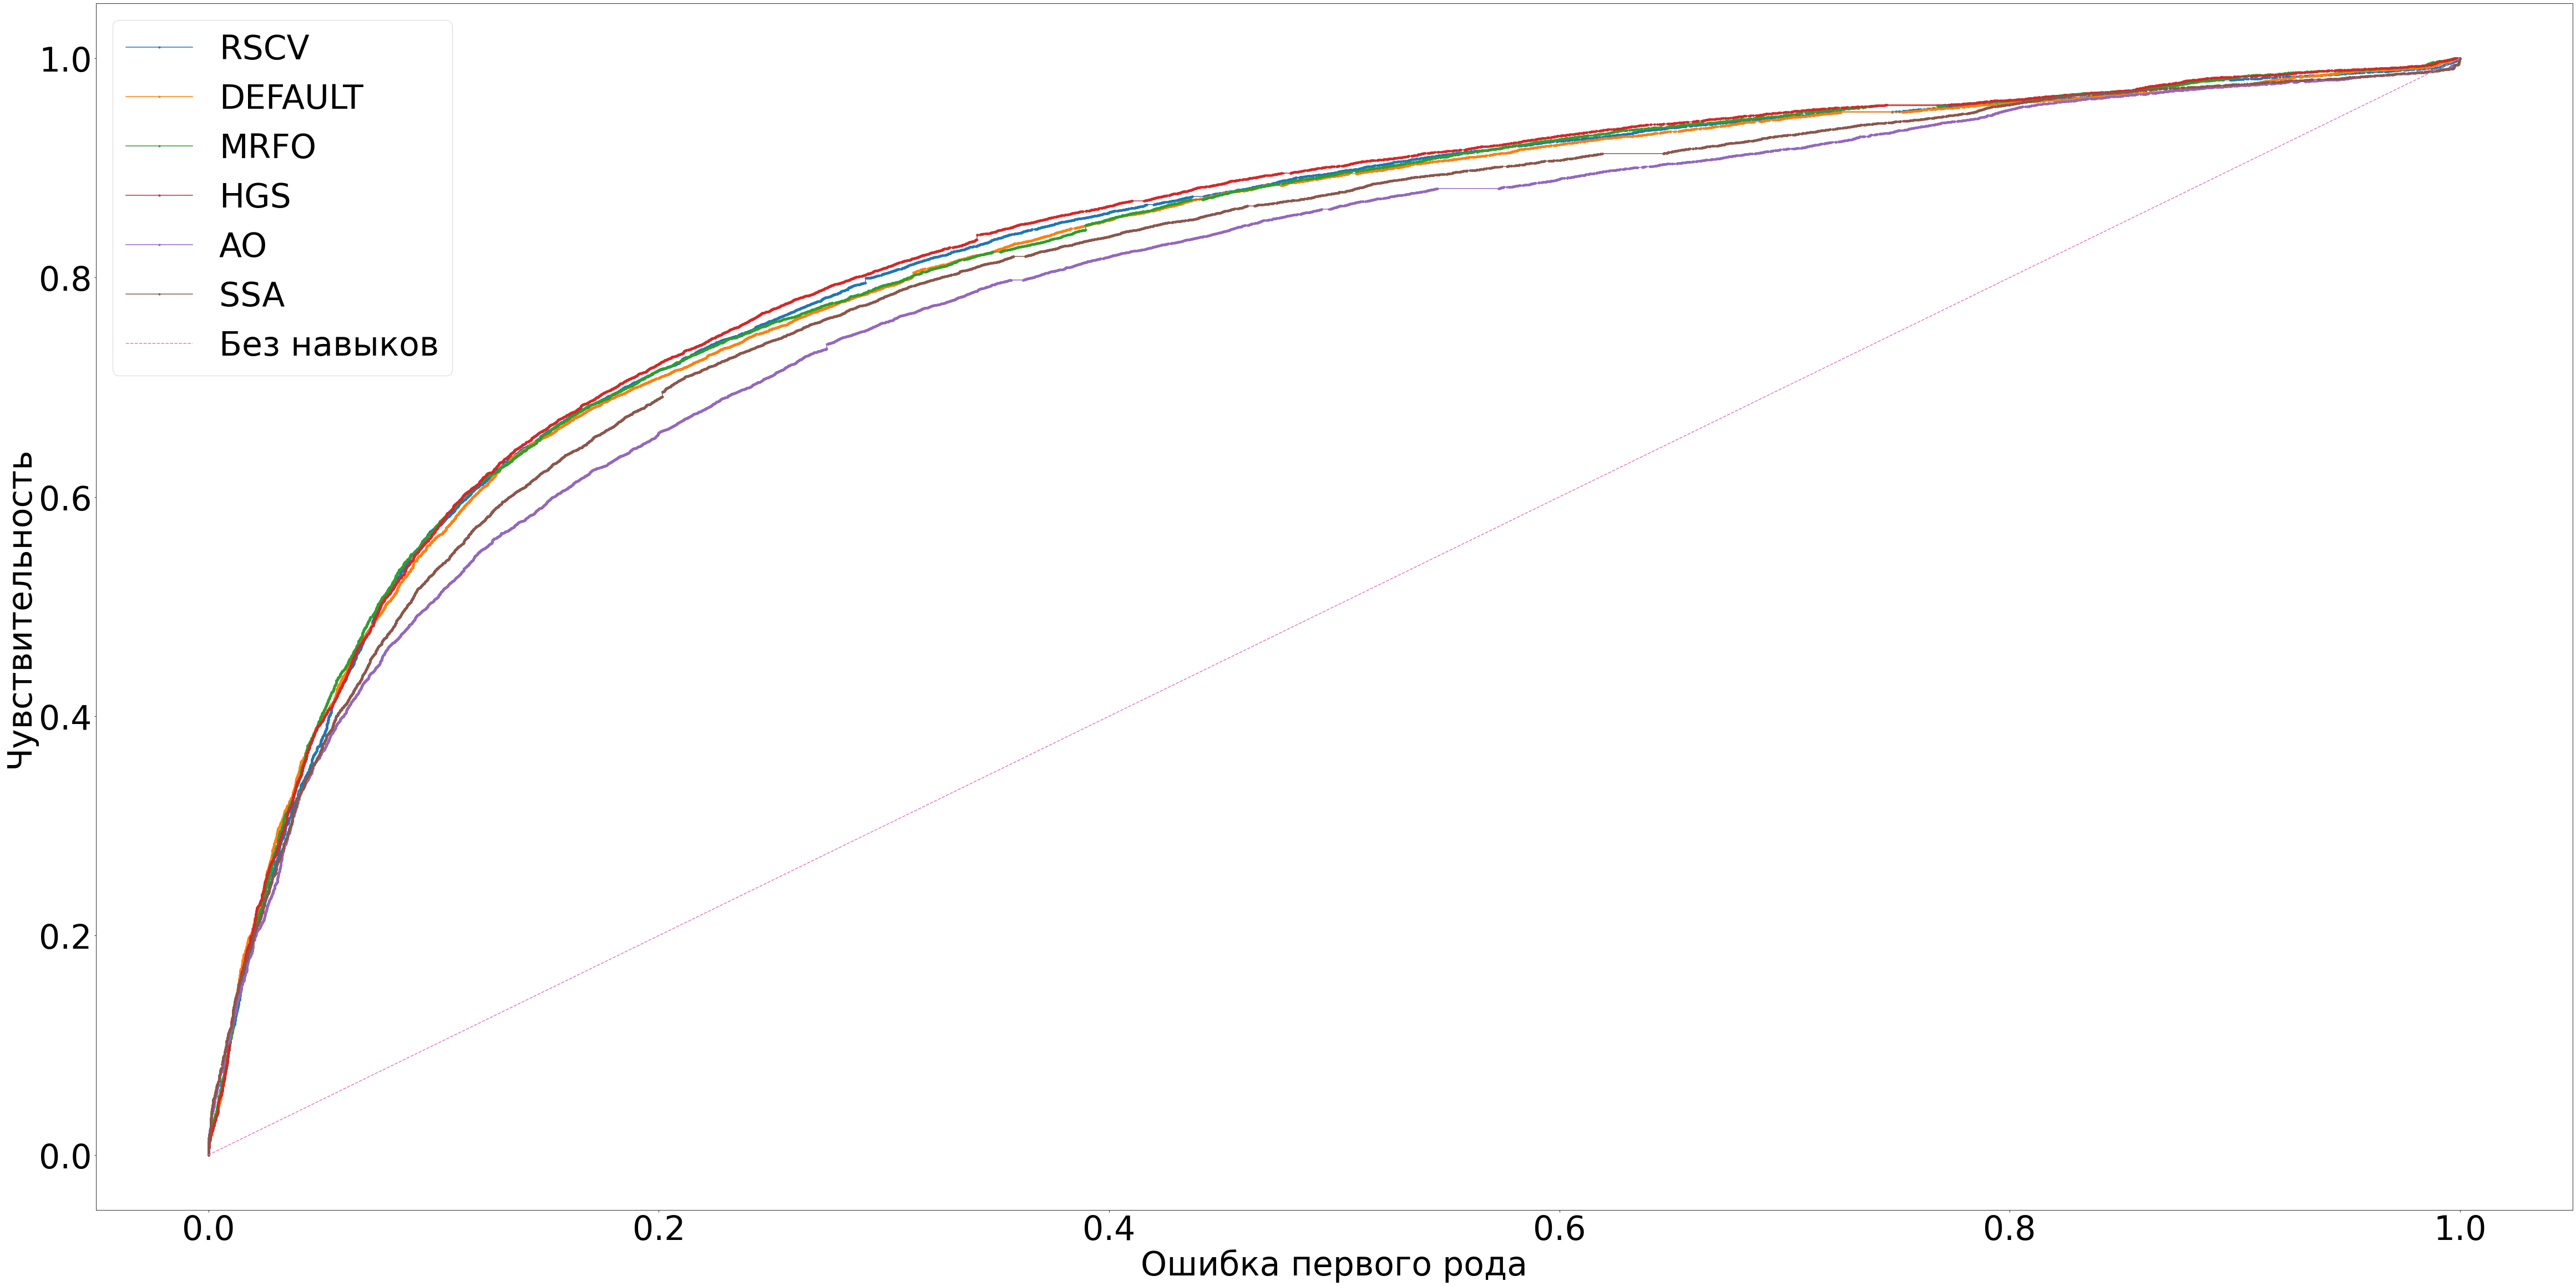

In [62]:
test(LS_clfs, "LS", "EN")

Test models trained with LS on SA
RSCV
Accuracy 0.86176: 
ROC: 0.87903

Confusion matrix
 [[5871 1078]
 [ 198 2083]]
DEFAULT
Accuracy 0.81127: 
ROC: 0.85125

Confusion matrix
 [[5366 1583]
 [ 159 2122]]
MRFO
Accuracy 0.83835: 
ROC: 0.86629

Confusion matrix
 [[5636 1313]
 [ 179 2102]]
HGS
Accuracy 0.83575: 
ROC: 0.86559

Confusion matrix
 [[5605 1344]
 [ 172 2109]]
AO
Accuracy 0.68559: 
ROC: 0.76896

Confusion matrix
 [[4198 2751]
 [ 151 2130]]
SSA
Accuracy 0.85905: 
ROC: 0.86648

Confusion matrix
 [[5919 1030]
 [ 271 2010]]


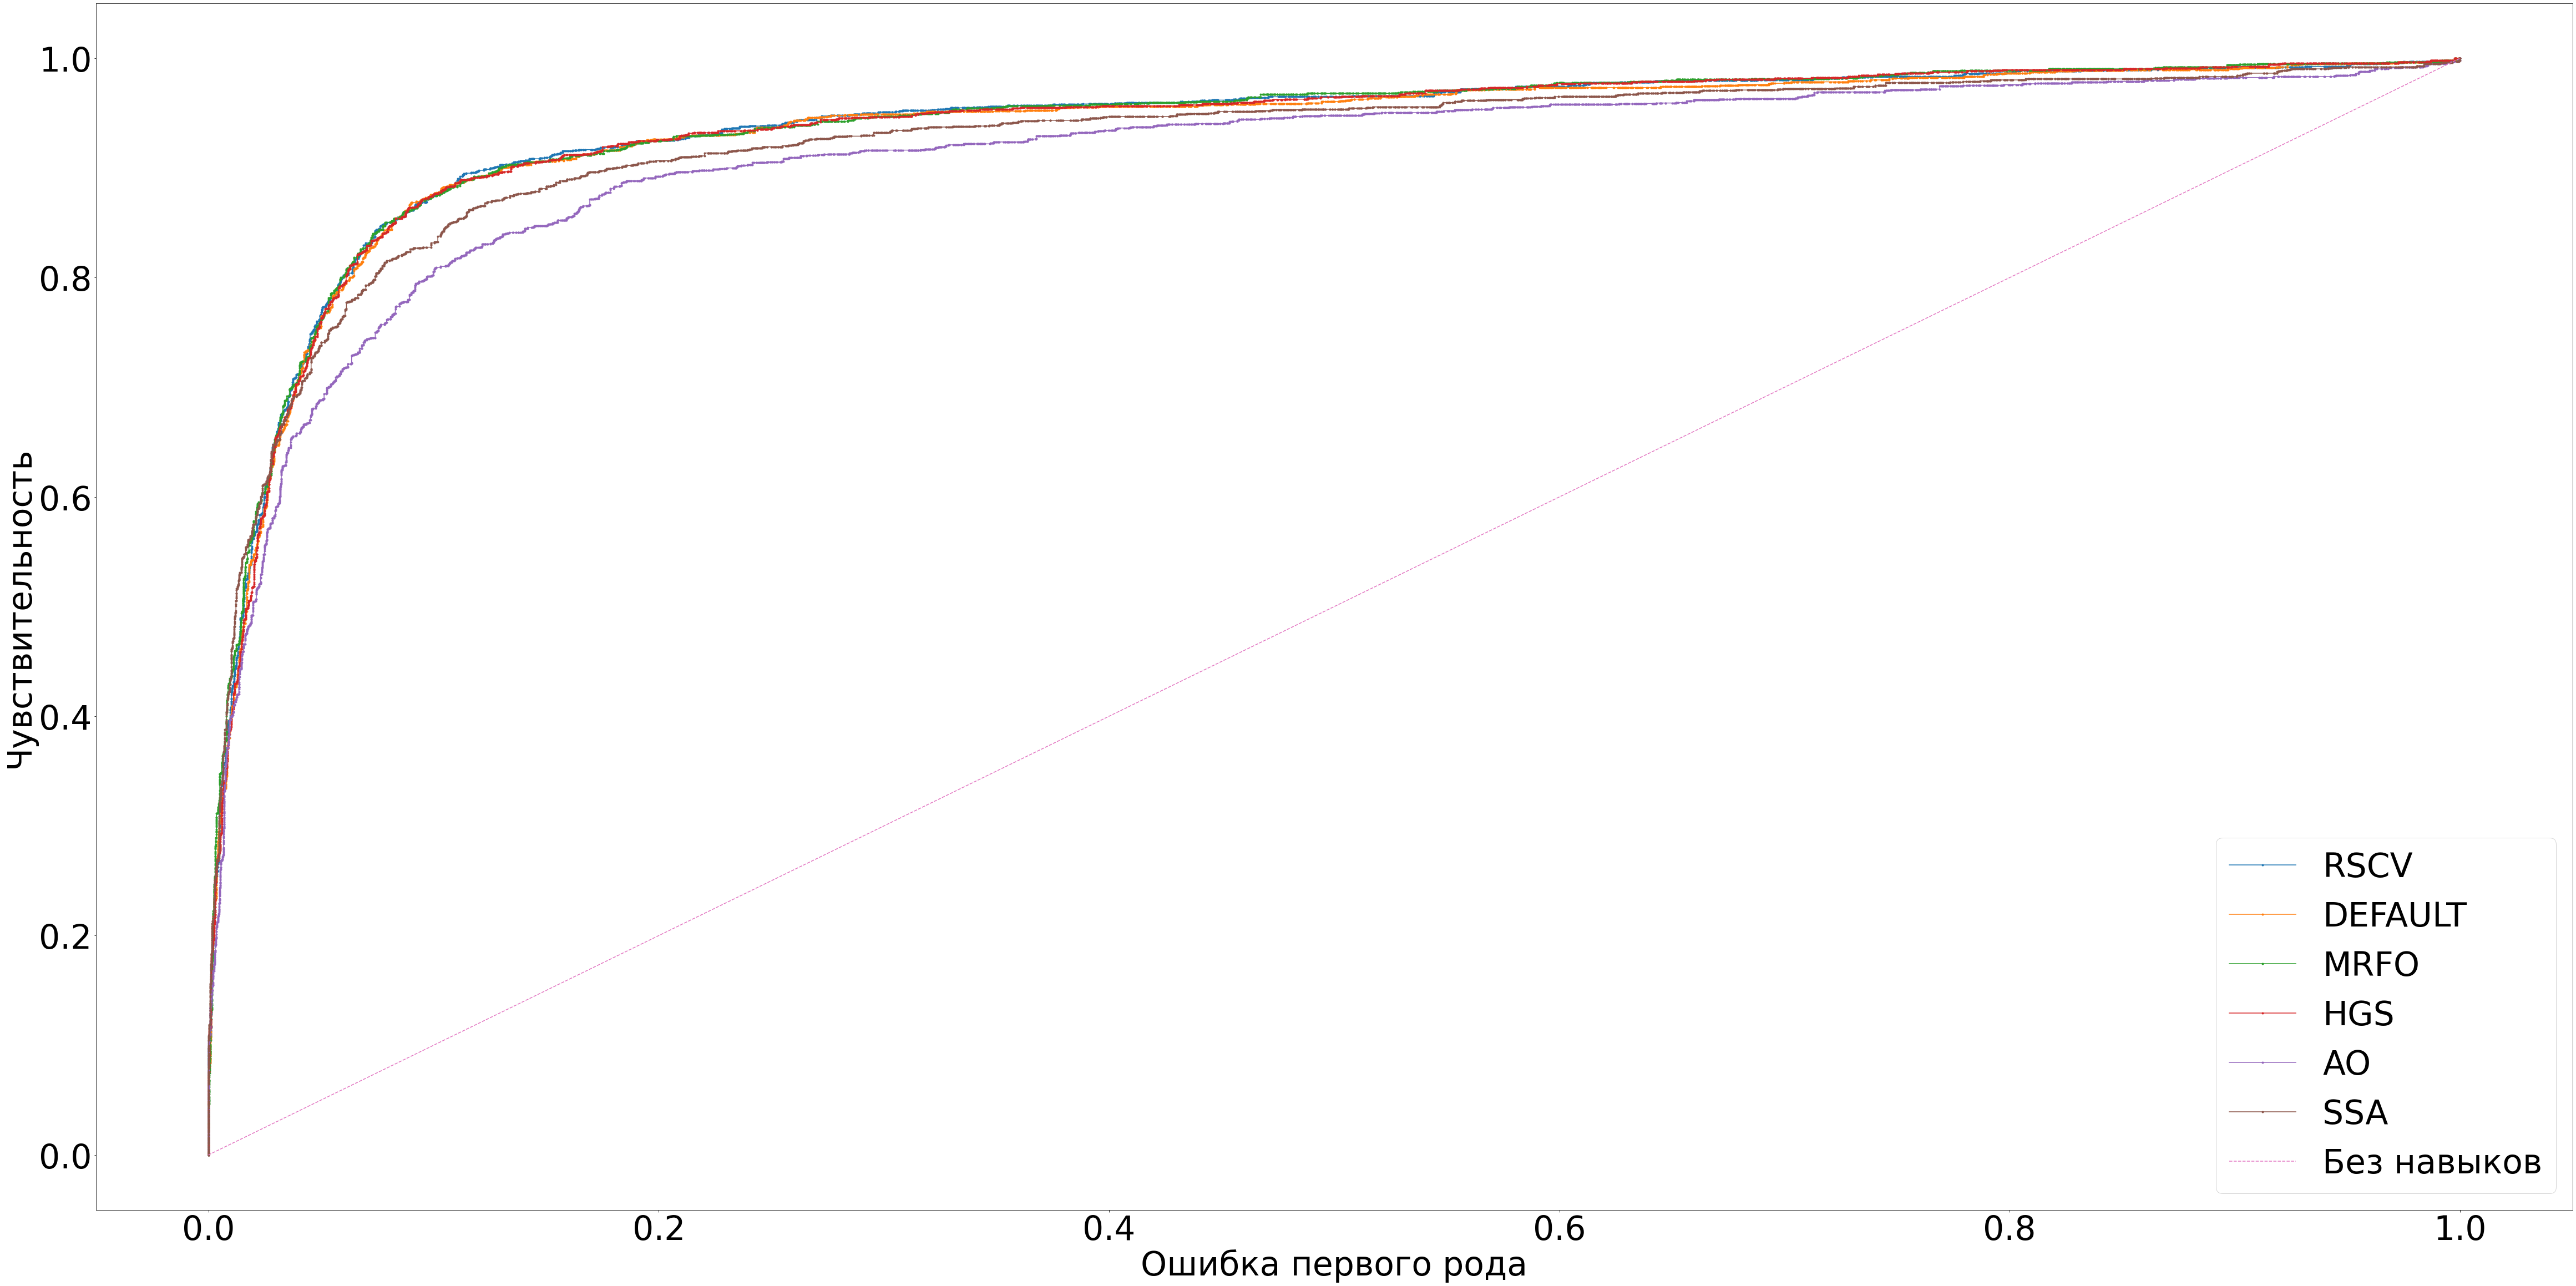

In [63]:
test(LS_clfs, "LS", "SA")

In [64]:
spam_assasin_clfs = {
    "RSCV": create_clf(best_spam_assasin_RSCV),
    "DEFAULT": create_clf(DEFAULT_PARAMS),
    "MRFO": create_clf(best_spam_assasin_MRFO),
    "HGS": create_clf(best_spam_assasin_HGS),
    "AO": create_clf(best_spam_assasin_AO),
    "SSA": create_clf(best_spam_assasin_SSA)
}

In [65]:
print('Train cross-val accuracy scores:')
for alg in spam_assasin_clfs:
    print('Spam Assasin %s %.3f' % (alg, 100*mean(cross_val_score(spam_assasin_clfs[alg], X_spam_assasin, y_spam_assasin, cv=10))))

Train cross-val accuracy scores:
Spam Assasin RSCV 99.198
Spam Assasin DEFAULT 99.198
Spam Assasin MRFO 99.209
Spam Assasin HGS 99.220
Spam Assasin AO 99.198
Spam Assasin SSA 99.155


In [66]:
for alg in spam_assasin_clfs:
    spam_assasin_clfs[alg].fit(X_spam_assasin, y_spam_assasin)

Test models trained with Spam Assasin on Enron
RSCV
Accuracy 0.71731: 
Confusion matrix
 [[14784  1761]
 [ 7770  9400]]
ROC: 0.72051

DEFAULT
Accuracy 0.71722: 
Confusion matrix
 [[14661  1884]
 [ 7650  9520]]
ROC: 0.72029

MRFO
Accuracy 0.71698: 
Confusion matrix
 [[14591  1954]
 [ 7588  9582]]
ROC: 0.71998

HGS
Accuracy 0.71760: 
Confusion matrix
 [[14578  1967]
 [ 7554  9616]]
ROC: 0.72058

AO
Accuracy 0.71731: 
Confusion matrix
 [[14784  1761]
 [ 7770  9400]]
ROC: 0.72051

SSA
Accuracy 0.71339: 
Confusion matrix
 [[14750  1795]
 [ 7868  9302]]
ROC: 0.71663



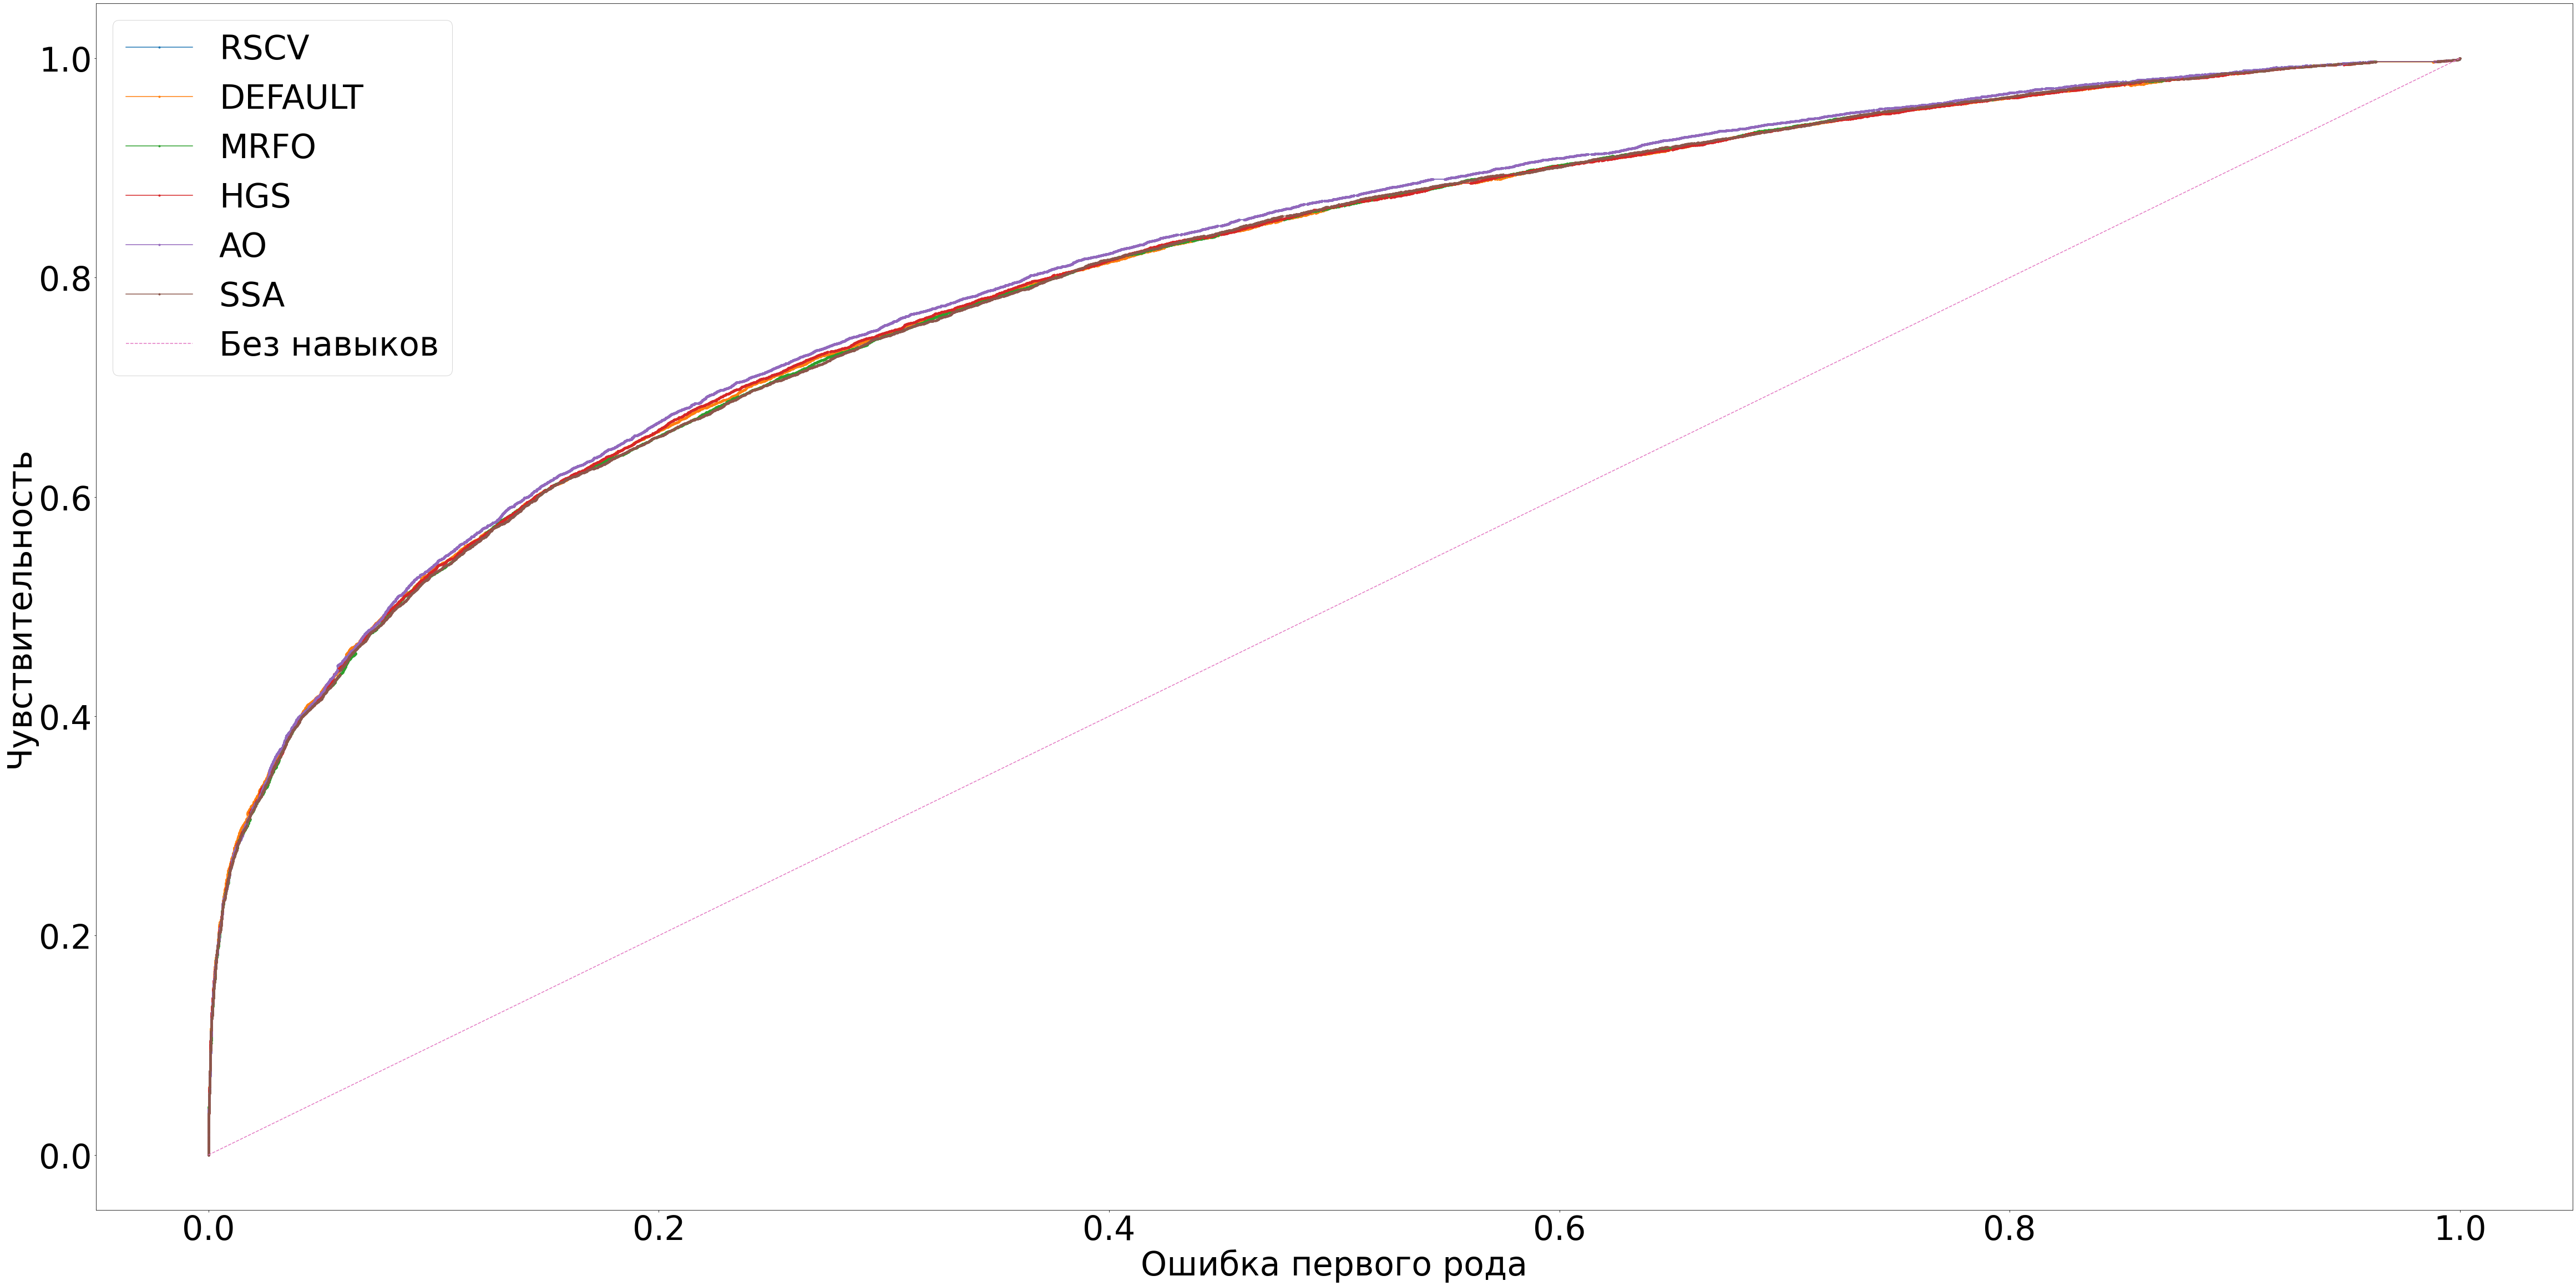

In [67]:
test(spam_assasin_clfs, "Spam Assasin", "Enron")

In [65]:
test(spam_assasin_clfs, "Spam Assasin", "Ling Spam")

NameError: name 'spam_assasin_clfs' is not defined

In [24]:
enron_clfs = {
#     "RSCV": create_clf(best_enron_RSCV),
    "DEFAULT": create_clf(DEFAULT_PARAMS),
#     "MRFO": create_clf(best_enron_MRFO),
    "HGS": create_clf(best_enron_HGS),
#     "AO": create_clf(best_enron_AO),
#     "SSA": create_clf(best_enron_SSA)
}

NameError: name 'best_enron_HGS' is not defined

In [61]:
print('Train cross-val accuracy scores:')
for alg in enron_clfs:
    print('Enron %s %.3f' % (alg, 100*mean(cross_val_score(enron_clfs[alg], X_enron, y_enron, cv=10))))

Train cross-val accuracy scores:
Enron DEFAULT 98.594
Enron HGS 98.612


In [62]:
for alg in enron_clfs:
    enron_clfs[alg].fit(X_enron, y_enron)

Test models trained with Enron on Ling Spam
DEFAULT
Balanced accuracy 0.72530: 
Accuracy 0.55444: 
Confusion matrix
 [[1132 1280]
 [   9  472]]
ROC: 0.72530

AUC Precision Recall: 0.62690
HGS
Balanced accuracy 0.72344: 
Accuracy 0.55133: 
Confusion matrix
 [[1123 1289]
 [   9  472]]
ROC: 0.72344

AUC Precision Recall: 0.62621


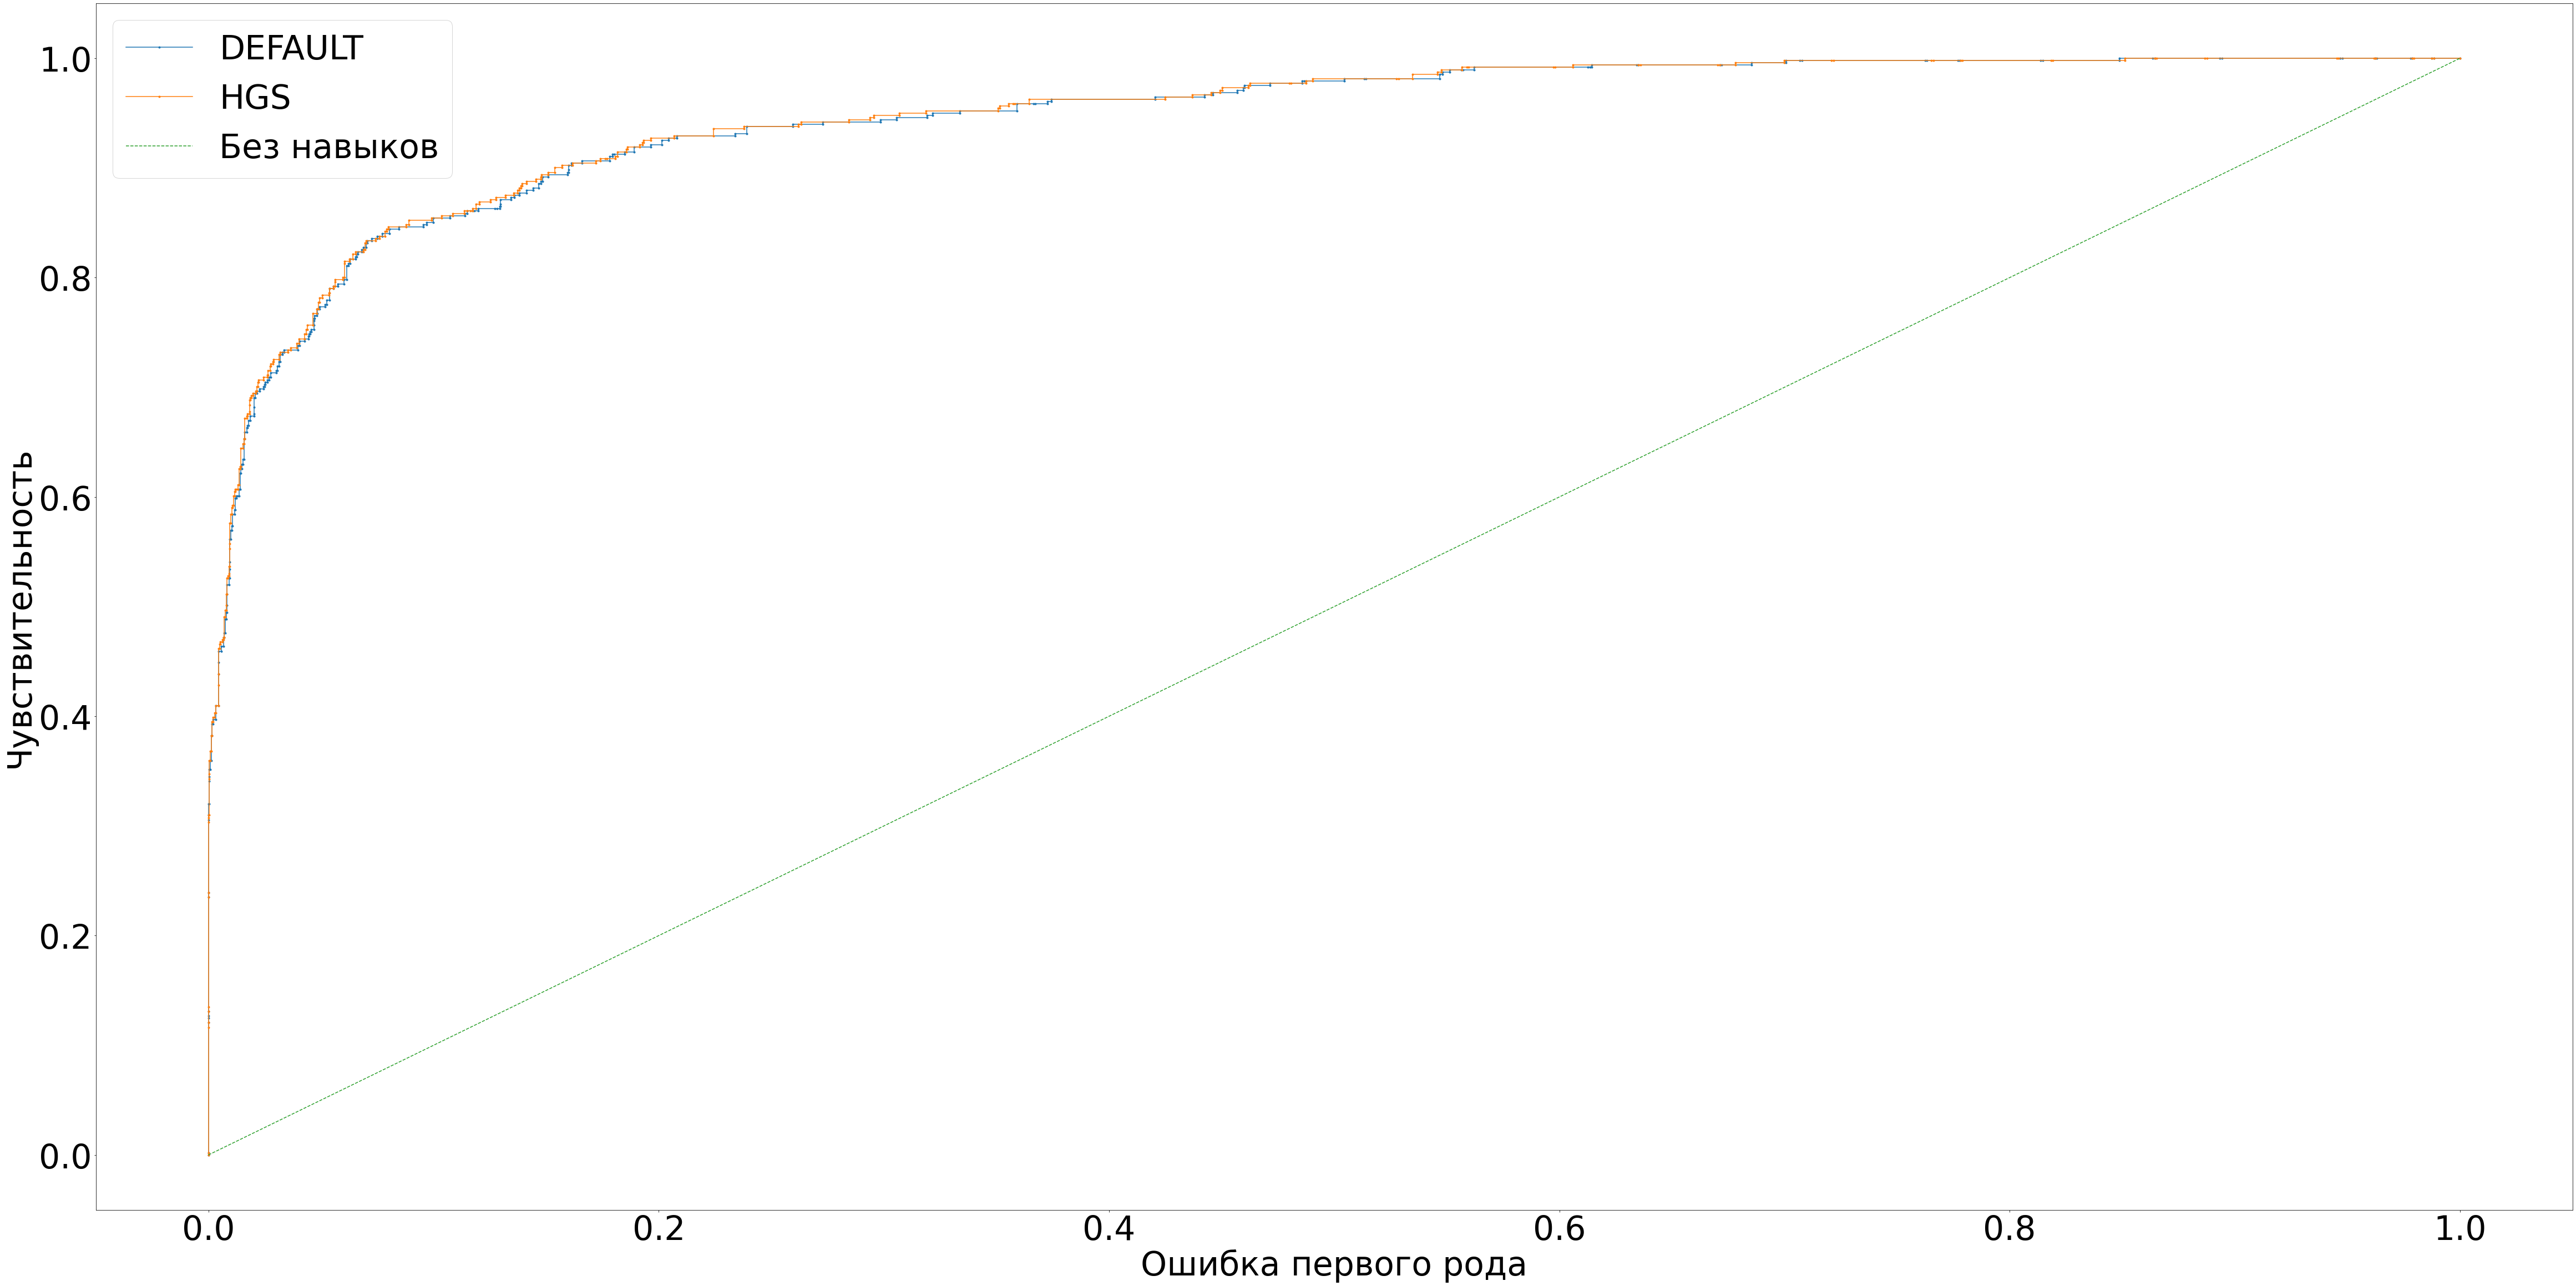

In [63]:
test(enron_clfs, "Enron", "Ling Spam")

Test models trained with Enron on Spam Assasin
DEFAULT
Balanced accuracy 0.60042: 
Confusion matrix
 [[1417 5532]
 [   7 2274]]
ROC: 0.60042

MRFO
Balanced accuracy 0.59848: 
Confusion matrix
 [[1390 5559]
 [   7 2274]]
ROC: 0.59848



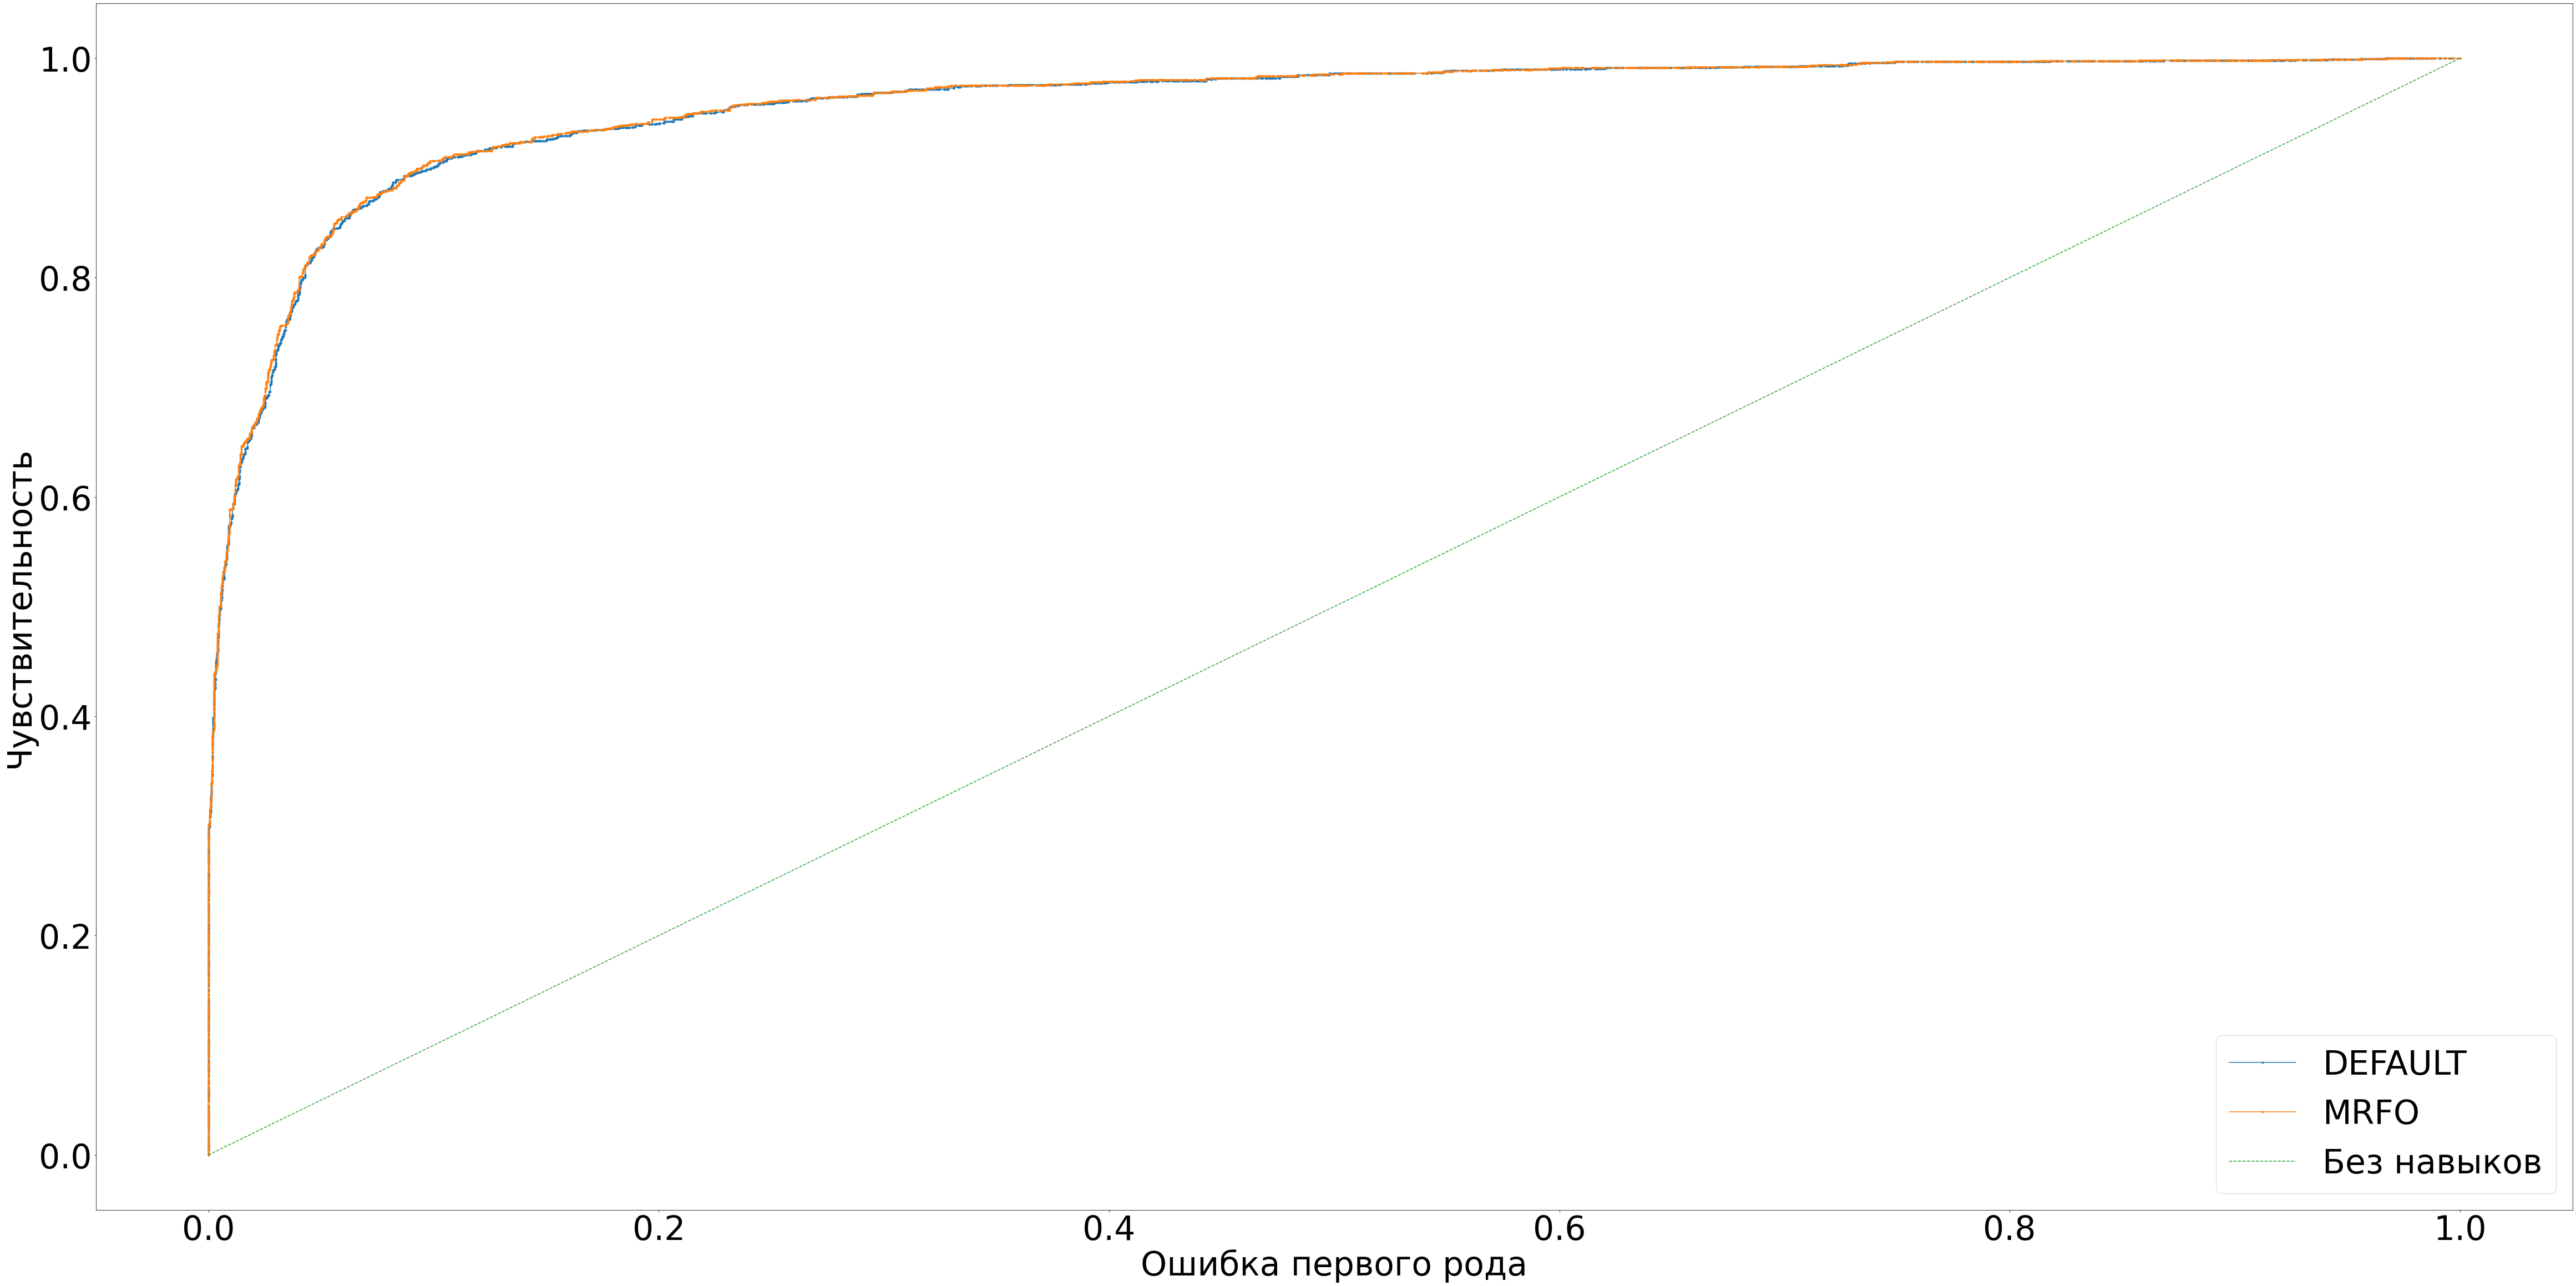

In [56]:
test(enron_clfs, "Enron", "Spam Assasin")

In [23]:
test(enron_clfs, "Enron", "Ling Spam Copy")

NameError: name 'enron_clfs' is not defined

In [25]:
best_ling_spam_MRFO

[0.00010330674968782292, 201.57573785380703, 292.96327512614545]

In [ ]:
best_LS = {
    'RSCV': best_LS_RSCV,
    'MRFO': best_LS_MRFO,
    'DEFAULT': DEFAULT_PARAMS
}